In [2]:
import pandas as pd
import numpy as np
import yfinance  as yf
from tqdm import tqdm
import random
import joblib
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro,  gaussian_kde
import pickle
from tqdm import tqdm
import os

pd.set_option('display.float_format', '{:.2f}'.format)    
pd.set_option('display.max_columns', None) 


In [96]:
# def download_data(data, period='5y'):
#     dfs = []
#     if isinstance(data, dict):
#         for name, ticker in data.items():
#             ticker_obj = yf.Ticker(ticker)
#             hist = ticker_obj.history(period=period)
#             hist.columns = [f"{name}_{col}" for col in hist.columns]  # Add prefix to the name
#             hist.index = pd.to_datetime(hist.index.map(lambda x: x.strftime('%Y-%m-%d')))
#             close_columns = [col for col in hist.columns if col.endswith('_Close')]
#             hist = hist[close_columns]
#             dfs.append(hist)
#     return dfs

# dicts = {#'commodities':commodities_dict,
#          #'b3_stocs': b3_stocks,
#          'SP500': sp500_dict,
#          #'NASDAC100':nasdaq_dict,
#          #'indexes': indexes_dict,
#          #'currencies': currencies_dict, 
#          #'crypto': crypto_dict}
#         }

# # storedAssets = []
# for key, ticker in tqdm(dicts.items()):
#     assets = download_data(ticker)  # Baixa os dados
#     for asset in assets:
#         storedAssets.append(asset)
# assets = storedAssets.copy()
# joblib.dump(assets, 'portfolios.pkl')

In [97]:
filepath = os.path.join('..', 'pkl', 'portfolios.pkl')


In [125]:
filepath
assets = joblib.load(filepath)

In [126]:

bound = 2 * 252  # Define o limite mínimo de tamanho para os ativos
assets = [asset[bound:] for asset in assets if len(asset) >= bound]


In [100]:
assets

[            Microsoft Corporation_Close
 Date                                   
 2021-08-05                       282.22
 2021-08-06                       282.16
 2021-08-09                       281.06
 2021-08-10                       279.22
 2021-08-11                       279.71
 ...                                 ...
 2024-07-30                       422.92
 2024-07-31                       418.35
 2024-08-01                       417.11
 2024-08-02                       408.49
 2024-08-05                       395.15
 
 [754 rows x 1 columns],
             Apple Inc_Close
 Date                       
 2021-08-05           144.59
 2021-08-06           143.90
 2021-08-09           143.85
 2021-08-10           143.37
 2021-08-11           143.62
 ...                     ...
 2024-07-30           218.80
 2024-07-31           222.08
 2024-08-01           218.36
 2024-08-02           219.86
 2024-08-05           209.27
 
 [754 rows x 1 columns],
             NVIDIA Corporation_Clos

In [122]:
class Portfolio:
    """
    A class to manage investment portfolios.

    Attributes:
    - data (DataFrame): A DataFrame containing historical prices of assets.
    - invested_capital (float): The amount of capital invested in the portfolio.
    - window_size (int): The size of the window for processing data.
    - chunk_dfs (list): A list of DataFrames representing data chunks.
    - prices (np.array): An array containing the latest prices of assets.
    - names (list): A list of asset names.
    - dates (list): A list of last dates for each chunk.
    - sharpe_weights (np.array): Optimal weights for maximum Sharpe ratio.
    - min_risk_weights (np.array): Optimal weights for minimum risk.
    - max_sharpe_control (list): Portfolio optimized for maximum Sharpe ratio with rebalancing.
    - max_sharpe (list): Portfolio optimized for maximum Sharpe ratio without rebalancing.
    - min_risk_control (list): Portfolio optimized for minimum risk with rebalancing.
    - min_risk (list): Portfolio optimized for minimum risk without rebalancing.
    - even_weights (list): Portfolio with even weights.
    - smart_max_sharpe_control (list): Smartly rebalanced portfolio optimized for maximum Sharpe ratio.
    - smart_max_sharpe (list): Smartly rebalanced portfolio optimized for maximum Sharpe ratio without rebalancing.
    - smart_min_risk_control (list): Smartly rebalanced portfolio optimized for minimum risk.
    - smart_min_risk (list): Smartly rebalanced portfolio optimized for minimum risk without rebalancing.
    - smart_even_weights (list): Smartly rebalanced portfolio with even weights.
    - portfolio_ROI (list): Evaluation of portfolios' portfolio_portfolio_portfolio_ROI considering each round of optimization and the final ROI.
        
    """
    def __init__(self, data, invested_capital = 1000000.0,  window_size=30):
        self.invested_capital = invested_capital
        self.data = data
        self.window_size = window_size
        
        self.chunk_dfs = self.process_data(window_size)
        self.prices = self.get_prices()
        self.names = self.get_asset_name()
        self.dates  = self.get_last_dates()
        self.sharpe_weights, self.max_sharpe_risk  = self.get_opt_values()
        self.min_risk_weights, self.min_risk = self.get_opt_values(objective = 'risk')
        self.max_sharpe_control= self.dummy_balancer(method='sharpe_control')
        self.max_sharpe = self.dummy_balancer(method = 'sharpe')
        self.min_risk_control = self.dummy_balancer(method = 'risk_control')
        self.min_risk = self.dummy_balancer(method = 'risk') 
        self.even_weights = self.dummy_balancer(method = 'even')
        self.smart_max_sharpe_control = self.smart_balancer(method='sharpe_control')
        self.smart_max_sharpe = self.smart_balancer(method = 'sharpe')
        self.smart_min_risk_control = self.smart_balancer(method = 'risk_control')
        self.smart_min_risk = self.smart_balancer(method = 'risk')
        self.smart_even_weights = self.smart_balancer(method = 'even')
        self.portfolio_ROI  = self.get_portfolio_ROI()
    
    def process_data(self, window_size):    
        """
        Processes data into chunks.portfolio_ROI

        Parameters:
        - window_size: Size of the window.

        Returns:
        - List of DataFrames representing data chunks.
        """
        chunk_dfs = []
        for i in range(0, len(self.data), window_size):
            if i + window_size <= len(self.data):
                chunk_df = self.data.iloc[i:i+window_size].copy()
            else:
                chunk_df = self.data.iloc[i:].copy()
        
            chunk_dfs.append(chunk_df)
            
        return chunk_dfs
    
    
    def simulate_frontier(self, chunk_df, risk_free_rate=0, trading_days=252, simulations=10000, objective='sharpe'):
        """
        Simulates optimal asset allocation based on the Sharpe ratio within a specified tolerance range,
        and selects the one with the highest Sharpe ratio.

        Parameters:
        - chunk_df: DataFrame containing asset prices.
        - risk_free_rate: Risk-free rate.
        - trading_days: Number of trading days.
        - simulations: Number of simulations.
        - sharpe_tolerance: Tolerance range for the Sharpe ratio.
        - objective: 'sharpe' or 'risk' to specify whether to maximize Sharpe ratio or minimize risk.

        Returns:
        - Numpy array representing optimal asset allocation with the highest Sharpe ratio or lowest positive standard deviation.
        """
        max_sharpe_ratio = -np.inf
        min_positive_sd = np.inf
        optimal_weights = None
        num_assets = len(chunk_df.columns)
        simple_returns = chunk_df.pct_change().dropna().mean() * trading_days
        cov_matrix = chunk_df.pct_change().dropna().cov() * trading_days

        for _ in range(simulations):
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
            returns = np.dot(weights, simple_returns)
            var = np.dot(weights.T, np.dot(cov_matrix, weights))
            sd = np.sqrt(var)

            if objective == 'sharpe':
                sharpe_ratio = (returns - risk_free_rate) / sd
                if sharpe_ratio > max_sharpe_ratio:
                    max_sharpe_ratio = sharpe_ratio
                    optimal_weights = weights
            elif objective == 'risk':
                if sd > 0 and sd < min_positive_sd:
                    min_positive_sd = sd
                    optimal_weights = weights
                    
            else:
                raise ValueError("Objective must be either 'sharpe' or 'risk'.")
        
        return optimal_weights, sd

    def get_opt_values(self, lower_bound=0.00, upper_bound=1, objective='sharpe'):
        
        """
        Calculate optimal portfolio weights for each chunk of data using mean-variance optimization.

        Parameters:
        lower_bound : float, optional
            The minimum bound for the weights. Default is 0.00.
        upper_bound : float, optional
            The maximum bound for the weights. Default is 1.
        objective : str, optional
            The objective for optimization. Can be 'sharpe' for maximizing the Sharpe ratio
            or 'min_volatility' for minimizing portfolio volatility. Default is 'sharpe'.
        Returns:
        np.array
            A numpy array of optimal weights for each chunk of data.
        """ 
        
        opt_weights = []
        pfl_risk = []
        
        for i, chunk_df in enumerate(self.chunk_dfs):
            try: 
                mu = expected_returns.mean_historical_return(chunk_df)
                S = risk_models.sample_cov(chunk_df)
                ef = EfficientFrontier(mu, S, weight_bounds=(lower_bound, upper_bound))
                if objective == 'sharpe':
                    ef.max_sharpe(risk_free_rate=0)
                else:
                    ef.min_volatility()
                cleaned_weights = ef.clean_weights()
                weights = [weight for _, weight in cleaned_weights.items()]
                risk = ef.port_volatility()
                opt_weights.append(weights)
                pfl_risk.append(risk)

            except Exception as e:
     
                if objective == 'sharpe':
                    simulated_max_sharpe_w, simulated_max_sharpe_risk  = self.simulate_frontier(chunk_df, risk_free_rate=0, objective=objective)
                    opt_weights.append(simulated_max_sharpe_w)
                    pfl_risk.append(simulated_max_sharpe_risk)
                else:
                    simulated_lowest_risk_w, simulated_lowest_risk = self.simulate_frontier(chunk_df, objective=objective)
                    opt_weights.append(simulated_lowest_risk_w)
                    pfl_risk.append(simulated_lowest_risk)
 
        optimal_weights = [weights for weights in opt_weights if weights is not None]
        optimal_risk = [risk for risk in pfl_risk if risk is not None]
        
        return  np.array(optimal_weights),  np.array(optimal_risk)

    def get_prices(self):
        prices = []
        for chunk_df in self.chunk_dfs:
            last_values = chunk_df.iloc[-1].values
            prices.append(last_values)
        return np.array(prices)

    def get_last_dates(self):
        """
        Gets the last index for each chunk.

        Returns:
        - List of last indices for each chunk.
        """
        last_indices = []
        for chunk_df in self.chunk_dfs[1:]:
            last_index = chunk_df.index[-1]
            last_index_date_only = str(last_index).split()[0]
            last_indices.append(last_index_date_only)
        return last_indices

    def get_asset_name(self, string ='_Close' ):
        """
        Gets the names of assets.

        Returns:
        - List of asset names.
        """
        names = []
        df = self.chunk_dfs[0]
        for column in df.columns:
            if  string in column:
                names.append(column.replace(string, ''))
            else:
                names.append(column)
        return names

    def smart_balancer(self, method='sharpe_control'):
        prices = self.prices
        
        if method == 'sharpe':
            weights = self.sharpe_weights
            display(len(weights))
            display(len(prices))
        elif method == 'risk':
            weights = self.min_risk_weights
        elif method == 'even':
            weights = np.full_like(prices, 1 / prices.shape[1])
        elif method == 'risk_control':
            weights = np.full_like(prices, self.min_risk_weights[0])
        else:
            weights = np.full_like(prices, self.sharpe_weights[0])

        
        sold_all = np.zeros_like(prices)
        funds = np.zeros_like(prices)
        total_capital = np.zeros_like(prices)
        quantities = np.zeros_like(prices)
        smart_weights_balanced_portfolio = []
        
        for i in range(0, len(weights)):
            df = pd.DataFrame()
            if i == 0:
                quantities[i] = self.invested_capital * weights[i] / prices[i]
                total_capital[i] = self.invested_capital * weights[i]
            else:
                for j in range(1, len(prices[i])):
                    if prices[i][j] > prices[i - 1][j]:
                        funds[i][j] = (prices[i][j]) * quantities[i - 1][j]
                        sold_all[i][j] = 1
                    else:
                        funds[i][j] = 0
                        sold_all[i][j] = 0
                        
                total_funds = np.sum(funds[i])
                quantities[i] = total_funds * weights[i] / prices[i]
                for k in range(1, len(prices[i])):
                    if sold_all[i][k] == 0:
                        quantities[i][k] += quantities[i - 1][k]
                        total_capital[i][k] = quantities[i - 1][k] * prices[i - 1][k] + quantities[i][k] * prices[i][k]
                    else:
                        total_capital[i][k] = quantities[i][k] * prices[i][k]
            
                df[f'opt_weights{i}'] =  weights[i]
                df[f'prices_t{i-1}'] = prices[i - 1]
                df[f'prices_t{i}'] = prices[i]
                df[f'weights_t{i-1}'] = weights[i-1]
                df[f'weights_t{i}'] = total_capital[i] / np.sum(total_capital[i]) 
                df[f'funds_t{i}'] = funds[i]
                df[f'quantities_t{i-1}'] = quantities[i - 1]
                df[f'quantities_t{i}'] = quantities[i]
                df[f'invested_capital_t{i-1}'] = quantities[i - 1] * prices[i - 1]
                df[f'invested_capital_t{i}'] = total_capital[i]
                df[f'cumulative_capital_t{i-1}'] = df[f'invested_capital_t{i-1}'].cumsum()
                df[f'cumulative_capital_t{i}'] = df[f'invested_capital_t{i}'].cumsum()
                df.index = self.names
                smart_weights_balanced_portfolio.append(df)

        return smart_weights_balanced_portfolio

    def dummy_balancer(self, method='sharpe_control'):
        
        """
        Adjusts the weights of a portfolio based on the specified method.
        
        Parameters:
        - self: Reference to the instance of the object containing the portfolio data, including prices (`prices`), Sharpe weights (`sharpe_weights`), minimum risk weights (`min_risk_weights`), and invested capital (`invested_capital`).
        - method (str, optional): The balancing method to use. Possible values are:
        - 'sharpe': Uses the Sharpe weights.
        - 'risk': Uses the minimum risk weights.
        - 'even': Distributes the weights equally among the assets.
        - 'risk_control': Uses a risk control strategy based on the first minimum risk weight.
        - Default is 'sharpe_control': Uses the first Sharpe weight.
        
        Returns:
        - simple_weights_balanced_portfolio (list of pandas.DataFrame): A list of DataFrames, each containing the prices, weights, quantities, and capital invested for each asset in each period.
        """
       
        prices = self.prices
        if method == 'sharpe':
            weights = self.sharpe_weights
        elif method == 'risk':
            weights = self.min_risk_weights
        elif method == 'even':
            weights = np.full_like(prices, 1 / prices.shape[1])
        elif method == 'risk_control':
            weights = np.full_like(prices, self.min_risk_weights[0])
        else:
            weights = np.full_like(prices, self.sharpe_weights[0])
            
        total_capital = np.zeros_like(prices) 
        quantities = np.zeros_like(prices)
        simple_weights_balanced_portfolio = []

        for i in range(1, len(weights)):
            df = pd.DataFrame()
            quantities[i-1] = self.invested_capital * weights[i-1] / prices[i-1] 
            total_capital[i] = quantities[i-1] * prices[i]   
            quantities[i] = np.sum(total_capital[i]) * weights[i] / prices[i]
            df[f'prices_t{i-1}'] = prices[i - 1]
            df[f'prices_t{i}'] = prices[i]
            df[f'weights_t{i-1}'] = weights[i-1]
            df[f'weights_t{i}'] = weights[i]
            df[f'funds_t{i}'] = prices[i] * quantities[i]
            df[f'quantities_t{i-1}'] = quantities[i-1]
            df[f'quantities_bought_t{i}'] = quantities[i] - quantities[i-1]
            df[f'quantities_t{i}'] = quantities[i]
            df[f'invested_capital_t{i-1}'] = quantities[i-1] * prices[i-1]
            df[f'invested_capital_t{i}'] = total_capital[i]
            df[f'cumulative_capital_t{i-1}'] = df[f'invested_capital_t{i-1}'].cumsum()
            df[f'cumulative_capital_t{i}'] = df[f'invested_capital_t{i}'].cumsum()
            df.index = self.names
            simple_weights_balanced_portfolio.append(df)
            
        return simple_weights_balanced_portfolio

    def smart_balancer(self, method='sharpe_control'):
        prices = self.prices
        if method == 'sharpe':
            weights = self.sharpe_weights
        elif method == 'risk':
            weights = self.min_risk_weights
        elif method == 'even':
            weights = np.full_like(prices, 1 / prices.shape[1])
        elif method == 'risk_control':
            weights = np.full_like(prices, self.min_risk_weights[0])
        else:
            weights = np.full_like(prices, self.sharpe_weights[0])

        sold_all = np.zeros_like(prices)
        funds = np.zeros_like(prices)
        total_capital = np.zeros_like(prices)
        quantities = np.zeros_like(prices)
        smart_weights_balanced_portfolio = []
        
        for i in range(len(weights)):
            df = pd.DataFrame()
            if i == 0:
                quantities[0] = self.invested_capital * weights[i] / prices[i]
                total_capital[0] = self.invested_capital * weights[i]
            else:
                for j in range(0, len(prices[i])):
                    if prices[i][j] > prices[i - 1][j]:
                        funds[i][j] = (prices[i][j]) * quantities[i - 1][j]
                        sold_all[i][j] = 1
                    else:
                        funds[i][j] = 0
                        sold_all[i][j] = 0
                        
                total_funds = np.sum(funds[i])
                quantities[i] = total_funds * weights[i] / prices[i]

                for k in range(0, len(prices[i])):
                    if sold_all[i][k] == 0:
                        quantities[i][k] += quantities[i - 1][k]
                        total_capital[i][k] = quantities[i - 1][k] * prices[i - 1][k] + quantities[i][k] * prices[i][k]
                    else:
                        total_capital[i][k] = quantities[i][k] * prices[i][k]
            
                df[f'opt_weights{i}'] =  weights[i]
                df[f'prices_t{i-1}'] = prices[i - 1]
                df[f'prices_t{i}'] = prices[i]
                df[f'weights_t{i-1}'] = weights[i-1]
                df[f'weights_t{i}'] = total_capital[i] / np.sum(total_capital[i]) 
                df[f'funds_t{i}'] = funds[i]
                df[f'quantities_t{i-1}'] = quantities[i - 1]
                df[f'quantities_t{i}'] = quantities[i]
                df[f'invested_capital_t{i-1}'] = quantities[i - 1] * prices[i - 1]
                df[f'invested_capital_t{i}'] = total_capital[i]
                df[f'cumulative_capital_t{i-1}'] = df[f'invested_capital_t{i-1}'].cumsum()
                df[f'cumulative_capital_t{i}'] = df[f'invested_capital_t{i}'].cumsum()
                df.index = self.names
                smart_weights_balanced_portfolio.append(df)

        return smart_weights_balanced_portfolio

    def plot_ROI_over_time(self, return_type='lastest_ROI', strategies='all'):
        data = self.portfolio_ROI
        rows = []
        all_strategies = list(data[0].keys())

        for i, date_data in enumerate(data):
            row = {'date': self.dates[i]}
            for strategy in all_strategies:
                if strategy in date_data:
                    row[f'{strategy}_previous_ROI'] = date_data[strategy]['previous_ROI']
                    row[f'{strategy}_lastest_ROI'] = date_data[strategy]['lastest_ROI']
            rows.append(row)

        df = pd.DataFrame(rows)
        df.set_index('date', inplace=True)

        if strategies == 'all':
            columns_to_plot = [col for col in df.columns if col.endswith(f'_{return_type}')]
        else:
            columns_to_plot = [col for col in df.columns if any(col.startswith(strategy) for strategy in strategies) and col.endswith(f'_{return_type}')]

        if not columns_to_plot:
            raise ValueError(f"No columns found for return_type '{return_type}' with the specified strategies.")

        df = df[columns_to_plot]

        fig, ax = plt.subplots(figsize=(14, 8))
        df.plot(ax=ax, linestyle='-', marker='o', markersize=6)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('ROI', fontsize=12)
        ax.set_title(f'Returns Over Time for {return_type}', fontsize=14)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        fig.tight_layout()

        return fig

In [123]:
class BacktestPortfolios:
    def __init__(self, assets, num_combinations, num_assets, window_size=30, seed=52):
        self.assets = assets
        self.window_size = window_size
        self.num_assets = num_assets
        self.num_combinations = num_combinations
        self.seed = seed
        self.combinations = self.generate_combinations()
        self.portfolios = self.analyze_portfolios()
        self.smart_strategies, self.dummy_strategies = self.normalize_strategies()

    def generate_combinations(self):
        random.seed(self.seed)
        combinations = []
        for _ in range(self.num_combinations):
            shuffled_assets = self.assets[:]
            random.shuffle(shuffled_assets)
            combination = random.sample(shuffled_assets, self.num_assets)
            concatenated_df = pd.concat(combination, axis=1, join='inner')
            if not concatenated_df.empty:
                combinations.append(concatenated_df)
            
        return combinations

    def analyze_portfolios(self):
        portfolios = {}
        for i, df in tqdm(enumerate(self.combinations), total=self.num_combinations):
            portfolio_name = f'n_assets_{self.num_assets}_window_size_{self.window_size}_{i}'
            try:
                portfolios[portfolio_name] = Portfolio(data=df, invested_capital=1000000, window_size=self.window_size)
            except Exception as e:
                raise RuntimeError(f"Error analyzing portfolio {portfolio_name}: {e}")
        
        return portfolios

    def normalize_strategies(self, return_type='portfolio_ROI',
                             roi_type='lastest_ROI', 
                             smart_normalizer='smart_even_weights', 
                             dummy_normalizer='even_weights',
                             period='last'):
        
        smart_normalized_strategies = []
        dummy_normalized_strategies = []
        for _, plf in self.portfolios.items():
            roi_data = getattr(plf, return_type)

            if not roi_data: 
                continue

            if period == 'last':
                roi_data = [roi_data[-1]]

            for period_data in roi_data:
                smart_denominator = period_data.get(smart_normalizer, {}).get(roi_type, 1)
                dummy_denominator = period_data.get(dummy_normalizer, {}).get(roi_type, 1)

                smart_normalized = {key: value.get(roi_type, 0) / smart_denominator
                                    for key, value in period_data.items()
                                    if 'smart' in key and 'smart_even_weights' not in key
                                    }
                dummy_normalized = {key: value.get(roi_type, 0) / dummy_denominator
                                    for key, value in period_data.items()
                                    if 'smart' not in key and 'even_weights' not in key
                                    }

                smart_normalized_strategies.append(smart_normalized)
                dummy_normalized_strategies.append(dummy_normalized)

        return smart_normalized_strategies, dummy_normalized_strategies


In [124]:
class BacktestAnalysis:
    def __init__(self, smart_strategies=None, dummy_strategies=None, load: bool = False, window_size: list = None):
        self.smart_strategies = smart_strategies if smart_strategies else []
        self.dummy_strategies = dummy_strategies if dummy_strategies else []
        self.portfolios = None
        self.load = load
        self.window_size = window_size if window_size else [30, 60, 90, 120, 150, 180]

        if self.load:
            self.load_optimizations()
    
    def load_optimizations(self):
        base_dir = '..\\pkl'
        all_smart_strategies = {ws: [] for ws in self.window_size}
        all_dummy_strategies = {ws: [] for ws in self.window_size}
        all_portfolios = {ws: [] for ws in self.window_size}
        
        for filename in os.listdir(base_dir):
            if filename.endswith('.pkl'):
                for ws in self.window_size:
                    if f'window_{str(ws)}' in filename:
                        file_path = os.path.join(base_dir, filename)
                        try:
                            with open(file_path, 'rb') as file:
                                backtest_portfolio = pickle.load(file)
                                all_smart_strategies[ws].extend(backtest_portfolio.smart_strategies)
                                all_dummy_strategies[ws].extend(backtest_portfolio.dummy_strategies)
                                all_portfolios[ws].extend(backtest_portfolio.portfolios)
                                
                        except (pickle.UnpicklingError, EOFError, KeyError) as e:
                            print(f"Error processing file {filename}: {e}")

        self.smart_strategies = all_smart_strategies
        self.dummy_strategies = all_dummy_strategies
        self.portfolios = all_portfolios
    
    def test_distribution(self, strategy_type='smart', keys='all', window_size=None):
        """
        Tests the distribution of data from a specified type of strategy (smart or dummy) for normality.

        Parameters:
        strategy_type (str): The type of strategy to test. Either 'smart' or 'dummy'.
        keys (str or list, optional): 
        The keys to test. If 'all', tests all keys found in the strategies. 
        If a list of keys, only tests the specified keys. Default is 'all'.

        Returns:
        list of dict: A list of dictionaries containing the results of the normality test for each key.
            Each dictionary has the following keys:
            - 'key': The key being tested.
            - 'normal': A boolean indicating if the distribution is normal (p-value > 0.05).
            - 'p_value': The p-value from the Shapiro-Wilk test for normality.
        """
        distribution_results = []
        
        if window_size is None:
            window_size = [self.window_size]
            
        for ws in window_size:
            if strategy_type == 'smart':
                strategies = []
                strategies.extend(self.smart_strategies.get(ws, []))
                    
            elif strategy_type == 'dummy':
                strategies = []
                strategies.extend(self.dummy_strategies.get(ws, []))
            else:
                raise ValueError("Invalid strategy_type. Must be 'smart' or 'dummy'.")

            if keys == 'all':
                all_keys = set().union(*(strategy.keys() for strategy in strategies))
            else:
                all_keys = keys
                        
            all_data = {key: [] for key in all_keys}
            
            for strategy in strategies:
                for key in all_data.keys():
                    value = strategy.get(key, None)
                    if value is not None:
                        if isinstance(value, (list, np.ndarray)):
                            all_data[key].extend(value)
                        else:
                            all_data[key].append(value)
                                
            for key in all_data.keys():
                if len(all_data[key]) >= 3:
                    _, p_value = shapiro(all_data[key])
                    normal = p_value > 0.05

                    distribution_results.append({
                        'key': key,
                        'normal': normal,
                        'p_value': p_value,
                        'window_size': ws
                    })

                    if normal:
                        self.plot_histogram(data=all_data[key], strategy=f'{strategy_type}_{key}', window_size=ws)
                    else:
                        self.plot_kde(data=all_data[key], strategy=f'{strategy_type}_{key}', window_size=ws)
                else:
                    print(f"Insufficient data for key '{key}' to perform normality test.")
                
        return distribution_results

    
    def plot_histogram(self, data, strategy, prob=1, window_size = None, auto_save=True):
        """
        Plots a histogram of initial returns for a specific strategy and adjusts the bar colors based on data quartiles.

        Args:
            data (list or array-like): List or array containing the initial return data to be plotted.
            strategy (str): The name of the strategy to be included in the chart title and legend.
            prob (float, optional): Probability value to highlight with a vertical line on the chart. Default is 1.
            auto_save (bool, optional): If True, automatically saves the generated chart as a PNG file. Default is True.

        Returns:
            None

        Note:
            - The generated chart includes:
            - A histogram of the data with bars colored according to quartiles.
            - A black line representing the normal distribution fitted to the data.
            - A red vertical line indicating the value specified by `prob`.
            - The probability of returns greater than `prob` displayed in the legend.

        Example:
            >>> plot_histogram(data=[0.1, 0.5, 0.3, 0.7], strategy='StrategyA', prob=0.2)
        """
        fig, ax = plt.subplots(figsize=(12, 8))  # Create a figure and axis object

        q1, q2, q3 = np.percentile(data, [25, 50, 75])
        n, bins, patches = ax.hist(data, bins=30, alpha=0.7, label=strategy, edgecolor='black')

        for patch, bin_left in zip(patches, bins[:-1]):
            if bin_left < q1:
                patch.set_facecolor('red')
            elif bin_left < q2:
                transition_ratio = (bin_left - q1) / (q2 - q1)
                patch.set_facecolor(plt.cm.Blues(transition_ratio))
            elif bin_left < q3:
                transition_ratio = (bin_left - q2) / (q3 - q2)
                patch.set_facecolor(plt.cm.Blues(transition_ratio))
            else:
                patch.set_facecolor('blue')

            mu, std = norm.fit(data)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            p = norm.pdf(bin_centers, mu, std)
            p_scaled = p * np.max(n) / np.max(p)
            ax.plot(bin_centers, p_scaled, 'k', linewidth=2, label='Normal Distribution', alpha=0.5)
            ax.axvline(x=1, color='r', linestyle='--', label='Value 1')
            probability = np.sum(np.array(data) > prob) / len(data)
            ax.legend([f'Probability of returns > 1: {probability:.2f}'])
            ax.set_title(f'Histogram of Initial Returns for: {strategy}  for {len(data)} combinations')
            ax.set_xlabel('Last_ROI')
            ax.set_ylabel('Frequency')
            ax.set_xlim(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)))
            ax.set_ylim(0, max(n) + 0.25 * max(n))
            ax.grid(True)

            if auto_save:
                fig_name = f'backtest_for_{len(data)}_combinations_{window_size}_for_strategy_{strategy}.png'
                fig.savefig(fig_name, bbox_inches='tight')  # Save the figure with tight bounding box

            plt.show()

    def plot_kde(self, data, strategy, prob=1, window_size = None, auto_save=True):
        """
        Plots a Kernel Density Estimate (KDE) plot of initial returns for a specific strategy and highlights different data quartiles.

        Args:
            data (list or array-like): List or array containing the initial return data to be plotted.
            strategy (str): The name of the strategy to be included in the chart title and legend.
            prob (float, optional): Probability value to highlight with a vertical line on the chart. Default is 1.
            auto_save (bool, optional): If True, automatically saves the generated chart as a PNG file. Default is True.

        Returns:
            None

        Note:
            - The generated chart includes:
            - A KDE plot with different shades of blue for different data quartiles.
            - A red vertical line indicating the value specified by `prob` and displaying the probability of data greater than `prob`.
            - The KDE plot is displayed with appropriate x and y limits, and the chart is saved if `auto_save` is True.

        Example:
            >>> plot_kde(data=[0.1, 0.5, 0.3, 0.7], strategy='StrategyA', prob=0.2)
        """
        fig, ax = plt.subplots(figsize=(12, 8))  # Create a figure and axis object

        kde = gaussian_kde(data)
        x_values = np.linspace(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)), 1000)
        y_values = kde(x_values)
        q1, q2, q3 = np.percentile(data, [25, 50, 75])
        ax.fill_between(x_values, y_values, where=(x_values < q1), color=plt.cm.Blues(0.2), alpha=0.5)
        ax.fill_between(x_values, y_values, where=(x_values >= q1) & (x_values < q2), color=plt.cm.Blues(0.4), alpha=0.5)
        ax.fill_between(x_values, y_values, where=(x_values >= q2) & (x_values < q3), color=plt.cm.Blues(0.6), alpha=0.5)
        ax.fill_between(x_values, y_values, where=(x_values >= q3), color=plt.cm.Blues(0.8), alpha=0.5)
        prob_greater_than = np.sum(np.array(data) > prob) / len(data)
        ax.axvline(x=1, color='r', linestyle='--', label=f'Probability > {prob}: {prob_greater_than:.2f} for {len(data)} combinations')
        ax.set_title(f'KDE Plot - {strategy}')
        ax.set_xlabel('ROI_initial_period')
        ax.set_ylabel('Density')
        ax.legend()
        ax.set_xlim(min(data) - 0.1 * abs(min(data)), max(data) + 0.1 * abs(max(data)))
        ax.set_ylim(0, np.max(y_values) + 0.25 * np.max(y_values))
        ax.grid(False)

        if auto_save:
            fig_name = f'backtest_for_{len(data)}_combinations_window_size_{window_size}_for_strategy_{strategy}.png'
            fig.savefig(fig_name, bbox_inches='tight')  # Save the figure with tight bounding box

        plt.show()

        
    def get_probabilities(self, strategy='smart', prob=1, auto_save=True):
        """
        Calculates and returns the probability of each metric for the given strategy.

        Args:
            strategy (str, optional): Strategy type, either 'smart' or 'dummy'. Default is 'smart'.
            prob (float, optional): Threshold probability value. Default is 1.
            auto_save (bool, optional): If True, automatically saves the resulting DataFrame as a CSV file. Default is True.

        Returns:
            pd.DataFrame: A DataFrame containing the probabilities of each metric for the specified strategy.
        """
        if strategy == 'smart':
            all_strategies = self.smart_strategies
        else:
            all_strategies = self.dummy_strategies

        probabilities_dict = {}

        for key, strategies in all_strategies.items():
            metrics = {}
            metric_count = {}

            for strat in strategies:
                for metric, value in strat.items():
                    if metric not in metrics:
                        metrics[metric] = 0
                        metric_count[metric] = 0

                    if value > prob:
                        metrics[metric] += 1
                    metric_count[metric] += 1
            
            probabilities = {metric: (metrics[metric] / metric_count[metric] if metric_count[metric] > 0 else 0)
                            for metric in metric_count}
            
            probabilities_dict[key] = probabilities

        df_probabilities = pd.DataFrame(probabilities_dict).T
        df_probabilities = df_probabilities.round(3)

        if auto_save:
            csv_file_name = f'probabilities_greater_than_{prob}_for_{strategy}.csv'
            df_probabilities.to_csv(csv_file_name, index=True)

        return df_probabilities
    

In [ ]:
windows = [ 60, 90, 120, 150, 180]
nassets = 5
seeds = [18] #7, 13]
ncombinations = 1

backtest_results = {}
for window in windows:
    for seed in tqdm(seeds):
        backtest_portfolio = BacktestPortfolios(assets=assets, num_combinations=ncombinations, num_assets=nassets, window_size=window, seed=seed)
        backtest_results[f'backtest_window_{window}_seed_{seed}'] = backtest_portfolio
        # saving each batch in a pkl file.
        with open(f'backtest_{nassets}_assets_for_{ncombinations}_ptf_window_{window}_seed_{seed}.pkl', 'wb') as f:
            pickle.dump(backtest_portfolio, f)

In [133]:
#df= backtest_portfolio.portfolios['n_assets_5_window_size_60_0'].smart_max_sharpe

In [ ]:
joblib.dump(analysis, 'analysis.pkl')


In [91]:
analysis = joblib.load('analysis.pkl')

In [93]:
analysis = BacktestAnalysis(load=True, window_size=[30, 60,90, 120, 150, 180])

KeyboardInterrupt: 

In [ ]:
analysis.test_distribution(strategy_type='smart',  window_size = [150, 180])

In [ ]:
analysis.get_probabilities(strategy='smart')

In [ ]:
analysis.get_probabilities(strategy='dummy')

In [112]:
backtest_results['backtest_3_assets_for_3_ptf_window_60_seed_18']

KeyError: 'backtest_3_assets_for_3_ptf_window_60_seed_18'

In [8]:
pfl_bath_200 = joblib.load('..\\pkl\\backtest_5_assets_for_200_ptf_window_30_seed_13.pkl')


In [10]:
window_size = 30
nassets = 5

all_roi = []
for i, pfl in enumerate(test.portfolios.items()):
   roi_dict = pfl_bath_200.portfolios[f'n_assets_{nassets}_window_size_{window_size}_{i}'].get_portfolio_ROI()
   display(roi_dict)
   all_roi.append(roi_dict)
   
   

[{'sharpe_control': {'previous_ROI': 1.0786, 'lastest_ROI': 1.0786},
  'sharpe': {'previous_ROI': 1.0895, 'lastest_ROI': 1.0895},
  'min_risk_control': {'previous_ROI': 1.094, 'lastest_ROI': 1.094},
  'min_risk': {'previous_ROI': 1.0621, 'lastest_ROI': 1.0621},
  'even_weights': {'previous_ROI': 1.097, 'lastest_ROI': 1.097},
  'smart_sharpe_control': {'previous_ROI': 1.0703, 'lastest_ROI': 1.1545},
  'smart_max_sharpe': {'previous_ROI': 1.0769, 'lastest_ROI': 1.1616},
  'smart_min_risk_control': {'previous_ROI': 1.091, 'lastest_ROI': 1.1496},
  'smart_min_risk': {'previous_ROI': 1.0618, 'lastest_ROI': 1.1188},
  'smart_even_weights': {'previous_ROI': 1.0907, 'lastest_ROI': 1.1912}},
 {'sharpe_control': {'previous_ROI': 0.9151, 'lastest_ROI': 0.9151},
  'sharpe': {'previous_ROI': 0.9303, 'lastest_ROI': 0.9303},
  'min_risk_control': {'previous_ROI': 0.9739, 'lastest_ROI': 0.9739},
  'min_risk': {'previous_ROI': 1.0035, 'lastest_ROI': 1.0035},
  'even_weights': {'previous_ROI': 0.9633, '

[{'sharpe_control': {'previous_ROI': 0.8672, 'lastest_ROI': 0.8672},
  'sharpe': {'previous_ROI': 1.0618, 'lastest_ROI': 1.0618},
  'min_risk_control': {'previous_ROI': 1.0268, 'lastest_ROI': 1.0268},
  'min_risk': {'previous_ROI': 0.9735, 'lastest_ROI': 0.9735},
  'even_weights': {'previous_ROI': 0.9724, 'lastest_ROI': 0.9724},
  'smart_sharpe_control': {'previous_ROI': 1.8291, 'lastest_ROI': 1.7158},
  'smart_max_sharpe': {'previous_ROI': 1.7837, 'lastest_ROI': 1.6732},
  'smart_min_risk_control': {'previous_ROI': 1.2723, 'lastest_ROI': 1.3186},
  'smart_min_risk': {'previous_ROI': 1.3931, 'lastest_ROI': 1.4439},
  'smart_even_weights': {'previous_ROI': 1.4833, 'lastest_ROI': 1.4956}},
 {'sharpe_control': {'previous_ROI': 1.0512, 'lastest_ROI': 1.0512},
  'sharpe': {'previous_ROI': 0.8581, 'lastest_ROI': 0.8581},
  'min_risk_control': {'previous_ROI': 0.9096, 'lastest_ROI': 0.9096},
  'min_risk': {'previous_ROI': 0.924, 'lastest_ROI': 0.924},
  'even_weights': {'previous_ROI': 0.9645

[{'sharpe_control': {'previous_ROI': 1.0313, 'lastest_ROI': 1.0313},
  'sharpe': {'previous_ROI': 1.0315, 'lastest_ROI': 1.0315},
  'min_risk_control': {'previous_ROI': 1.0215, 'lastest_ROI': 1.0215},
  'min_risk': {'previous_ROI': 1.0176, 'lastest_ROI': 1.0176},
  'even_weights': {'previous_ROI': 1.0938, 'lastest_ROI': 1.0938},
  'smart_sharpe_control': {'previous_ROI': 1.1136, 'lastest_ROI': 1.212},
  'smart_max_sharpe': {'previous_ROI': 1.15, 'lastest_ROI': 1.2515},
  'smart_min_risk_control': {'previous_ROI': 1.4699, 'lastest_ROI': 1.5746},
  'smart_min_risk': {'previous_ROI': 1.5283, 'lastest_ROI': 1.6371},
  'smart_even_weights': {'previous_ROI': 1.2661, 'lastest_ROI': 1.3791}},
 {'sharpe_control': {'previous_ROI': 0.9638, 'lastest_ROI': 0.9638},
  'sharpe': {'previous_ROI': 0.9003, 'lastest_ROI': 0.9003},
  'min_risk_control': {'previous_ROI': 0.9748, 'lastest_ROI': 0.9748},
  'min_risk': {'previous_ROI': 0.9546, 'lastest_ROI': 0.9546},
  'even_weights': {'previous_ROI': 0.9394,

[{'sharpe_control': {'previous_ROI': 0.9786, 'lastest_ROI': 0.9786},
  'sharpe': {'previous_ROI': 0.9761, 'lastest_ROI': 0.9761},
  'min_risk_control': {'previous_ROI': 1.0056, 'lastest_ROI': 1.0056},
  'min_risk': {'previous_ROI': 0.9695, 'lastest_ROI': 0.9695},
  'even_weights': {'previous_ROI': 0.9838, 'lastest_ROI': 0.9838},
  'smart_sharpe_control': {'previous_ROI': 1.7941, 'lastest_ROI': 1.8372},
  'smart_max_sharpe': {'previous_ROI': 1.9602, 'lastest_ROI': 2.0073},
  'smart_min_risk_control': {'previous_ROI': 1.7608, 'lastest_ROI': 1.7787},
  'smart_min_risk': {'previous_ROI': 1.921, 'lastest_ROI': 1.9405},
  'smart_even_weights': {'previous_ROI': 1.8488, 'lastest_ROI': 1.8984}},
 {'sharpe_control': {'previous_ROI': 0.8801, 'lastest_ROI': 0.8801},
  'sharpe': {'previous_ROI': 0.9886, 'lastest_ROI': 0.9886},
  'min_risk_control': {'previous_ROI': 0.8982, 'lastest_ROI': 0.8982},
  'min_risk': {'previous_ROI': 0.9276, 'lastest_ROI': 0.9276},
  'even_weights': {'previous_ROI': 0.882

[{'sharpe_control': {'previous_ROI': 1.0, 'lastest_ROI': 1.0},
  'sharpe': {'previous_ROI': 1.0023, 'lastest_ROI': 1.0023},
  'min_risk_control': {'previous_ROI': 0.9761, 'lastest_ROI': 0.9761},
  'min_risk': {'previous_ROI': 1.0088, 'lastest_ROI': 1.0088},
  'even_weights': {'previous_ROI': 0.9902, 'lastest_ROI': 0.9902},
  'smart_sharpe_control': {'previous_ROI': 1.4788, 'lastest_ROI': 1.4039},
  'smart_max_sharpe': {'previous_ROI': 1.4818, 'lastest_ROI': 1.4068},
  'smart_min_risk_control': {'previous_ROI': 1.6977, 'lastest_ROI': 1.655},
  'smart_min_risk': {'previous_ROI': 1.6554, 'lastest_ROI': 1.6137},
  'smart_even_weights': {'previous_ROI': 1.512, 'lastest_ROI': 1.4594}},
 {'sharpe_control': {'previous_ROI': 0.9327, 'lastest_ROI': 0.9327},
  'sharpe': {'previous_ROI': 1.0022, 'lastest_ROI': 1.0022},
  'min_risk_control': {'previous_ROI': 0.9236, 'lastest_ROI': 0.9236},
  'min_risk': {'previous_ROI': 0.9603, 'lastest_ROI': 0.9603},
  'even_weights': {'previous_ROI': 0.9686, 'las

[{'sharpe_control': {'previous_ROI': 1.2147, 'lastest_ROI': 1.2147},
  'sharpe': {'previous_ROI': 1.0873, 'lastest_ROI': 1.0873},
  'min_risk_control': {'previous_ROI': 1.1007, 'lastest_ROI': 1.1007},
  'min_risk': {'previous_ROI': 1.0949, 'lastest_ROI': 1.0949},
  'even_weights': {'previous_ROI': 1.1232, 'lastest_ROI': 1.1232},
  'smart_sharpe_control': {'previous_ROI': 1.25, 'lastest_ROI': 1.218},
  'smart_max_sharpe': {'previous_ROI': 1.2804, 'lastest_ROI': 1.2476},
  'smart_min_risk_control': {'previous_ROI': 1.257, 'lastest_ROI': 1.279},
  'smart_min_risk': {'previous_ROI': 1.1744, 'lastest_ROI': 1.195},
  'smart_even_weights': {'previous_ROI': 1.2765, 'lastest_ROI': 1.304}},
 {'sharpe_control': {'previous_ROI': 0.9393, 'lastest_ROI': 0.9393},
  'sharpe': {'previous_ROI': 0.9501, 'lastest_ROI': 0.9501},
  'min_risk_control': {'previous_ROI': 1.0025, 'lastest_ROI': 1.0025},
  'min_risk': {'previous_ROI': 0.9781, 'lastest_ROI': 0.9781},
  'even_weights': {'previous_ROI': 0.9542, 'la

[{'sharpe_control': {'previous_ROI': 0.9044, 'lastest_ROI': 0.9044},
  'sharpe': {'previous_ROI': 1.0832, 'lastest_ROI': 1.0832},
  'min_risk_control': {'previous_ROI': 1.0042, 'lastest_ROI': 1.0042},
  'min_risk': {'previous_ROI': 1.0506, 'lastest_ROI': 1.0506},
  'even_weights': {'previous_ROI': 0.9886, 'lastest_ROI': 0.9886},
  'smart_sharpe_control': {'previous_ROI': 1.888, 'lastest_ROI': 1.847},
  'smart_max_sharpe': {'previous_ROI': 1.848, 'lastest_ROI': 1.8079},
  'smart_min_risk_control': {'previous_ROI': 1.7521, 'lastest_ROI': 1.7259},
  'smart_min_risk': {'previous_ROI': 1.6956, 'lastest_ROI': 1.6702},
  'smart_even_weights': {'previous_ROI': 1.7729, 'lastest_ROI': 1.74}},
 {'sharpe_control': {'previous_ROI': 0.8531, 'lastest_ROI': 0.8531},
  'sharpe': {'previous_ROI': 1.0601, 'lastest_ROI': 1.0601},
  'min_risk_control': {'previous_ROI': 0.9853, 'lastest_ROI': 0.9853},
  'min_risk': {'previous_ROI': 1.0105, 'lastest_ROI': 1.0105},
  'even_weights': {'previous_ROI': 0.9805, '

[{'sharpe_control': {'previous_ROI': 1.1184, 'lastest_ROI': 1.1184},
  'sharpe': {'previous_ROI': 1.0032, 'lastest_ROI': 1.0032},
  'min_risk_control': {'previous_ROI': 1.0167, 'lastest_ROI': 1.0167},
  'min_risk': {'previous_ROI': 1.0167, 'lastest_ROI': 1.0167},
  'even_weights': {'previous_ROI': 1.0407, 'lastest_ROI': 1.0407},
  'smart_sharpe_control': {'previous_ROI': 1.1253, 'lastest_ROI': 1.2325},
  'smart_max_sharpe': {'previous_ROI': 1.4343, 'lastest_ROI': 1.5711},
  'smart_min_risk_control': {'previous_ROI': 1.1101, 'lastest_ROI': 1.1155},
  'smart_min_risk': {'previous_ROI': 1.0634, 'lastest_ROI': 1.0687},
  'smart_even_weights': {'previous_ROI': 1.2047, 'lastest_ROI': 1.251}},
 {'sharpe_control': {'previous_ROI': 0.8699, 'lastest_ROI': 0.8699},
  'sharpe': {'previous_ROI': 0.8799, 'lastest_ROI': 0.8799},
  'min_risk_control': {'previous_ROI': 1.0088, 'lastest_ROI': 1.0088},
  'min_risk': {'previous_ROI': 0.9817, 'lastest_ROI': 0.9817},
  'even_weights': {'previous_ROI': 0.933

[{'sharpe_control': {'previous_ROI': 1.0447, 'lastest_ROI': 1.0447},
  'sharpe': {'previous_ROI': 1.0647, 'lastest_ROI': 1.0647},
  'min_risk_control': {'previous_ROI': 1.0373, 'lastest_ROI': 1.0373},
  'min_risk': {'previous_ROI': 1.0331, 'lastest_ROI': 1.0331},
  'even_weights': {'previous_ROI': 1.002, 'lastest_ROI': 1.002},
  'smart_sharpe_control': {'previous_ROI': 1.3496, 'lastest_ROI': 1.3686},
  'smart_max_sharpe': {'previous_ROI': 1.2589, 'lastest_ROI': 1.2766},
  'smart_min_risk_control': {'previous_ROI': 1.5205, 'lastest_ROI': 1.5328},
  'smart_min_risk': {'previous_ROI': 1.5075, 'lastest_ROI': 1.5197},
  'smart_even_weights': {'previous_ROI': 1.5396, 'lastest_ROI': 1.4933}},
 {'sharpe_control': {'previous_ROI': 0.8885, 'lastest_ROI': 0.8885},
  'sharpe': {'previous_ROI': 0.9726, 'lastest_ROI': 0.9726},
  'min_risk_control': {'previous_ROI': 0.9141, 'lastest_ROI': 0.9141},
  'min_risk': {'previous_ROI': 0.9491, 'lastest_ROI': 0.9491},
  'even_weights': {'previous_ROI': 0.9826

[{'sharpe_control': {'previous_ROI': 0.9862, 'lastest_ROI': 0.9862},
  'sharpe': {'previous_ROI': 1.0537, 'lastest_ROI': 1.0537},
  'min_risk_control': {'previous_ROI': 1.0596, 'lastest_ROI': 1.0596},
  'min_risk': {'previous_ROI': 1.0681, 'lastest_ROI': 1.0681},
  'even_weights': {'previous_ROI': 1.0403, 'lastest_ROI': 1.0403},
  'smart_sharpe_control': {'previous_ROI': 1.534, 'lastest_ROI': 1.6301},
  'smart_max_sharpe': {'previous_ROI': 1.0658, 'lastest_ROI': 1.1326},
  'smart_min_risk_control': {'previous_ROI': 1.1008, 'lastest_ROI': 1.174},
  'smart_min_risk': {'previous_ROI': 1.0849, 'lastest_ROI': 1.157},
  'smart_even_weights': {'previous_ROI': 1.2181, 'lastest_ROI': 1.2893}},
 {'sharpe_control': {'previous_ROI': 0.8634, 'lastest_ROI': 0.8634},
  'sharpe': {'previous_ROI': 0.8682, 'lastest_ROI': 0.8682},
  'min_risk_control': {'previous_ROI': 0.8948, 'lastest_ROI': 0.8948},
  'min_risk': {'previous_ROI': 0.9057, 'lastest_ROI': 0.9057},
  'even_weights': {'previous_ROI': 0.8871,

[{'sharpe_control': {'previous_ROI': 1.0262, 'lastest_ROI': 1.0262},
  'sharpe': {'previous_ROI': 1.0543, 'lastest_ROI': 1.0543},
  'min_risk_control': {'previous_ROI': 1.0294, 'lastest_ROI': 1.0294},
  'min_risk': {'previous_ROI': 1.0294, 'lastest_ROI': 1.0294},
  'even_weights': {'previous_ROI': 1.0321, 'lastest_ROI': 1.0321},
  'smart_sharpe_control': {'previous_ROI': 1.0249, 'lastest_ROI': 1.029},
  'smart_max_sharpe': {'previous_ROI': 1.0508, 'lastest_ROI': 1.0549},
  'smart_min_risk_control': {'previous_ROI': 1.0211, 'lastest_ROI': 0.9907},
  'smart_min_risk': {'previous_ROI': 1.0211, 'lastest_ROI': 0.9907},
  'smart_even_weights': {'previous_ROI': 1.0238, 'lastest_ROI': 1.0161}},
 {'sharpe_control': {'previous_ROI': 0.8639, 'lastest_ROI': 0.8639},
  'sharpe': {'previous_ROI': 0.9559, 'lastest_ROI': 0.9559},
  'min_risk_control': {'previous_ROI': 0.9511, 'lastest_ROI': 0.9511},
  'min_risk': {'previous_ROI': 0.9654, 'lastest_ROI': 0.9654},
  'even_weights': {'previous_ROI': 0.949

[{'sharpe_control': {'previous_ROI': 1.0438, 'lastest_ROI': 1.0438},
  'sharpe': {'previous_ROI': 0.9692, 'lastest_ROI': 0.9692},
  'min_risk_control': {'previous_ROI': 1.0218, 'lastest_ROI': 1.0218},
  'min_risk': {'previous_ROI': 0.9943, 'lastest_ROI': 0.9943},
  'even_weights': {'previous_ROI': 0.9943, 'lastest_ROI': 0.9943},
  'smart_sharpe_control': {'previous_ROI': 1.2319, 'lastest_ROI': 1.2621},
  'smart_max_sharpe': {'previous_ROI': 1.4845, 'lastest_ROI': 1.5208},
  'smart_min_risk_control': {'previous_ROI': 1.4071, 'lastest_ROI': 1.49},
  'smart_min_risk': {'previous_ROI': 1.5081, 'lastest_ROI': 1.597},
  'smart_even_weights': {'previous_ROI': 1.5035, 'lastest_ROI': 1.62}},
 {'sharpe_control': {'previous_ROI': 0.9221, 'lastest_ROI': 0.9221},
  'sharpe': {'previous_ROI': 0.9636, 'lastest_ROI': 0.9636},
  'min_risk_control': {'previous_ROI': 0.9815, 'lastest_ROI': 0.9815},
  'min_risk': {'previous_ROI': 0.9707, 'lastest_ROI': 0.9707},
  'even_weights': {'previous_ROI': 0.978, 'l

[{'sharpe_control': {'previous_ROI': 0.9768, 'lastest_ROI': 0.9768},
  'sharpe': {'previous_ROI': 1.0324, 'lastest_ROI': 1.0324},
  'min_risk_control': {'previous_ROI': 1.0308, 'lastest_ROI': 1.0308},
  'min_risk': {'previous_ROI': 1.1491, 'lastest_ROI': 1.1491},
  'even_weights': {'previous_ROI': 1.0466, 'lastest_ROI': 1.0466},
  'smart_sharpe_control': {'previous_ROI': 1.8125, 'lastest_ROI': 1.8622},
  'smart_max_sharpe': {'previous_ROI': 1.3028, 'lastest_ROI': 1.3385},
  'smart_min_risk_control': {'previous_ROI': 1.4941, 'lastest_ROI': 1.5455},
  'smart_min_risk': {'previous_ROI': 1.1978, 'lastest_ROI': 1.239},
  'smart_even_weights': {'previous_ROI': 1.334, 'lastest_ROI': 1.3527}},
 {'sharpe_control': {'previous_ROI': 0.8564, 'lastest_ROI': 0.8564},
  'sharpe': {'previous_ROI': 0.9772, 'lastest_ROI': 0.9772},
  'min_risk_control': {'previous_ROI': 0.9477, 'lastest_ROI': 0.9477},
  'min_risk': {'previous_ROI': 0.9687, 'lastest_ROI': 0.9687},
  'even_weights': {'previous_ROI': 0.9735

[{'sharpe_control': {'previous_ROI': 0.9933, 'lastest_ROI': 0.9933},
  'sharpe': {'previous_ROI': 1.085, 'lastest_ROI': 1.085},
  'min_risk_control': {'previous_ROI': 1.0176, 'lastest_ROI': 1.0176},
  'min_risk': {'previous_ROI': 1.1304, 'lastest_ROI': 1.1304},
  'even_weights': {'previous_ROI': 1.0099, 'lastest_ROI': 1.0099},
  'smart_sharpe_control': {'previous_ROI': 1.9591, 'lastest_ROI': 2.208},
  'smart_max_sharpe': {'previous_ROI': 1.6197, 'lastest_ROI': 1.8254},
  'smart_min_risk_control': {'previous_ROI': 1.8265, 'lastest_ROI': 1.9058},
  'smart_min_risk': {'previous_ROI': 1.608, 'lastest_ROI': 1.6777},
  'smart_even_weights': {'previous_ROI': 1.8323, 'lastest_ROI': 1.952}},
 {'sharpe_control': {'previous_ROI': 1.0799, 'lastest_ROI': 1.0799},
  'sharpe': {'previous_ROI': 0.9709, 'lastest_ROI': 0.9709},
  'min_risk_control': {'previous_ROI': 0.9229, 'lastest_ROI': 0.9229},
  'min_risk': {'previous_ROI': 0.9453, 'lastest_ROI': 0.9453},
  'even_weights': {'previous_ROI': 0.9909, '

[{'sharpe_control': {'previous_ROI': 1.0027, 'lastest_ROI': 1.0027},
  'sharpe': {'previous_ROI': 0.9806, 'lastest_ROI': 0.9806},
  'min_risk_control': {'previous_ROI': 1.0299, 'lastest_ROI': 1.0299},
  'min_risk': {'previous_ROI': 1.0556, 'lastest_ROI': 1.0556},
  'even_weights': {'previous_ROI': 1.0, 'lastest_ROI': 1.0},
  'smart_sharpe_control': {'previous_ROI': 1.485, 'lastest_ROI': 1.5254},
  'smart_max_sharpe': {'previous_ROI': 1.4138, 'lastest_ROI': 1.4523},
  'smart_min_risk_control': {'previous_ROI': 1.2697, 'lastest_ROI': 1.2849},
  'smart_min_risk': {'previous_ROI': 1.1506, 'lastest_ROI': 1.1644},
  'smart_even_weights': {'previous_ROI': 1.5013, 'lastest_ROI': 1.5479}},
 {'sharpe_control': {'previous_ROI': 0.9409, 'lastest_ROI': 0.9409},
  'sharpe': {'previous_ROI': 1.0187, 'lastest_ROI': 1.0187},
  'min_risk_control': {'previous_ROI': 0.9785, 'lastest_ROI': 0.9785},
  'min_risk': {'previous_ROI': 0.9408, 'lastest_ROI': 0.9408},
  'even_weights': {'previous_ROI': 0.9361, 'la

[{'sharpe_control': {'previous_ROI': 1.0619, 'lastest_ROI': 1.0619},
  'sharpe': {'previous_ROI': 1.035, 'lastest_ROI': 1.035},
  'min_risk_control': {'previous_ROI': 1.0205, 'lastest_ROI': 1.0205},
  'min_risk': {'previous_ROI': 0.9971, 'lastest_ROI': 0.9971},
  'even_weights': {'previous_ROI': 0.9997, 'lastest_ROI': 0.9997},
  'smart_sharpe_control': {'previous_ROI': 1.1307, 'lastest_ROI': 1.1342},
  'smart_max_sharpe': {'previous_ROI': 1.1402, 'lastest_ROI': 1.1438},
  'smart_min_risk_control': {'previous_ROI': 1.2869, 'lastest_ROI': 1.3107},
  'smart_min_risk': {'previous_ROI': 1.4296, 'lastest_ROI': 1.4561},
  'smart_even_weights': {'previous_ROI': 1.5395, 'lastest_ROI': 1.5499}},
 {'sharpe_control': {'previous_ROI': 0.9358, 'lastest_ROI': 0.9358},
  'sharpe': {'previous_ROI': 0.9584, 'lastest_ROI': 0.9584},
  'min_risk_control': {'previous_ROI': 0.9884, 'lastest_ROI': 0.9884},
  'min_risk': {'previous_ROI': 1.0007, 'lastest_ROI': 1.0007},
  'even_weights': {'previous_ROI': 0.9977

[{'sharpe_control': {'previous_ROI': 0.9567, 'lastest_ROI': 0.9567},
  'sharpe': {'previous_ROI': 0.9612, 'lastest_ROI': 0.9612},
  'min_risk_control': {'previous_ROI': 0.9884, 'lastest_ROI': 0.9884},
  'min_risk': {'previous_ROI': 0.9843, 'lastest_ROI': 0.9843},
  'even_weights': {'previous_ROI': 0.958, 'lastest_ROI': 0.958},
  'smart_sharpe_control': {'previous_ROI': 1.9531, 'lastest_ROI': 2.0839},
  'smart_max_sharpe': {'previous_ROI': 1.9123, 'lastest_ROI': 2.0403},
  'smart_min_risk_control': {'previous_ROI': 1.7865, 'lastest_ROI': 1.8325},
  'smart_min_risk': {'previous_ROI': 1.674, 'lastest_ROI': 1.7171},
  'smart_even_weights': {'previous_ROI': 1.8141, 'lastest_ROI': 1.8947}},
 {'sharpe_control': {'previous_ROI': 1.0451, 'lastest_ROI': 1.0451},
  'sharpe': {'previous_ROI': 0.9789, 'lastest_ROI': 0.9789},
  'min_risk_control': {'previous_ROI': 0.9983, 'lastest_ROI': 0.9983},
  'min_risk': {'previous_ROI': 0.9745, 'lastest_ROI': 0.9745},
  'even_weights': {'previous_ROI': 1.0311,

[{'sharpe_control': {'previous_ROI': 1.0205, 'lastest_ROI': 1.0205},
  'sharpe': {'previous_ROI': 1.0487, 'lastest_ROI': 1.0487},
  'min_risk_control': {'previous_ROI': 1.0129, 'lastest_ROI': 1.0129},
  'min_risk': {'previous_ROI': 1.0297, 'lastest_ROI': 1.0297},
  'even_weights': {'previous_ROI': 1.0055, 'lastest_ROI': 1.0055},
  'smart_sharpe_control': {'previous_ROI': 1.4767, 'lastest_ROI': 1.4167},
  'smart_max_sharpe': {'previous_ROI': 1.3614, 'lastest_ROI': 1.306},
  'smart_min_risk_control': {'previous_ROI': 1.5164, 'lastest_ROI': 1.4395},
  'smart_min_risk': {'previous_ROI': 1.4685, 'lastest_ROI': 1.3941},
  'smart_even_weights': {'previous_ROI': 1.4723, 'lastest_ROI': 1.3851}},
 {'sharpe_control': {'previous_ROI': 1.037, 'lastest_ROI': 1.037},
  'sharpe': {'previous_ROI': 0.9845, 'lastest_ROI': 0.9845},
  'min_risk_control': {'previous_ROI': 1.0084, 'lastest_ROI': 1.0084},
  'min_risk': {'previous_ROI': 1.0525, 'lastest_ROI': 1.0525},
  'even_weights': {'previous_ROI': 0.9978,

[{'sharpe_control': {'previous_ROI': 1.0555, 'lastest_ROI': 1.0555},
  'sharpe': {'previous_ROI': 1.0187, 'lastest_ROI': 1.0187},
  'min_risk_control': {'previous_ROI': 1.0622, 'lastest_ROI': 1.0622},
  'min_risk': {'previous_ROI': 1.062, 'lastest_ROI': 1.062},
  'even_weights': {'previous_ROI': 1.0595, 'lastest_ROI': 1.0595},
  'smart_sharpe_control': {'previous_ROI': 1.0532, 'lastest_ROI': 1.0261},
  'smart_max_sharpe': {'previous_ROI': 1.1897, 'lastest_ROI': 1.1591},
  'smart_min_risk_control': {'previous_ROI': 1.0797, 'lastest_ROI': 1.0806},
  'smart_min_risk': {'previous_ROI': 1.0809, 'lastest_ROI': 1.0818},
  'smart_even_weights': {'previous_ROI': 1.186, 'lastest_ROI': 1.275}},
 {'sharpe_control': {'previous_ROI': 0.9002, 'lastest_ROI': 0.9002},
  'sharpe': {'previous_ROI': 0.9086, 'lastest_ROI': 0.9086},
  'min_risk_control': {'previous_ROI': 0.881, 'lastest_ROI': 0.881},
  'min_risk': {'previous_ROI': 0.9359, 'lastest_ROI': 0.9359},
  'even_weights': {'previous_ROI': 0.8109, 'l

[{'sharpe_control': {'previous_ROI': 1.0284, 'lastest_ROI': 1.0284},
  'sharpe': {'previous_ROI': 1.0578, 'lastest_ROI': 1.0578},
  'min_risk_control': {'previous_ROI': 1.0805, 'lastest_ROI': 1.0805},
  'min_risk': {'previous_ROI': 1.0549, 'lastest_ROI': 1.0549},
  'even_weights': {'previous_ROI': 1.0628, 'lastest_ROI': 1.0628},
  'smart_sharpe_control': {'previous_ROI': 1.7885, 'lastest_ROI': 1.7934},
  'smart_max_sharpe': {'previous_ROI': 1.6121, 'lastest_ROI': 1.6166},
  'smart_min_risk_control': {'previous_ROI': 1.5142, 'lastest_ROI': 1.5446},
  'smart_min_risk': {'previous_ROI': 1.5531, 'lastest_ROI': 1.5843},
  'smart_even_weights': {'previous_ROI': 1.5127, 'lastest_ROI': 1.5916}},
 {'sharpe_control': {'previous_ROI': 0.9702, 'lastest_ROI': 0.9702},
  'sharpe': {'previous_ROI': 0.9849, 'lastest_ROI': 0.9849},
  'min_risk_control': {'previous_ROI': 0.9631, 'lastest_ROI': 0.9631},
  'min_risk': {'previous_ROI': 0.9679, 'lastest_ROI': 0.9679},
  'even_weights': {'previous_ROI': 1.00

[{'sharpe_control': {'previous_ROI': 1.0071, 'lastest_ROI': 1.0071},
  'sharpe': {'previous_ROI': 0.9632, 'lastest_ROI': 0.9632},
  'min_risk_control': {'previous_ROI': 0.9485, 'lastest_ROI': 0.9485},
  'min_risk': {'previous_ROI': 0.9904, 'lastest_ROI': 0.9904},
  'even_weights': {'previous_ROI': 0.9907, 'lastest_ROI': 0.9907},
  'smart_sharpe_control': {'previous_ROI': 1.285, 'lastest_ROI': 1.2432},
  'smart_max_sharpe': {'previous_ROI': 1.4173, 'lastest_ROI': 1.3713},
  'smart_min_risk_control': {'previous_ROI': 1.6389, 'lastest_ROI': 1.5671},
  'smart_min_risk': {'previous_ROI': 1.6111, 'lastest_ROI': 1.5405},
  'smart_even_weights': {'previous_ROI': 1.4587, 'lastest_ROI': 1.5058}},
 {'sharpe_control': {'previous_ROI': 1.0515, 'lastest_ROI': 1.0515},
  'sharpe': {'previous_ROI': 0.979, 'lastest_ROI': 0.979},
  'min_risk_control': {'previous_ROI': 1.1103, 'lastest_ROI': 1.1103},
  'min_risk': {'previous_ROI': 1.0921, 'lastest_ROI': 1.0921},
  'even_weights': {'previous_ROI': 1.046, 

[{'sharpe_control': {'previous_ROI': 1.044, 'lastest_ROI': 1.044},
  'sharpe': {'previous_ROI': 1.1054, 'lastest_ROI': 1.1054},
  'min_risk_control': {'previous_ROI': 1.029, 'lastest_ROI': 1.029},
  'min_risk': {'previous_ROI': 1.0391, 'lastest_ROI': 1.0391},
  'even_weights': {'previous_ROI': 1.0791, 'lastest_ROI': 1.0791},
  'smart_sharpe_control': {'previous_ROI': 1.2525, 'lastest_ROI': 1.3783},
  'smart_max_sharpe': {'previous_ROI': 1.3667, 'lastest_ROI': 1.504},
  'smart_min_risk_control': {'previous_ROI': 1.553, 'lastest_ROI': 1.5707},
  'smart_min_risk': {'previous_ROI': 1.5502, 'lastest_ROI': 1.5678},
  'smart_even_weights': {'previous_ROI': 1.4899, 'lastest_ROI': 1.6452}},
 {'sharpe_control': {'previous_ROI': 1.0292, 'lastest_ROI': 1.0292},
  'sharpe': {'previous_ROI': 0.9031, 'lastest_ROI': 0.9031},
  'min_risk_control': {'previous_ROI': 0.9309, 'lastest_ROI': 0.9309},
  'min_risk': {'previous_ROI': 0.9131, 'lastest_ROI': 0.9131},
  'even_weights': {'previous_ROI': 1.007, 'la

[{'sharpe_control': {'previous_ROI': 0.9714, 'lastest_ROI': 0.9714},
  'sharpe': {'previous_ROI': 1.0077, 'lastest_ROI': 1.0077},
  'min_risk_control': {'previous_ROI': 1.0287, 'lastest_ROI': 1.0287},
  'min_risk': {'previous_ROI': 0.9928, 'lastest_ROI': 0.9928},
  'even_weights': {'previous_ROI': 0.9908, 'lastest_ROI': 0.9908},
  'smart_sharpe_control': {'previous_ROI': 1.405, 'lastest_ROI': 1.3843},
  'smart_max_sharpe': {'previous_ROI': 1.4764, 'lastest_ROI': 1.4546},
  'smart_min_risk_control': {'previous_ROI': 1.0555, 'lastest_ROI': 1.0317},
  'smart_min_risk': {'previous_ROI': 1.2667, 'lastest_ROI': 1.2381},
  'smart_even_weights': {'previous_ROI': 1.4931, 'lastest_ROI': 1.6058}},
 {'sharpe_control': {'previous_ROI': 1.0554, 'lastest_ROI': 1.0554},
  'sharpe': {'previous_ROI': 0.9373, 'lastest_ROI': 0.9373},
  'min_risk_control': {'previous_ROI': 0.9918, 'lastest_ROI': 0.9918},
  'min_risk': {'previous_ROI': 0.9674, 'lastest_ROI': 0.9674},
  'even_weights': {'previous_ROI': 1.041

[{'sharpe_control': {'previous_ROI': 1.0214, 'lastest_ROI': 1.0214},
  'sharpe': {'previous_ROI': 1.0326, 'lastest_ROI': 1.0326},
  'min_risk_control': {'previous_ROI': 1.0231, 'lastest_ROI': 1.0231},
  'min_risk': {'previous_ROI': 1.0132, 'lastest_ROI': 1.0132},
  'even_weights': {'previous_ROI': 1.0712, 'lastest_ROI': 1.0712},
  'smart_sharpe_control': {'previous_ROI': 1.1311, 'lastest_ROI': 1.1533},
  'smart_max_sharpe': {'previous_ROI': 1.1156, 'lastest_ROI': 1.1375},
  'smart_min_risk_control': {'previous_ROI': 1.0625, 'lastest_ROI': 1.1191},
  'smart_min_risk': {'previous_ROI': 1.2469, 'lastest_ROI': 1.3133},
  'smart_even_weights': {'previous_ROI': 1.3128, 'lastest_ROI': 1.3662}},
 {'sharpe_control': {'previous_ROI': 0.9317, 'lastest_ROI': 0.9317},
  'sharpe': {'previous_ROI': 0.9558, 'lastest_ROI': 0.9558},
  'min_risk_control': {'previous_ROI': 0.9391, 'lastest_ROI': 0.9391},
  'min_risk': {'previous_ROI': 0.9401, 'lastest_ROI': 0.9401},
  'even_weights': {'previous_ROI': 0.95

[{'sharpe_control': {'previous_ROI': 1.0319, 'lastest_ROI': 1.0319},
  'sharpe': {'previous_ROI': 0.9933, 'lastest_ROI': 0.9933},
  'min_risk_control': {'previous_ROI': 1.0814, 'lastest_ROI': 1.0814},
  'min_risk': {'previous_ROI': 1.0509, 'lastest_ROI': 1.0509},
  'even_weights': {'previous_ROI': 1.0181, 'lastest_ROI': 1.0181},
  'smart_sharpe_control': {'previous_ROI': 1.3662, 'lastest_ROI': 1.4354},
  'smart_max_sharpe': {'previous_ROI': 1.5365, 'lastest_ROI': 1.6144},
  'smart_min_risk_control': {'previous_ROI': 1.121, 'lastest_ROI': 1.1162},
  'smart_min_risk': {'previous_ROI': 1.1234, 'lastest_ROI': 1.1185},
  'smart_even_weights': {'previous_ROI': 1.541, 'lastest_ROI': 1.5482}},
 {'sharpe_control': {'previous_ROI': 0.9917, 'lastest_ROI': 0.9917},
  'sharpe': {'previous_ROI': 0.9935, 'lastest_ROI': 0.9935},
  'min_risk_control': {'previous_ROI': 0.9954, 'lastest_ROI': 0.9954},
  'min_risk': {'previous_ROI': 1.0067, 'lastest_ROI': 1.0067},
  'even_weights': {'previous_ROI': 0.9509

[{'sharpe_control': {'previous_ROI': 1.0766, 'lastest_ROI': 1.0766},
  'sharpe': {'previous_ROI': 0.9568, 'lastest_ROI': 0.9568},
  'min_risk_control': {'previous_ROI': 1.0483, 'lastest_ROI': 1.0483},
  'min_risk': {'previous_ROI': 0.9866, 'lastest_ROI': 0.9866},
  'even_weights': {'previous_ROI': 1.038, 'lastest_ROI': 1.038},
  'smart_sharpe_control': {'previous_ROI': 1.1342, 'lastest_ROI': 1.1495},
  'smart_max_sharpe': {'previous_ROI': 1.6163, 'lastest_ROI': 1.638},
  'smart_min_risk_control': {'previous_ROI': 1.0992, 'lastest_ROI': 1.073},
  'smart_min_risk': {'previous_ROI': 1.2842, 'lastest_ROI': 1.2536},
  'smart_even_weights': {'previous_ROI': 1.2027, 'lastest_ROI': 1.2132}},
 {'sharpe_control': {'previous_ROI': 0.8575, 'lastest_ROI': 0.8575},
  'sharpe': {'previous_ROI': 1.0429, 'lastest_ROI': 1.0429},
  'min_risk_control': {'previous_ROI': 0.9855, 'lastest_ROI': 0.9855},
  'min_risk': {'previous_ROI': 1.0569, 'lastest_ROI': 1.0569},
  'even_weights': {'previous_ROI': 0.9812, 

[{'sharpe_control': {'previous_ROI': 1.0418, 'lastest_ROI': 1.0418},
  'sharpe': {'previous_ROI': 0.8852, 'lastest_ROI': 0.8852},
  'min_risk_control': {'previous_ROI': 1.0002, 'lastest_ROI': 1.0002},
  'min_risk': {'previous_ROI': 1.0071, 'lastest_ROI': 1.0071},
  'even_weights': {'previous_ROI': 0.9788, 'lastest_ROI': 0.9788},
  'smart_sharpe_control': {'previous_ROI': 1.1417, 'lastest_ROI': 1.0548},
  'smart_max_sharpe': {'previous_ROI': 1.1417, 'lastest_ROI': 1.0548},
  'smart_min_risk_control': {'previous_ROI': 1.4362, 'lastest_ROI': 1.352},
  'smart_min_risk': {'previous_ROI': 1.4362, 'lastest_ROI': 1.352},
  'smart_even_weights': {'previous_ROI': 1.5891, 'lastest_ROI': 1.5205}},
 {'sharpe_control': {'previous_ROI': 0.9978, 'lastest_ROI': 0.9978},
  'sharpe': {'previous_ROI': 0.9684, 'lastest_ROI': 0.9684},
  'min_risk_control': {'previous_ROI': 0.9726, 'lastest_ROI': 0.9726},
  'min_risk': {'previous_ROI': 0.9871, 'lastest_ROI': 0.9871},
  'even_weights': {'previous_ROI': 0.9532

[{'sharpe_control': {'previous_ROI': 1.1785, 'lastest_ROI': 1.1785},
  'sharpe': {'previous_ROI': 1.0638, 'lastest_ROI': 1.0638},
  'min_risk_control': {'previous_ROI': 1.0616, 'lastest_ROI': 1.0616},
  'min_risk': {'previous_ROI': 1.0362, 'lastest_ROI': 1.0362},
  'even_weights': {'previous_ROI': 1.0844, 'lastest_ROI': 1.0844},
  'smart_sharpe_control': {'previous_ROI': 1.4786, 'lastest_ROI': 1.4625},
  'smart_max_sharpe': {'previous_ROI': 1.3285, 'lastest_ROI': 1.314},
  'smart_min_risk_control': {'previous_ROI': 1.2751, 'lastest_ROI': 1.2768},
  'smart_min_risk': {'previous_ROI': 1.3868, 'lastest_ROI': 1.3887},
  'smart_even_weights': {'previous_ROI': 1.4711, 'lastest_ROI': 1.4433}},
 {'sharpe_control': {'previous_ROI': 0.8886, 'lastest_ROI': 0.8886},
  'sharpe': {'previous_ROI': 0.8384, 'lastest_ROI': 0.8384},
  'min_risk_control': {'previous_ROI': 0.9104, 'lastest_ROI': 0.9104},
  'min_risk': {'previous_ROI': 0.9153, 'lastest_ROI': 0.9153},
  'even_weights': {'previous_ROI': 0.923

[{'sharpe_control': {'previous_ROI': 1.0626, 'lastest_ROI': 1.0626},
  'sharpe': {'previous_ROI': 1.0171, 'lastest_ROI': 1.0171},
  'min_risk_control': {'previous_ROI': 1.0476, 'lastest_ROI': 1.0476},
  'min_risk': {'previous_ROI': 1.0561, 'lastest_ROI': 1.0561},
  'even_weights': {'previous_ROI': 0.998, 'lastest_ROI': 0.998},
  'smart_sharpe_control': {'previous_ROI': 1.1776, 'lastest_ROI': 1.1826},
  'smart_max_sharpe': {'previous_ROI': 1.4553, 'lastest_ROI': 1.4615},
  'smart_min_risk_control': {'previous_ROI': 1.1346, 'lastest_ROI': 1.1363},
  'smart_min_risk': {'previous_ROI': 1.1102, 'lastest_ROI': 1.1118},
  'smart_even_weights': {'previous_ROI': 1.3508, 'lastest_ROI': 1.3626}},
 {'sharpe_control': {'previous_ROI': 0.8702, 'lastest_ROI': 0.8702},
  'sharpe': {'previous_ROI': 0.8752, 'lastest_ROI': 0.8752},
  'min_risk_control': {'previous_ROI': 0.8959, 'lastest_ROI': 0.8959},
  'min_risk': {'previous_ROI': 0.899, 'lastest_ROI': 0.899},
  'even_weights': {'previous_ROI': 0.9047, 

[{'sharpe_control': {'previous_ROI': 1.0028, 'lastest_ROI': 1.0028},
  'sharpe': {'previous_ROI': 1.067, 'lastest_ROI': 1.067},
  'min_risk_control': {'previous_ROI': 1.023, 'lastest_ROI': 1.023},
  'min_risk': {'previous_ROI': 1.0848, 'lastest_ROI': 1.0848},
  'even_weights': {'previous_ROI': 1.0299, 'lastest_ROI': 1.0299},
  'smart_sharpe_control': {'previous_ROI': 1.8922, 'lastest_ROI': 2.0407},
  'smart_max_sharpe': {'previous_ROI': 1.1175, 'lastest_ROI': 1.2051},
  'smart_min_risk_control': {'previous_ROI': 1.8202, 'lastest_ROI': 1.8728},
  'smart_min_risk': {'previous_ROI': 1.4256, 'lastest_ROI': 1.4668},
  'smart_even_weights': {'previous_ROI': 1.6938, 'lastest_ROI': 1.7781}},
 {'sharpe_control': {'previous_ROI': 1.0308, 'lastest_ROI': 1.0308},
  'sharpe': {'previous_ROI': 1.0819, 'lastest_ROI': 1.0819},
  'min_risk_control': {'previous_ROI': 1.0611, 'lastest_ROI': 1.0611},
  'min_risk': {'previous_ROI': 1.0777, 'lastest_ROI': 1.0777},
  'even_weights': {'previous_ROI': 1.0774, 

[{'sharpe_control': {'previous_ROI': 0.9664, 'lastest_ROI': 0.9664},
  'sharpe': {'previous_ROI': 0.9401, 'lastest_ROI': 0.9401},
  'min_risk_control': {'previous_ROI': 0.9453, 'lastest_ROI': 0.9453},
  'min_risk': {'previous_ROI': 0.9369, 'lastest_ROI': 0.9369},
  'even_weights': {'previous_ROI': 0.9457, 'lastest_ROI': 0.9457},
  'smart_sharpe_control': {'previous_ROI': 1.8504, 'lastest_ROI': 1.8991},
  'smart_max_sharpe': {'previous_ROI': 1.6423, 'lastest_ROI': 1.6855},
  'smart_min_risk_control': {'previous_ROI': 1.8611, 'lastest_ROI': 1.9185},
  'smart_min_risk': {'previous_ROI': 1.8163, 'lastest_ROI': 1.8724},
  'smart_even_weights': {'previous_ROI': 1.7841, 'lastest_ROI': 1.8634}},
 {'sharpe_control': {'previous_ROI': 0.864, 'lastest_ROI': 0.864},
  'sharpe': {'previous_ROI': 0.8919, 'lastest_ROI': 0.8919},
  'min_risk_control': {'previous_ROI': 0.9442, 'lastest_ROI': 0.9442},
  'min_risk': {'previous_ROI': 0.9736, 'lastest_ROI': 0.9736},
  'even_weights': {'previous_ROI': 0.95, 

[{'sharpe_control': {'previous_ROI': 1.0056, 'lastest_ROI': 1.0056},
  'sharpe': {'previous_ROI': 0.9944, 'lastest_ROI': 0.9944},
  'min_risk_control': {'previous_ROI': 1.0144, 'lastest_ROI': 1.0144},
  'min_risk': {'previous_ROI': 1.0049, 'lastest_ROI': 1.0049},
  'even_weights': {'previous_ROI': 1.0117, 'lastest_ROI': 1.0117},
  'smart_sharpe_control': {'previous_ROI': 1.007, 'lastest_ROI': 0.9332},
  'smart_max_sharpe': {'previous_ROI': 1.0965, 'lastest_ROI': 1.0162},
  'smart_min_risk_control': {'previous_ROI': 1.0528, 'lastest_ROI': 1.0511},
  'smart_min_risk': {'previous_ROI': 1.0683, 'lastest_ROI': 1.0666},
  'smart_even_weights': {'previous_ROI': 1.1356, 'lastest_ROI': 1.1711}},
 {'sharpe_control': {'previous_ROI': 0.8724, 'lastest_ROI': 0.8724},
  'sharpe': {'previous_ROI': 0.9296, 'lastest_ROI': 0.9296},
  'min_risk_control': {'previous_ROI': 0.8781, 'lastest_ROI': 0.8781},
  'min_risk': {'previous_ROI': 0.9111, 'lastest_ROI': 0.9111},
  'even_weights': {'previous_ROI': 0.885

[{'sharpe_control': {'previous_ROI': 1.043, 'lastest_ROI': 1.043},
  'sharpe': {'previous_ROI': 1.0076, 'lastest_ROI': 1.0076},
  'min_risk_control': {'previous_ROI': 0.9546, 'lastest_ROI': 0.9546},
  'min_risk': {'previous_ROI': 0.9536, 'lastest_ROI': 0.9536},
  'even_weights': {'previous_ROI': 1.0338, 'lastest_ROI': 1.0338},
  'smart_sharpe_control': {'previous_ROI': 1.4752, 'lastest_ROI': 1.4643},
  'smart_max_sharpe': {'previous_ROI': 1.2137, 'lastest_ROI': 1.2047},
  'smart_min_risk_control': {'previous_ROI': 1.4394, 'lastest_ROI': 1.5235},
  'smart_min_risk': {'previous_ROI': 1.4109, 'lastest_ROI': 1.4933},
  'smart_even_weights': {'previous_ROI': 1.3532, 'lastest_ROI': 1.405}},
 {'sharpe_control': {'previous_ROI': 0.8659, 'lastest_ROI': 0.8659},
  'sharpe': {'previous_ROI': 0.8649, 'lastest_ROI': 0.8649},
  'min_risk_control': {'previous_ROI': 0.8923, 'lastest_ROI': 0.8923},
  'min_risk': {'previous_ROI': 0.9041, 'lastest_ROI': 0.9041},
  'even_weights': {'previous_ROI': 0.8835,

[{'sharpe_control': {'previous_ROI': 1.1508, 'lastest_ROI': 1.1508},
  'sharpe': {'previous_ROI': 0.997, 'lastest_ROI': 0.997},
  'min_risk_control': {'previous_ROI': 1.0823, 'lastest_ROI': 1.0823},
  'min_risk': {'previous_ROI': 1.0599, 'lastest_ROI': 1.0599},
  'even_weights': {'previous_ROI': 1.0654, 'lastest_ROI': 1.0654},
  'smart_sharpe_control': {'previous_ROI': 1.2347, 'lastest_ROI': 1.2956},
  'smart_max_sharpe': {'previous_ROI': 1.6354, 'lastest_ROI': 1.7161},
  'smart_min_risk_control': {'previous_ROI': 1.2964, 'lastest_ROI': 1.3834},
  'smart_min_risk': {'previous_ROI': 1.3909, 'lastest_ROI': 1.4843},
  'smart_even_weights': {'previous_ROI': 1.399, 'lastest_ROI': 1.5085}},
 {'sharpe_control': {'previous_ROI': 0.8567, 'lastest_ROI': 0.8567},
  'sharpe': {'previous_ROI': 0.8399, 'lastest_ROI': 0.8399},
  'min_risk_control': {'previous_ROI': 0.8849, 'lastest_ROI': 0.8849},
  'min_risk': {'previous_ROI': 0.8935, 'lastest_ROI': 0.8935},
  'even_weights': {'previous_ROI': 0.9135,

[{'sharpe_control': {'previous_ROI': 1.0347, 'lastest_ROI': 1.0347},
  'sharpe': {'previous_ROI': 1.1127, 'lastest_ROI': 1.1127},
  'min_risk_control': {'previous_ROI': 1.0483, 'lastest_ROI': 1.0483},
  'min_risk': {'previous_ROI': 1.0991, 'lastest_ROI': 1.0991},
  'even_weights': {'previous_ROI': 1.0316, 'lastest_ROI': 1.0316},
  'smart_sharpe_control': {'previous_ROI': 1.1766, 'lastest_ROI': 1.2179},
  'smart_max_sharpe': {'previous_ROI': 1.2867, 'lastest_ROI': 1.3319},
  'smart_min_risk_control': {'previous_ROI': 1.2306, 'lastest_ROI': 1.2868},
  'smart_min_risk': {'previous_ROI': 1.2895, 'lastest_ROI': 1.3484},
  'smart_even_weights': {'previous_ROI': 1.4316, 'lastest_ROI': 1.5024}},
 {'sharpe_control': {'previous_ROI': 0.8577, 'lastest_ROI': 0.8577},
  'sharpe': {'previous_ROI': 0.8853, 'lastest_ROI': 0.8853},
  'min_risk_control': {'previous_ROI': 0.8953, 'lastest_ROI': 0.8953},
  'min_risk': {'previous_ROI': 0.8723, 'lastest_ROI': 0.8723},
  'even_weights': {'previous_ROI': 0.91

[{'sharpe_control': {'previous_ROI': 1.0825, 'lastest_ROI': 1.0825},
  'sharpe': {'previous_ROI': 0.991, 'lastest_ROI': 0.991},
  'min_risk_control': {'previous_ROI': 1.0815, 'lastest_ROI': 1.0815},
  'min_risk': {'previous_ROI': 1.0619, 'lastest_ROI': 1.0619},
  'even_weights': {'previous_ROI': 1.0357, 'lastest_ROI': 1.0357},
  'smart_sharpe_control': {'previous_ROI': 1.0878, 'lastest_ROI': 1.1046},
  'smart_max_sharpe': {'previous_ROI': 1.3609, 'lastest_ROI': 1.3819},
  'smart_min_risk_control': {'previous_ROI': 1.092, 'lastest_ROI': 1.1037},
  'smart_min_risk': {'previous_ROI': 1.0993, 'lastest_ROI': 1.111},
  'smart_even_weights': {'previous_ROI': 1.1679, 'lastest_ROI': 1.2197}},
 {'sharpe_control': {'previous_ROI': 0.9571, 'lastest_ROI': 0.9571},
  'sharpe': {'previous_ROI': 0.9938, 'lastest_ROI': 0.9938},
  'min_risk_control': {'previous_ROI': 0.9813, 'lastest_ROI': 0.9813},
  'min_risk': {'previous_ROI': 1.0279, 'lastest_ROI': 1.0279},
  'even_weights': {'previous_ROI': 1.0127, 

[{'sharpe_control': {'previous_ROI': 1.0122, 'lastest_ROI': 1.0122},
  'sharpe': {'previous_ROI': 0.9829, 'lastest_ROI': 0.9829},
  'min_risk_control': {'previous_ROI': 1.0204, 'lastest_ROI': 1.0204},
  'min_risk': {'previous_ROI': 1.0178, 'lastest_ROI': 1.0178},
  'even_weights': {'previous_ROI': 1.013, 'lastest_ROI': 1.013},
  'smart_sharpe_control': {'previous_ROI': 1.3197, 'lastest_ROI': 1.2449},
  'smart_max_sharpe': {'previous_ROI': 1.3482, 'lastest_ROI': 1.2718},
  'smart_min_risk_control': {'previous_ROI': 1.2785, 'lastest_ROI': 1.214},
  'smart_min_risk': {'previous_ROI': 1.2778, 'lastest_ROI': 1.2133},
  'smart_even_weights': {'previous_ROI': 1.3066, 'lastest_ROI': 1.274}},
 {'sharpe_control': {'previous_ROI': 1.0333, 'lastest_ROI': 1.0333},
  'sharpe': {'previous_ROI': 0.987, 'lastest_ROI': 0.987},
  'min_risk_control': {'previous_ROI': 0.9814, 'lastest_ROI': 0.9814},
  'min_risk': {'previous_ROI': 0.9993, 'lastest_ROI': 0.9993},
  'even_weights': {'previous_ROI': 1.0089, 'l

[{'sharpe_control': {'previous_ROI': 0.9765, 'lastest_ROI': 0.9765},
  'sharpe': {'previous_ROI': 0.9801, 'lastest_ROI': 0.9801},
  'min_risk_control': {'previous_ROI': 0.9895, 'lastest_ROI': 0.9895},
  'min_risk': {'previous_ROI': 0.9767, 'lastest_ROI': 0.9767},
  'even_weights': {'previous_ROI': 0.996, 'lastest_ROI': 0.996},
  'smart_sharpe_control': {'previous_ROI': 1.6848, 'lastest_ROI': 1.8428},
  'smart_max_sharpe': {'previous_ROI': 1.5148, 'lastest_ROI': 1.6568},
  'smart_min_risk_control': {'previous_ROI': 1.5816, 'lastest_ROI': 1.7384},
  'smart_min_risk': {'previous_ROI': 1.5638, 'lastest_ROI': 1.7188},
  'smart_even_weights': {'previous_ROI': 1.5077, 'lastest_ROI': 1.7189}},
 {'sharpe_control': {'previous_ROI': 1.0391, 'lastest_ROI': 1.0391},
  'sharpe': {'previous_ROI': 0.928, 'lastest_ROI': 0.928},
  'min_risk_control': {'previous_ROI': 0.9056, 'lastest_ROI': 0.9056},
  'min_risk': {'previous_ROI': 1.0126, 'lastest_ROI': 1.0126},
  'even_weights': {'previous_ROI': 0.8784, 

[{'sharpe_control': {'previous_ROI': 1.0581, 'lastest_ROI': 1.0581},
  'sharpe': {'previous_ROI': 0.944, 'lastest_ROI': 0.944},
  'min_risk_control': {'previous_ROI': 1.0591, 'lastest_ROI': 1.0591},
  'min_risk': {'previous_ROI': 1.0194, 'lastest_ROI': 1.0194},
  'even_weights': {'previous_ROI': 1.023, 'lastest_ROI': 1.023},
  'smart_sharpe_control': {'previous_ROI': 1.2258, 'lastest_ROI': 1.2225},
  'smart_max_sharpe': {'previous_ROI': 1.25, 'lastest_ROI': 1.2467},
  'smart_min_risk_control': {'previous_ROI': 1.1178, 'lastest_ROI': 1.1081},
  'smart_min_risk': {'previous_ROI': 1.1224, 'lastest_ROI': 1.1127},
  'smart_even_weights': {'previous_ROI': 1.3185, 'lastest_ROI': 1.2921}},
 {'sharpe_control': {'previous_ROI': 0.9007, 'lastest_ROI': 0.9007},
  'sharpe': {'previous_ROI': 0.9224, 'lastest_ROI': 0.9224},
  'min_risk_control': {'previous_ROI': 0.9718, 'lastest_ROI': 0.9718},
  'min_risk': {'previous_ROI': 1.0208, 'lastest_ROI': 1.0208},
  'even_weights': {'previous_ROI': 0.9706, 'l

[{'sharpe_control': {'previous_ROI': 1.0781, 'lastest_ROI': 1.0781},
  'sharpe': {'previous_ROI': 1.1013, 'lastest_ROI': 1.1013},
  'min_risk_control': {'previous_ROI': 1.0595, 'lastest_ROI': 1.0595},
  'min_risk': {'previous_ROI': 1.0612, 'lastest_ROI': 1.0612},
  'even_weights': {'previous_ROI': 1.093, 'lastest_ROI': 1.093},
  'smart_sharpe_control': {'previous_ROI': 1.1282, 'lastest_ROI': 1.1899},
  'smart_max_sharpe': {'previous_ROI': 1.3735, 'lastest_ROI': 1.4486},
  'smart_min_risk_control': {'previous_ROI': 1.5259, 'lastest_ROI': 1.5947},
  'smart_min_risk': {'previous_ROI': 1.6026, 'lastest_ROI': 1.6748},
  'smart_even_weights': {'previous_ROI': 1.4486, 'lastest_ROI': 1.4787}},
 {'sharpe_control': {'previous_ROI': 0.8618, 'lastest_ROI': 0.8618},
  'sharpe': {'previous_ROI': 0.9, 'lastest_ROI': 0.9},
  'min_risk_control': {'previous_ROI': 0.9494, 'lastest_ROI': 0.9494},
  'min_risk': {'previous_ROI': 0.9328, 'lastest_ROI': 0.9328},
  'even_weights': {'previous_ROI': 0.9307, 'las

[{'sharpe_control': {'previous_ROI': 1.0182, 'lastest_ROI': 1.0182},
  'sharpe': {'previous_ROI': 1.0327, 'lastest_ROI': 1.0327},
  'min_risk_control': {'previous_ROI': 1.0657, 'lastest_ROI': 1.0657},
  'min_risk': {'previous_ROI': 1.0862, 'lastest_ROI': 1.0862},
  'even_weights': {'previous_ROI': 1.0261, 'lastest_ROI': 1.0261},
  'smart_sharpe_control': {'previous_ROI': 1.8296, 'lastest_ROI': 1.8757},
  'smart_max_sharpe': {'previous_ROI': 1.7255, 'lastest_ROI': 1.7691},
  'smart_min_risk_control': {'previous_ROI': 1.5594, 'lastest_ROI': 1.5774},
  'smart_min_risk': {'previous_ROI': 1.4865, 'lastest_ROI': 1.5037},
  'smart_even_weights': {'previous_ROI': 1.6615, 'lastest_ROI': 1.6547}},
 {'sharpe_control': {'previous_ROI': 0.9454, 'lastest_ROI': 0.9454},
  'sharpe': {'previous_ROI': 0.9888, 'lastest_ROI': 0.9888},
  'min_risk_control': {'previous_ROI': 0.9664, 'lastest_ROI': 0.9664},
  'min_risk': {'previous_ROI': 0.9603, 'lastest_ROI': 0.9603},
  'even_weights': {'previous_ROI': 0.91

[{'sharpe_control': {'previous_ROI': 0.9546, 'lastest_ROI': 0.9546},
  'sharpe': {'previous_ROI': 0.9495, 'lastest_ROI': 0.9495},
  'min_risk_control': {'previous_ROI': 0.9855, 'lastest_ROI': 0.9855},
  'min_risk': {'previous_ROI': 0.9893, 'lastest_ROI': 0.9893},
  'even_weights': {'previous_ROI': 0.9766, 'lastest_ROI': 0.9766},
  'smart_sharpe_control': {'previous_ROI': 1.5161, 'lastest_ROI': 1.5793},
  'smart_max_sharpe': {'previous_ROI': 1.5358, 'lastest_ROI': 1.5998},
  'smart_min_risk_control': {'previous_ROI': 1.3907, 'lastest_ROI': 1.4205},
  'smart_min_risk': {'previous_ROI': 1.4016, 'lastest_ROI': 1.4316},
  'smart_even_weights': {'previous_ROI': 1.5478, 'lastest_ROI': 1.5793}},
 {'sharpe_control': {'previous_ROI': 0.9182, 'lastest_ROI': 0.9182},
  'sharpe': {'previous_ROI': 1.0142, 'lastest_ROI': 1.0142},
  'min_risk_control': {'previous_ROI': 0.9565, 'lastest_ROI': 0.9565},
  'min_risk': {'previous_ROI': 0.9691, 'lastest_ROI': 0.9691},
  'even_weights': {'previous_ROI': 0.95

[{'sharpe_control': {'previous_ROI': 1.0647, 'lastest_ROI': 1.0647},
  'sharpe': {'previous_ROI': 1.0468, 'lastest_ROI': 1.0468},
  'min_risk_control': {'previous_ROI': 1.042, 'lastest_ROI': 1.042},
  'min_risk': {'previous_ROI': 1.026, 'lastest_ROI': 1.026},
  'even_weights': {'previous_ROI': 0.9997, 'lastest_ROI': 0.9997},
  'smart_sharpe_control': {'previous_ROI': 1.0914, 'lastest_ROI': 1.1023},
  'smart_max_sharpe': {'previous_ROI': 1.2244, 'lastest_ROI': 1.2366},
  'smart_min_risk_control': {'previous_ROI': 1.1718, 'lastest_ROI': 1.1341},
  'smart_min_risk': {'previous_ROI': 1.1904, 'lastest_ROI': 1.1521},
  'smart_even_weights': {'previous_ROI': 1.3514, 'lastest_ROI': 1.3119}},
 {'sharpe_control': {'previous_ROI': 0.9415, 'lastest_ROI': 0.9415},
  'sharpe': {'previous_ROI': 0.9437, 'lastest_ROI': 0.9437},
  'min_risk_control': {'previous_ROI': 0.9313, 'lastest_ROI': 0.9313},
  'min_risk': {'previous_ROI': 0.9743, 'lastest_ROI': 0.9743},
  'even_weights': {'previous_ROI': 0.9379, 

[{'sharpe_control': {'previous_ROI': 0.9679, 'lastest_ROI': 0.9679},
  'sharpe': {'previous_ROI': 1.0342, 'lastest_ROI': 1.0342},
  'min_risk_control': {'previous_ROI': 0.9932, 'lastest_ROI': 0.9932},
  'min_risk': {'previous_ROI': 1.0035, 'lastest_ROI': 1.0035},
  'even_weights': {'previous_ROI': 1.0033, 'lastest_ROI': 1.0033},
  'smart_sharpe_control': {'previous_ROI': 1.7652, 'lastest_ROI': 1.645},
  'smart_max_sharpe': {'previous_ROI': 1.7298, 'lastest_ROI': 1.612},
  'smart_min_risk_control': {'previous_ROI': 1.5844, 'lastest_ROI': 1.4637},
  'smart_min_risk': {'previous_ROI': 1.569, 'lastest_ROI': 1.4495},
  'smart_even_weights': {'previous_ROI': 1.4789, 'lastest_ROI': 1.366}},
 {'sharpe_control': {'previous_ROI': 1.1105, 'lastest_ROI': 1.1105},
  'sharpe': {'previous_ROI': 1.0665, 'lastest_ROI': 1.0665},
  'min_risk_control': {'previous_ROI': 1.0755, 'lastest_ROI': 1.0755},
  'min_risk': {'previous_ROI': 1.0927, 'lastest_ROI': 1.0927},
  'even_weights': {'previous_ROI': 1.0611, 

[{'sharpe_control': {'previous_ROI': 0.9833, 'lastest_ROI': 0.9833},
  'sharpe': {'previous_ROI': 1.0644, 'lastest_ROI': 1.0644},
  'min_risk_control': {'previous_ROI': 1.0701, 'lastest_ROI': 1.0701},
  'min_risk': {'previous_ROI': 1.0543, 'lastest_ROI': 1.0543},
  'even_weights': {'previous_ROI': 1.0324, 'lastest_ROI': 1.0324},
  'smart_sharpe_control': {'previous_ROI': 1.8145, 'lastest_ROI': 1.7155},
  'smart_max_sharpe': {'previous_ROI': 1.7608, 'lastest_ROI': 1.6647},
  'smart_min_risk_control': {'previous_ROI': 1.5017, 'lastest_ROI': 1.4812},
  'smart_min_risk': {'previous_ROI': 1.5716, 'lastest_ROI': 1.5502},
  'smart_even_weights': {'previous_ROI': 1.4554, 'lastest_ROI': 1.4588}},
 {'sharpe_control': {'previous_ROI': 0.9749, 'lastest_ROI': 0.9749},
  'sharpe': {'previous_ROI': 0.9156, 'lastest_ROI': 0.9156},
  'min_risk_control': {'previous_ROI': 0.9605, 'lastest_ROI': 0.9605},
  'min_risk': {'previous_ROI': 0.9581, 'lastest_ROI': 0.9581},
  'even_weights': {'previous_ROI': 0.99

[{'sharpe_control': {'previous_ROI': 0.9369, 'lastest_ROI': 0.9369},
  'sharpe': {'previous_ROI': 0.9712, 'lastest_ROI': 0.9712},
  'min_risk_control': {'previous_ROI': 0.9601, 'lastest_ROI': 0.9601},
  'min_risk': {'previous_ROI': 0.9821, 'lastest_ROI': 0.9821},
  'even_weights': {'previous_ROI': 0.9763, 'lastest_ROI': 0.9763},
  'smart_sharpe_control': {'previous_ROI': 1.846, 'lastest_ROI': 1.9761},
  'smart_max_sharpe': {'previous_ROI': 1.7392, 'lastest_ROI': 1.8618},
  'smart_min_risk_control': {'previous_ROI': 1.8662, 'lastest_ROI': 1.8787},
  'smart_min_risk': {'previous_ROI': 1.7861, 'lastest_ROI': 1.7981},
  'smart_even_weights': {'previous_ROI': 1.5462, 'lastest_ROI': 1.6093}},
 {'sharpe_control': {'previous_ROI': 0.7153, 'lastest_ROI': 0.7153},
  'sharpe': {'previous_ROI': 1.0277, 'lastest_ROI': 1.0277},
  'min_risk_control': {'previous_ROI': 1.0152, 'lastest_ROI': 1.0152},
  'min_risk': {'previous_ROI': 1.0276, 'lastest_ROI': 1.0276},
  'even_weights': {'previous_ROI': 0.962

[{'sharpe_control': {'previous_ROI': 0.9359, 'lastest_ROI': 0.9359},
  'sharpe': {'previous_ROI': 0.9598, 'lastest_ROI': 0.9598},
  'min_risk_control': {'previous_ROI': 1.0114, 'lastest_ROI': 1.0114},
  'min_risk': {'previous_ROI': 0.9708, 'lastest_ROI': 0.9708},
  'even_weights': {'previous_ROI': 0.9867, 'lastest_ROI': 0.9867},
  'smart_sharpe_control': {'previous_ROI': 1.9014, 'lastest_ROI': 2.1296},
  'smart_max_sharpe': {'previous_ROI': 1.8078, 'lastest_ROI': 2.0247},
  'smart_min_risk_control': {'previous_ROI': 1.7236, 'lastest_ROI': 1.7585},
  'smart_min_risk': {'previous_ROI': 1.8851, 'lastest_ROI': 1.9232},
  'smart_even_weights': {'previous_ROI': 1.8547, 'lastest_ROI': 1.9318}},
 {'sharpe_control': {'previous_ROI': 0.7518, 'lastest_ROI': 0.7518},
  'sharpe': {'previous_ROI': 0.952, 'lastest_ROI': 0.952},
  'min_risk_control': {'previous_ROI': 0.905, 'lastest_ROI': 0.905},
  'min_risk': {'previous_ROI': 0.8946, 'lastest_ROI': 0.8946},
  'even_weights': {'previous_ROI': 0.9314, 

[{'sharpe_control': {'previous_ROI': 0.9994, 'lastest_ROI': 0.9994},
  'sharpe': {'previous_ROI': 1.0282, 'lastest_ROI': 1.0282},
  'min_risk_control': {'previous_ROI': 1.0524, 'lastest_ROI': 1.0524},
  'min_risk': {'previous_ROI': 1.0204, 'lastest_ROI': 1.0204},
  'even_weights': {'previous_ROI': 1.0088, 'lastest_ROI': 1.0088},
  'smart_sharpe_control': {'previous_ROI': 1.8305, 'lastest_ROI': 1.9162},
  'smart_max_sharpe': {'previous_ROI': 1.5135, 'lastest_ROI': 1.5844},
  'smart_min_risk_control': {'previous_ROI': 1.465, 'lastest_ROI': 1.5646},
  'smart_min_risk': {'previous_ROI': 1.4087, 'lastest_ROI': 1.5046},
  'smart_even_weights': {'previous_ROI': 1.2606, 'lastest_ROI': 1.3057}},
 {'sharpe_control': {'previous_ROI': 0.8784, 'lastest_ROI': 0.8784},
  'sharpe': {'previous_ROI': 0.9887, 'lastest_ROI': 0.9887},
  'min_risk_control': {'previous_ROI': 0.9183, 'lastest_ROI': 0.9183},
  'min_risk': {'previous_ROI': 0.9834, 'lastest_ROI': 0.9834},
  'even_weights': {'previous_ROI': 0.928

[{'sharpe_control': {'previous_ROI': 0.9763, 'lastest_ROI': 0.9763},
  'sharpe': {'previous_ROI': 0.9678, 'lastest_ROI': 0.9678},
  'min_risk_control': {'previous_ROI': 1.0153, 'lastest_ROI': 1.0153},
  'min_risk': {'previous_ROI': 0.9574, 'lastest_ROI': 0.9574},
  'even_weights': {'previous_ROI': 0.9682, 'lastest_ROI': 0.9682},
  'smart_sharpe_control': {'previous_ROI': 1.4842, 'lastest_ROI': 1.4615},
  'smart_max_sharpe': {'previous_ROI': 1.4877, 'lastest_ROI': 1.465},
  'smart_min_risk_control': {'previous_ROI': 1.3253, 'lastest_ROI': 1.3006},
  'smart_min_risk': {'previous_ROI': 1.3334, 'lastest_ROI': 1.3086},
  'smart_even_weights': {'previous_ROI': 1.7251, 'lastest_ROI': 1.7217}},
 {'sharpe_control': {'previous_ROI': 0.8213, 'lastest_ROI': 0.8213},
  'sharpe': {'previous_ROI': 0.83, 'lastest_ROI': 0.83},
  'min_risk_control': {'previous_ROI': 0.8281, 'lastest_ROI': 0.8281},
  'min_risk': {'previous_ROI': 0.8267, 'lastest_ROI': 0.8267},
  'even_weights': {'previous_ROI': 0.8988, '

[{'sharpe_control': {'previous_ROI': 1.2757, 'lastest_ROI': 1.2757},
  'sharpe': {'previous_ROI': 1.003, 'lastest_ROI': 1.003},
  'min_risk_control': {'previous_ROI': 1.0861, 'lastest_ROI': 1.0861},
  'min_risk': {'previous_ROI': 1.0948, 'lastest_ROI': 1.0948},
  'even_weights': {'previous_ROI': 1.0888, 'lastest_ROI': 1.0888},
  'smart_sharpe_control': {'previous_ROI': 1.3305, 'lastest_ROI': 1.4362},
  'smart_max_sharpe': {'previous_ROI': 1.7984, 'lastest_ROI': 1.9413},
  'smart_min_risk_control': {'previous_ROI': 1.4166, 'lastest_ROI': 1.5338},
  'smart_min_risk': {'previous_ROI': 1.4759, 'lastest_ROI': 1.598},
  'smart_even_weights': {'previous_ROI': 1.5768, 'lastest_ROI': 1.7104}},
 {'sharpe_control': {'previous_ROI': 0.8838, 'lastest_ROI': 0.8838},
  'sharpe': {'previous_ROI': 0.8939, 'lastest_ROI': 0.8939},
  'min_risk_control': {'previous_ROI': 0.9402, 'lastest_ROI': 0.9402},
  'min_risk': {'previous_ROI': 0.9543, 'lastest_ROI': 0.9543},
  'even_weights': {'previous_ROI': 0.9493,

[{'sharpe_control': {'previous_ROI': 1.0117, 'lastest_ROI': 1.0117},
  'sharpe': {'previous_ROI': 1.0154, 'lastest_ROI': 1.0154},
  'min_risk_control': {'previous_ROI': 1.0114, 'lastest_ROI': 1.0114},
  'min_risk': {'previous_ROI': 1.0195, 'lastest_ROI': 1.0195},
  'even_weights': {'previous_ROI': 1.0481, 'lastest_ROI': 1.0481},
  'smart_sharpe_control': {'previous_ROI': 1.0192, 'lastest_ROI': 1.0165},
  'smart_max_sharpe': {'previous_ROI': 1.1676, 'lastest_ROI': 1.1646},
  'smart_min_risk_control': {'previous_ROI': 1.3132, 'lastest_ROI': 1.335},
  'smart_min_risk': {'previous_ROI': 1.3262, 'lastest_ROI': 1.3482},
  'smart_even_weights': {'previous_ROI': 1.2032, 'lastest_ROI': 1.2383}},
 {'sharpe_control': {'previous_ROI': 0.8799, 'lastest_ROI': 0.8799},
  'sharpe': {'previous_ROI': 0.9674, 'lastest_ROI': 0.9674},
  'min_risk_control': {'previous_ROI': 0.9734, 'lastest_ROI': 0.9734},
  'min_risk': {'previous_ROI': 1.0032, 'lastest_ROI': 1.0032},
  'even_weights': {'previous_ROI': 0.948

[{'sharpe_control': {'previous_ROI': 0.941, 'lastest_ROI': 0.941},
  'sharpe': {'previous_ROI': 1.0271, 'lastest_ROI': 1.0271},
  'min_risk_control': {'previous_ROI': 1.0186, 'lastest_ROI': 1.0186},
  'min_risk': {'previous_ROI': 1.0319, 'lastest_ROI': 1.0319},
  'even_weights': {'previous_ROI': 0.9878, 'lastest_ROI': 0.9878},
  'smart_sharpe_control': {'previous_ROI': 1.7396, 'lastest_ROI': 1.9193},
  'smart_max_sharpe': {'previous_ROI': 1.3175, 'lastest_ROI': 1.4536},
  'smart_min_risk_control': {'previous_ROI': 1.2647, 'lastest_ROI': 1.3583},
  'smart_min_risk': {'previous_ROI': 1.2391, 'lastest_ROI': 1.3308},
  'smart_even_weights': {'previous_ROI': 1.5878, 'lastest_ROI': 1.7762}},
 {'sharpe_control': {'previous_ROI': 1.0648, 'lastest_ROI': 1.0648},
  'sharpe': {'previous_ROI': 0.9927, 'lastest_ROI': 0.9927},
  'min_risk_control': {'previous_ROI': 0.9993, 'lastest_ROI': 0.9993},
  'min_risk': {'previous_ROI': 1.0038, 'lastest_ROI': 1.0038},
  'even_weights': {'previous_ROI': 1.0535

[{'sharpe_control': {'previous_ROI': 1.0194, 'lastest_ROI': 1.0194},
  'sharpe': {'previous_ROI': 1.0424, 'lastest_ROI': 1.0424},
  'min_risk_control': {'previous_ROI': 1.0124, 'lastest_ROI': 1.0124},
  'min_risk': {'previous_ROI': 0.9639, 'lastest_ROI': 0.9639},
  'even_weights': {'previous_ROI': 1.0569, 'lastest_ROI': 1.0569},
  'smart_sharpe_control': {'previous_ROI': 1.5225, 'lastest_ROI': 1.6655},
  'smart_max_sharpe': {'previous_ROI': 1.5806, 'lastest_ROI': 1.7291},
  'smart_min_risk_control': {'previous_ROI': 1.6617, 'lastest_ROI': 1.7152},
  'smart_min_risk': {'previous_ROI': 1.7867, 'lastest_ROI': 1.8442},
  'smart_even_weights': {'previous_ROI': 1.5693, 'lastest_ROI': 1.6785}},
 {'sharpe_control': {'previous_ROI': 1.025, 'lastest_ROI': 1.025},
  'sharpe': {'previous_ROI': 0.9153, 'lastest_ROI': 0.9153},
  'min_risk_control': {'previous_ROI': 1.0067, 'lastest_ROI': 1.0067},
  'min_risk': {'previous_ROI': 1.0289, 'lastest_ROI': 1.0289},
  'even_weights': {'previous_ROI': 0.996,

[{'sharpe_control': {'previous_ROI': 1.0335, 'lastest_ROI': 1.0335},
  'sharpe': {'previous_ROI': 1.0057, 'lastest_ROI': 1.0057},
  'min_risk_control': {'previous_ROI': 0.9833, 'lastest_ROI': 0.9833},
  'min_risk': {'previous_ROI': 1.0265, 'lastest_ROI': 1.0265},
  'even_weights': {'previous_ROI': 0.9823, 'lastest_ROI': 0.9823},
  'smart_sharpe_control': {'previous_ROI': 1.0424, 'lastest_ROI': 1.0374},
  'smart_max_sharpe': {'previous_ROI': 1.2095, 'lastest_ROI': 1.2037},
  'smart_min_risk_control': {'previous_ROI': 1.3688, 'lastest_ROI': 1.394},
  'smart_min_risk': {'previous_ROI': 1.2678, 'lastest_ROI': 1.2911},
  'smart_even_weights': {'previous_ROI': 1.4095, 'lastest_ROI': 1.5301}},
 {'sharpe_control': {'previous_ROI': 0.9289, 'lastest_ROI': 0.9289},
  'sharpe': {'previous_ROI': 0.9183, 'lastest_ROI': 0.9183},
  'min_risk_control': {'previous_ROI': 0.9294, 'lastest_ROI': 0.9294},
  'min_risk': {'previous_ROI': 0.9048, 'lastest_ROI': 0.9048},
  'even_weights': {'previous_ROI': 0.872

[{'sharpe_control': {'previous_ROI': 1.0875, 'lastest_ROI': 1.0875},
  'sharpe': {'previous_ROI': 1.0449, 'lastest_ROI': 1.0449},
  'min_risk_control': {'previous_ROI': 1.0115, 'lastest_ROI': 1.0115},
  'min_risk': {'previous_ROI': 1.0388, 'lastest_ROI': 1.0388},
  'even_weights': {'previous_ROI': 0.9898, 'lastest_ROI': 0.9898},
  'smart_sharpe_control': {'previous_ROI': 1.1826, 'lastest_ROI': 1.2242},
  'smart_max_sharpe': {'previous_ROI': 1.1246, 'lastest_ROI': 1.1642},
  'smart_min_risk_control': {'previous_ROI': 1.1927, 'lastest_ROI': 1.193},
  'smart_min_risk': {'previous_ROI': 1.1967, 'lastest_ROI': 1.197},
  'smart_even_weights': {'previous_ROI': 1.4104, 'lastest_ROI': 1.3943}},
 {'sharpe_control': {'previous_ROI': 1.0293, 'lastest_ROI': 1.0293},
  'sharpe': {'previous_ROI': 0.9944, 'lastest_ROI': 0.9944},
  'min_risk_control': {'previous_ROI': 0.9533, 'lastest_ROI': 0.9533},
  'min_risk': {'previous_ROI': 0.9659, 'lastest_ROI': 0.9659},
  'even_weights': {'previous_ROI': 0.9887

[{'sharpe_control': {'previous_ROI': 1.0187, 'lastest_ROI': 1.0187},
  'sharpe': {'previous_ROI': 0.9853, 'lastest_ROI': 0.9853},
  'min_risk_control': {'previous_ROI': 0.9861, 'lastest_ROI': 0.9861},
  'min_risk': {'previous_ROI': 0.9624, 'lastest_ROI': 0.9624},
  'even_weights': {'previous_ROI': 0.9759, 'lastest_ROI': 0.9759},
  'smart_sharpe_control': {'previous_ROI': 1.6995, 'lastest_ROI': 1.7199},
  'smart_max_sharpe': {'previous_ROI': 1.7076, 'lastest_ROI': 1.7281},
  'smart_min_risk_control': {'previous_ROI': 1.7845, 'lastest_ROI': 1.8134},
  'smart_min_risk': {'previous_ROI': 1.8204, 'lastest_ROI': 1.8499},
  'smart_even_weights': {'previous_ROI': 1.8498, 'lastest_ROI': 1.875}},
 {'sharpe_control': {'previous_ROI': 0.8362, 'lastest_ROI': 0.8362},
  'sharpe': {'previous_ROI': 0.8698, 'lastest_ROI': 0.8698},
  'min_risk_control': {'previous_ROI': 0.8949, 'lastest_ROI': 0.8949},
  'min_risk': {'previous_ROI': 0.9324, 'lastest_ROI': 0.9324},
  'even_weights': {'previous_ROI': 0.908

[{'sharpe_control': {'previous_ROI': 0.9907, 'lastest_ROI': 0.9907},
  'sharpe': {'previous_ROI': 0.9374, 'lastest_ROI': 0.9374},
  'min_risk_control': {'previous_ROI': 0.9736, 'lastest_ROI': 0.9736},
  'min_risk': {'previous_ROI': 0.9482, 'lastest_ROI': 0.9482},
  'even_weights': {'previous_ROI': 0.9714, 'lastest_ROI': 0.9714},
  'smart_sharpe_control': {'previous_ROI': 1.373, 'lastest_ROI': 1.448},
  'smart_max_sharpe': {'previous_ROI': 1.5801, 'lastest_ROI': 1.6664},
  'smart_min_risk_control': {'previous_ROI': 1.6886, 'lastest_ROI': 1.7393},
  'smart_min_risk': {'previous_ROI': 1.7861, 'lastest_ROI': 1.8398},
  'smart_even_weights': {'previous_ROI': 1.678, 'lastest_ROI': 1.7185}},
 {'sharpe_control': {'previous_ROI': 0.776, 'lastest_ROI': 0.776},
  'sharpe': {'previous_ROI': 0.8969, 'lastest_ROI': 0.8969},
  'min_risk_control': {'previous_ROI': 0.8503, 'lastest_ROI': 0.8503},
  'min_risk': {'previous_ROI': 0.9858, 'lastest_ROI': 0.9858},
  'even_weights': {'previous_ROI': 0.87, 'la

[{'sharpe_control': {'previous_ROI': 1.0661, 'lastest_ROI': 1.0661},
  'sharpe': {'previous_ROI': 1.0466, 'lastest_ROI': 1.0466},
  'min_risk_control': {'previous_ROI': 1.0521, 'lastest_ROI': 1.0521},
  'min_risk': {'previous_ROI': 1.0907, 'lastest_ROI': 1.0907},
  'even_weights': {'previous_ROI': 1.0879, 'lastest_ROI': 1.0879},
  'smart_sharpe_control': {'previous_ROI': 1.0689, 'lastest_ROI': 1.1514},
  'smart_max_sharpe': {'previous_ROI': 1.0499, 'lastest_ROI': 1.1309},
  'smart_min_risk_control': {'previous_ROI': 1.0522, 'lastest_ROI': 1.1273},
  'smart_min_risk': {'previous_ROI': 1.0904, 'lastest_ROI': 1.1682},
  'smart_even_weights': {'previous_ROI': 1.1061, 'lastest_ROI': 1.1466}},
 {'sharpe_control': {'previous_ROI': 0.8733, 'lastest_ROI': 0.8733},
  'sharpe': {'previous_ROI': 0.9589, 'lastest_ROI': 0.9589},
  'min_risk_control': {'previous_ROI': 0.9173, 'lastest_ROI': 0.9173},
  'min_risk': {'previous_ROI': 0.945, 'lastest_ROI': 0.945},
  'even_weights': {'previous_ROI': 0.9475

[{'sharpe_control': {'previous_ROI': 1.0575, 'lastest_ROI': 1.0575},
  'sharpe': {'previous_ROI': 1.0532, 'lastest_ROI': 1.0532},
  'min_risk_control': {'previous_ROI': 1.0533, 'lastest_ROI': 1.0533},
  'min_risk': {'previous_ROI': 1.0583, 'lastest_ROI': 1.0583},
  'even_weights': {'previous_ROI': 1.0611, 'lastest_ROI': 1.0611},
  'smart_sharpe_control': {'previous_ROI': 1.0621, 'lastest_ROI': 1.041},
  'smart_max_sharpe': {'previous_ROI': 1.0597, 'lastest_ROI': 1.0386},
  'smart_min_risk_control': {'previous_ROI': 1.0563, 'lastest_ROI': 1.0398},
  'smart_min_risk': {'previous_ROI': 1.0596, 'lastest_ROI': 1.0431},
  'smart_even_weights': {'previous_ROI': 1.0638, 'lastest_ROI': 1.0051}},
 {'sharpe_control': {'previous_ROI': 1.035, 'lastest_ROI': 1.035},
  'sharpe': {'previous_ROI': 1.0409, 'lastest_ROI': 1.0409},
  'min_risk_control': {'previous_ROI': 1.0236, 'lastest_ROI': 1.0236},
  'min_risk': {'previous_ROI': 1.0231, 'lastest_ROI': 1.0231},
  'even_weights': {'previous_ROI': 1.0531,

[{'sharpe_control': {'previous_ROI': 1.0484, 'lastest_ROI': 1.0484},
  'sharpe': {'previous_ROI': 1.0499, 'lastest_ROI': 1.0499},
  'min_risk_control': {'previous_ROI': 1.045, 'lastest_ROI': 1.045},
  'min_risk': {'previous_ROI': 1.0486, 'lastest_ROI': 1.0486},
  'even_weights': {'previous_ROI': 1.052, 'lastest_ROI': 1.052},
  'smart_sharpe_control': {'previous_ROI': 1.0474, 'lastest_ROI': 1.0248},
  'smart_max_sharpe': {'previous_ROI': 1.0478, 'lastest_ROI': 1.0252},
  'smart_min_risk_control': {'previous_ROI': 1.0437, 'lastest_ROI': 1.0165},
  'smart_min_risk': {'previous_ROI': 1.0443, 'lastest_ROI': 1.0172},
  'smart_even_weights': {'previous_ROI': 1.0519, 'lastest_ROI': 1.0114}},
 {'sharpe_control': {'previous_ROI': 1.0473, 'lastest_ROI': 1.0473},
  'sharpe': {'previous_ROI': 1.0569, 'lastest_ROI': 1.0569},
  'min_risk_control': {'previous_ROI': 1.0344, 'lastest_ROI': 1.0344},
  'min_risk': {'previous_ROI': 0.9985, 'lastest_ROI': 0.9985},
  'even_weights': {'previous_ROI': 1.0107, 

[{'sharpe_control': {'previous_ROI': 0.9787, 'lastest_ROI': 0.9787},
  'sharpe': {'previous_ROI': 0.9855, 'lastest_ROI': 0.9855},
  'min_risk_control': {'previous_ROI': 0.9742, 'lastest_ROI': 0.9742},
  'min_risk': {'previous_ROI': 1.0028, 'lastest_ROI': 1.0028},
  'even_weights': {'previous_ROI': 0.9601, 'lastest_ROI': 0.9601},
  'smart_sharpe_control': {'previous_ROI': 1.3148, 'lastest_ROI': 1.3383},
  'smart_max_sharpe': {'previous_ROI': 1.2547, 'lastest_ROI': 1.2771},
  'smart_min_risk_control': {'previous_ROI': 1.2796, 'lastest_ROI': 1.3848},
  'smart_min_risk': {'previous_ROI': 1.1386, 'lastest_ROI': 1.2323},
  'smart_even_weights': {'previous_ROI': 1.3941, 'lastest_ROI': 1.4282}},
 {'sharpe_control': {'previous_ROI': 1.0484, 'lastest_ROI': 1.0484},
  'sharpe': {'previous_ROI': 1.0378, 'lastest_ROI': 1.0378},
  'min_risk_control': {'previous_ROI': 0.9867, 'lastest_ROI': 0.9867},
  'min_risk': {'previous_ROI': 1.0078, 'lastest_ROI': 1.0078},
  'even_weights': {'previous_ROI': 1.02

[{'sharpe_control': {'previous_ROI': 0.9991, 'lastest_ROI': 0.9991},
  'sharpe': {'previous_ROI': 1.0229, 'lastest_ROI': 1.0229},
  'min_risk_control': {'previous_ROI': 1.0431, 'lastest_ROI': 1.0431},
  'min_risk': {'previous_ROI': 0.9927, 'lastest_ROI': 0.9927},
  'even_weights': {'previous_ROI': 1.0205, 'lastest_ROI': 1.0205},
  'smart_sharpe_control': {'previous_ROI': 1.4107, 'lastest_ROI': 1.4411},
  'smart_max_sharpe': {'previous_ROI': 1.1176, 'lastest_ROI': 1.1417},
  'smart_min_risk_control': {'previous_ROI': 1.0566, 'lastest_ROI': 1.0441},
  'smart_min_risk': {'previous_ROI': 1.3635, 'lastest_ROI': 1.3473},
  'smart_even_weights': {'previous_ROI': 1.1916, 'lastest_ROI': 1.2007}},
 {'sharpe_control': {'previous_ROI': 0.9917, 'lastest_ROI': 0.9917},
  'sharpe': {'previous_ROI': 0.9345, 'lastest_ROI': 0.9345},
  'min_risk_control': {'previous_ROI': 0.9273, 'lastest_ROI': 0.9273},
  'min_risk': {'previous_ROI': 0.96, 'lastest_ROI': 0.96},
  'even_weights': {'previous_ROI': 0.9636, 

[{'sharpe_control': {'previous_ROI': 0.9924, 'lastest_ROI': 0.9924},
  'sharpe': {'previous_ROI': 1.0134, 'lastest_ROI': 1.0134},
  'min_risk_control': {'previous_ROI': 1.0152, 'lastest_ROI': 1.0152},
  'min_risk': {'previous_ROI': 1.0041, 'lastest_ROI': 1.0041},
  'even_weights': {'previous_ROI': 1.0163, 'lastest_ROI': 1.0163},
  'smart_sharpe_control': {'previous_ROI': 1.761, 'lastest_ROI': 1.6933},
  'smart_max_sharpe': {'previous_ROI': 1.7091, 'lastest_ROI': 1.6434},
  'smart_min_risk_control': {'previous_ROI': 1.3362, 'lastest_ROI': 1.2968},
  'smart_min_risk': {'previous_ROI': 1.3723, 'lastest_ROI': 1.3319},
  'smart_even_weights': {'previous_ROI': 1.3713, 'lastest_ROI': 1.3482}},
 {'sharpe_control': {'previous_ROI': 0.9399, 'lastest_ROI': 0.9399},
  'sharpe': {'previous_ROI': 0.9113, 'lastest_ROI': 0.9113},
  'min_risk_control': {'previous_ROI': 0.9385, 'lastest_ROI': 0.9385},
  'min_risk': {'previous_ROI': 0.9758, 'lastest_ROI': 0.9758},
  'even_weights': {'previous_ROI': 0.937

[{'sharpe_control': {'previous_ROI': 0.9978, 'lastest_ROI': 0.9978},
  'sharpe': {'previous_ROI': 0.9442, 'lastest_ROI': 0.9442},
  'min_risk_control': {'previous_ROI': 1.0372, 'lastest_ROI': 1.0372},
  'min_risk': {'previous_ROI': 1.0479, 'lastest_ROI': 1.0479},
  'even_weights': {'previous_ROI': 0.9886, 'lastest_ROI': 0.9886},
  'smart_sharpe_control': {'previous_ROI': 1.6127, 'lastest_ROI': 1.6525},
  'smart_max_sharpe': {'previous_ROI': 1.7212, 'lastest_ROI': 1.7637},
  'smart_min_risk_control': {'previous_ROI': 1.2989, 'lastest_ROI': 1.2728},
  'smart_min_risk': {'previous_ROI': 1.2552, 'lastest_ROI': 1.2299},
  'smart_even_weights': {'previous_ROI': 1.4503, 'lastest_ROI': 1.4684}},
 {'sharpe_control': {'previous_ROI': 0.9121, 'lastest_ROI': 0.9121},
  'sharpe': {'previous_ROI': 1.0177, 'lastest_ROI': 1.0177},
  'min_risk_control': {'previous_ROI': 0.9796, 'lastest_ROI': 0.9796},
  'min_risk': {'previous_ROI': 1.0111, 'lastest_ROI': 1.0111},
  'even_weights': {'previous_ROI': 1.00

[{'sharpe_control': {'previous_ROI': 0.9681, 'lastest_ROI': 0.9681},
  'sharpe': {'previous_ROI': 1.0144, 'lastest_ROI': 1.0144},
  'min_risk_control': {'previous_ROI': 0.9934, 'lastest_ROI': 0.9934},
  'min_risk': {'previous_ROI': 0.9801, 'lastest_ROI': 0.9801},
  'even_weights': {'previous_ROI': 0.9797, 'lastest_ROI': 0.9797},
  'smart_sharpe_control': {'previous_ROI': 1.9278, 'lastest_ROI': 2.038},
  'smart_max_sharpe': {'previous_ROI': 1.5804, 'lastest_ROI': 1.6708},
  'smart_min_risk_control': {'previous_ROI': 1.7404, 'lastest_ROI': 1.8352},
  'smart_min_risk': {'previous_ROI': 1.8772, 'lastest_ROI': 1.9795},
  'smart_even_weights': {'previous_ROI': 1.7797, 'lastest_ROI': 1.9451}},
 {'sharpe_control': {'previous_ROI': 0.932, 'lastest_ROI': 0.932},
  'sharpe': {'previous_ROI': 0.8705, 'lastest_ROI': 0.8705},
  'min_risk_control': {'previous_ROI': 0.9016, 'lastest_ROI': 0.9016},
  'min_risk': {'previous_ROI': 0.9333, 'lastest_ROI': 0.9333},
  'even_weights': {'previous_ROI': 0.981, 

[{'sharpe_control': {'previous_ROI': 0.942, 'lastest_ROI': 0.942},
  'sharpe': {'previous_ROI': 1.021, 'lastest_ROI': 1.021},
  'min_risk_control': {'previous_ROI': 1.0019, 'lastest_ROI': 1.0019},
  'min_risk': {'previous_ROI': 1.1081, 'lastest_ROI': 1.1081},
  'even_weights': {'previous_ROI': 1.0334, 'lastest_ROI': 1.0334},
  'smart_sharpe_control': {'previous_ROI': 1.8627, 'lastest_ROI': 1.9263},
  'smart_max_sharpe': {'previous_ROI': 1.4482, 'lastest_ROI': 1.4976},
  'smart_min_risk_control': {'previous_ROI': 1.4433, 'lastest_ROI': 1.4584},
  'smart_min_risk': {'previous_ROI': 1.1472, 'lastest_ROI': 1.1593},
  'smart_even_weights': {'previous_ROI': 1.3017, 'lastest_ROI': 1.3147}},
 {'sharpe_control': {'previous_ROI': 0.9629, 'lastest_ROI': 0.9629},
  'sharpe': {'previous_ROI': 0.9604, 'lastest_ROI': 0.9604},
  'min_risk_control': {'previous_ROI': 0.963, 'lastest_ROI': 0.963},
  'min_risk': {'previous_ROI': 1.003, 'lastest_ROI': 1.003},
  'even_weights': {'previous_ROI': 0.9531, 'las

[{'sharpe_control': {'previous_ROI': 0.9615, 'lastest_ROI': 0.9615},
  'sharpe': {'previous_ROI': 0.8761, 'lastest_ROI': 0.8761},
  'min_risk_control': {'previous_ROI': 0.9538, 'lastest_ROI': 0.9538},
  'min_risk': {'previous_ROI': 0.9459, 'lastest_ROI': 0.9459},
  'even_weights': {'previous_ROI': 0.9296, 'lastest_ROI': 0.9296},
  'smart_sharpe_control': {'previous_ROI': 1.9696, 'lastest_ROI': 1.9399},
  'smart_max_sharpe': {'previous_ROI': 1.9295, 'lastest_ROI': 1.9004},
  'smart_min_risk_control': {'previous_ROI': 1.9636, 'lastest_ROI': 1.9486},
  'smart_min_risk': {'previous_ROI': 1.9625, 'lastest_ROI': 1.9475},
  'smart_even_weights': {'previous_ROI': 1.9407, 'lastest_ROI': 1.931}},
 {'sharpe_control': {'previous_ROI': 0.9285, 'lastest_ROI': 0.9285},
  'sharpe': {'previous_ROI': 1.0201, 'lastest_ROI': 1.0201},
  'min_risk_control': {'previous_ROI': 0.9682, 'lastest_ROI': 0.9682},
  'min_risk': {'previous_ROI': 0.955, 'lastest_ROI': 0.955},
  'even_weights': {'previous_ROI': 0.9095,

[{'sharpe_control': {'previous_ROI': 1.0169, 'lastest_ROI': 1.0169},
  'sharpe': {'previous_ROI': 1.0582, 'lastest_ROI': 1.0582},
  'min_risk_control': {'previous_ROI': 0.9912, 'lastest_ROI': 0.9912},
  'min_risk': {'previous_ROI': 1.0015, 'lastest_ROI': 1.0015},
  'even_weights': {'previous_ROI': 0.9836, 'lastest_ROI': 0.9836},
  'smart_sharpe_control': {'previous_ROI': 1.6178, 'lastest_ROI': 1.6735},
  'smart_max_sharpe': {'previous_ROI': 1.4335, 'lastest_ROI': 1.4828},
  'smart_min_risk_control': {'previous_ROI': 1.8142, 'lastest_ROI': 1.8113},
  'smart_min_risk': {'previous_ROI': 1.783, 'lastest_ROI': 1.7801},
  'smart_even_weights': {'previous_ROI': 1.6737, 'lastest_ROI': 1.6384}},
 {'sharpe_control': {'previous_ROI': 0.8994, 'lastest_ROI': 0.8994},
  'sharpe': {'previous_ROI': 0.9591, 'lastest_ROI': 0.9591},
  'min_risk_control': {'previous_ROI': 0.8798, 'lastest_ROI': 0.8798},
  'min_risk': {'previous_ROI': 0.9488, 'lastest_ROI': 0.9488},
  'even_weights': {'previous_ROI': 0.992

[{'sharpe_control': {'previous_ROI': 0.9964, 'lastest_ROI': 0.9964},
  'sharpe': {'previous_ROI': 0.9652, 'lastest_ROI': 0.9652},
  'min_risk_control': {'previous_ROI': 1.0292, 'lastest_ROI': 1.0292},
  'min_risk': {'previous_ROI': 1.0007, 'lastest_ROI': 1.0007},
  'even_weights': {'previous_ROI': 0.9995, 'lastest_ROI': 0.9995},
  'smart_sharpe_control': {'previous_ROI': 1.1808, 'lastest_ROI': 1.1642},
  'smart_max_sharpe': {'previous_ROI': 1.3974, 'lastest_ROI': 1.3778},
  'smart_min_risk_control': {'previous_ROI': 1.0324, 'lastest_ROI': 0.9559},
  'smart_min_risk': {'previous_ROI': 1.0454, 'lastest_ROI': 0.968},
  'smart_even_weights': {'previous_ROI': 1.1899, 'lastest_ROI': 1.171}},
 {'sharpe_control': {'previous_ROI': 0.9104, 'lastest_ROI': 0.9104},
  'sharpe': {'previous_ROI': 0.9858, 'lastest_ROI': 0.9858},
  'min_risk_control': {'previous_ROI': 1.0214, 'lastest_ROI': 1.0214},
  'min_risk': {'previous_ROI': 1.0506, 'lastest_ROI': 1.0506},
  'even_weights': {'previous_ROI': 0.9752

[{'sharpe_control': {'previous_ROI': 1.0485, 'lastest_ROI': 1.0485},
  'sharpe': {'previous_ROI': 1.0656, 'lastest_ROI': 1.0656},
  'min_risk_control': {'previous_ROI': 1.0469, 'lastest_ROI': 1.0469},
  'min_risk': {'previous_ROI': 1.0369, 'lastest_ROI': 1.0369},
  'even_weights': {'previous_ROI': 1.0368, 'lastest_ROI': 1.0368},
  'smart_sharpe_control': {'previous_ROI': 1.1325, 'lastest_ROI': 1.1031},
  'smart_max_sharpe': {'previous_ROI': 1.1278, 'lastest_ROI': 1.0985},
  'smart_min_risk_control': {'previous_ROI': 1.1364, 'lastest_ROI': 1.1031},
  'smart_min_risk': {'previous_ROI': 1.1709, 'lastest_ROI': 1.1366},
  'smart_even_weights': {'previous_ROI': 1.3393, 'lastest_ROI': 1.3636}},
 {'sharpe_control': {'previous_ROI': 0.9499, 'lastest_ROI': 0.9499},
  'sharpe': {'previous_ROI': 0.9634, 'lastest_ROI': 0.9634},
  'min_risk_control': {'previous_ROI': 0.9607, 'lastest_ROI': 0.9607},
  'min_risk': {'previous_ROI': 0.9638, 'lastest_ROI': 0.9638},
  'even_weights': {'previous_ROI': 0.97

[{'sharpe_control': {'previous_ROI': 0.9813, 'lastest_ROI': 0.9813},
  'sharpe': {'previous_ROI': 1.0162, 'lastest_ROI': 1.0162},
  'min_risk_control': {'previous_ROI': 1.0486, 'lastest_ROI': 1.0486},
  'min_risk': {'previous_ROI': 1.062, 'lastest_ROI': 1.062},
  'even_weights': {'previous_ROI': 1.0422, 'lastest_ROI': 1.0422},
  'smart_sharpe_control': {'previous_ROI': 1.9291, 'lastest_ROI': 2.1505},
  'smart_max_sharpe': {'previous_ROI': 1.7667, 'lastest_ROI': 1.9695},
  'smart_min_risk_control': {'previous_ROI': 1.385, 'lastest_ROI': 1.4072},
  'smart_min_risk': {'previous_ROI': 1.3709, 'lastest_ROI': 1.3929},
  'smart_even_weights': {'previous_ROI': 1.4218, 'lastest_ROI': 1.5296}},
 {'sharpe_control': {'previous_ROI': 1.0254, 'lastest_ROI': 1.0254},
  'sharpe': {'previous_ROI': 0.9345, 'lastest_ROI': 0.9345},
  'min_risk_control': {'previous_ROI': 0.9634, 'lastest_ROI': 0.9634},
  'min_risk': {'previous_ROI': 0.9969, 'lastest_ROI': 0.9969},
  'even_weights': {'previous_ROI': 0.9562,

[{'sharpe_control': {'previous_ROI': 0.9645, 'lastest_ROI': 0.9645},
  'sharpe': {'previous_ROI': 0.9511, 'lastest_ROI': 0.9511},
  'min_risk_control': {'previous_ROI': 1.014, 'lastest_ROI': 1.014},
  'min_risk': {'previous_ROI': 1.0186, 'lastest_ROI': 1.0186},
  'even_weights': {'previous_ROI': 0.9477, 'lastest_ROI': 0.9477},
  'smart_sharpe_control': {'previous_ROI': 1.8581, 'lastest_ROI': 2.0082},
  'smart_max_sharpe': {'previous_ROI': 1.8222, 'lastest_ROI': 1.9694},
  'smart_min_risk_control': {'previous_ROI': 1.299, 'lastest_ROI': 1.3438},
  'smart_min_risk': {'previous_ROI': 1.277, 'lastest_ROI': 1.3211},
  'smart_even_weights': {'previous_ROI': 1.6216, 'lastest_ROI': 1.7213}},
 {'sharpe_control': {'previous_ROI': 1.0172, 'lastest_ROI': 1.0172},
  'sharpe': {'previous_ROI': 0.9265, 'lastest_ROI': 0.9265},
  'min_risk_control': {'previous_ROI': 0.97, 'lastest_ROI': 0.97},
  'min_risk': {'previous_ROI': 0.9472, 'lastest_ROI': 0.9472},
  'even_weights': {'previous_ROI': 1.0043, 'las

[{'sharpe_control': {'previous_ROI': 1.0396, 'lastest_ROI': 1.0396},
  'sharpe': {'previous_ROI': 1.0995, 'lastest_ROI': 1.0995},
  'min_risk_control': {'previous_ROI': 1.047, 'lastest_ROI': 1.047},
  'min_risk': {'previous_ROI': 1.0332, 'lastest_ROI': 1.0332},
  'even_weights': {'previous_ROI': 1.0214, 'lastest_ROI': 1.0214},
  'smart_sharpe_control': {'previous_ROI': 1.3627, 'lastest_ROI': 1.3894},
  'smart_max_sharpe': {'previous_ROI': 1.2401, 'lastest_ROI': 1.2644},
  'smart_min_risk_control': {'previous_ROI': 1.2668, 'lastest_ROI': 1.2877},
  'smart_min_risk': {'previous_ROI': 1.315, 'lastest_ROI': 1.3367},
  'smart_even_weights': {'previous_ROI': 1.4296, 'lastest_ROI': 1.4201}},
 {'sharpe_control': {'previous_ROI': 0.9723, 'lastest_ROI': 0.9723},
  'sharpe': {'previous_ROI': 0.8948, 'lastest_ROI': 0.8948},
  'min_risk_control': {'previous_ROI': 0.9612, 'lastest_ROI': 0.9612},
  'min_risk': {'previous_ROI': 0.9493, 'lastest_ROI': 0.9493},
  'even_weights': {'previous_ROI': 0.9521,

[{'sharpe_control': {'previous_ROI': 1.0119, 'lastest_ROI': 1.0119},
  'sharpe': {'previous_ROI': 1.0549, 'lastest_ROI': 1.0549},
  'min_risk_control': {'previous_ROI': 1.016, 'lastest_ROI': 1.016},
  'min_risk': {'previous_ROI': 1.0182, 'lastest_ROI': 1.0182},
  'even_weights': {'previous_ROI': 1.0454, 'lastest_ROI': 1.0454},
  'smart_sharpe_control': {'previous_ROI': 1.5357, 'lastest_ROI': 1.6783},
  'smart_max_sharpe': {'previous_ROI': 1.348, 'lastest_ROI': 1.4731},
  'smart_min_risk_control': {'previous_ROI': 1.6406, 'lastest_ROI': 1.7216},
  'smart_min_risk': {'previous_ROI': 1.5538, 'lastest_ROI': 1.6305},
  'smart_even_weights': {'previous_ROI': 1.3298, 'lastest_ROI': 1.4026}},
 {'sharpe_control': {'previous_ROI': 1.0572, 'lastest_ROI': 1.0572},
  'sharpe': {'previous_ROI': 0.9066, 'lastest_ROI': 0.9066},
  'min_risk_control': {'previous_ROI': 1.0372, 'lastest_ROI': 1.0372},
  'min_risk': {'previous_ROI': 1.0614, 'lastest_ROI': 1.0614},
  'even_weights': {'previous_ROI': 1.0025,

[{'sharpe_control': {'previous_ROI': 0.997, 'lastest_ROI': 0.997},
  'sharpe': {'previous_ROI': 1.068, 'lastest_ROI': 1.068},
  'min_risk_control': {'previous_ROI': 1.0062, 'lastest_ROI': 1.0062},
  'min_risk': {'previous_ROI': 1.0758, 'lastest_ROI': 1.0758},
  'even_weights': {'previous_ROI': 1.0169, 'lastest_ROI': 1.0169},
  'smart_sharpe_control': {'previous_ROI': 1.5863, 'lastest_ROI': 1.692},
  'smart_max_sharpe': {'previous_ROI': 1.4096, 'lastest_ROI': 1.5035},
  'smart_min_risk_control': {'previous_ROI': 1.5472, 'lastest_ROI': 1.6165},
  'smart_min_risk': {'previous_ROI': 1.4151, 'lastest_ROI': 1.4784},
  'smart_even_weights': {'previous_ROI': 1.449, 'lastest_ROI': 1.5168}},
 {'sharpe_control': {'previous_ROI': 1.0474, 'lastest_ROI': 1.0474},
  'sharpe': {'previous_ROI': 1.0188, 'lastest_ROI': 1.0188},
  'min_risk_control': {'previous_ROI': 0.9334, 'lastest_ROI': 0.9334},
  'min_risk': {'previous_ROI': 0.9251, 'lastest_ROI': 0.9251},
  'even_weights': {'previous_ROI': 0.9859, 'l

[{'sharpe_control': {'previous_ROI': 1.0333, 'lastest_ROI': 1.0333},
  'sharpe': {'previous_ROI': 0.9938, 'lastest_ROI': 0.9938},
  'min_risk_control': {'previous_ROI': 1.0078, 'lastest_ROI': 1.0078},
  'min_risk': {'previous_ROI': 1.0079, 'lastest_ROI': 1.0079},
  'even_weights': {'previous_ROI': 0.9992, 'lastest_ROI': 0.9992},
  'smart_sharpe_control': {'previous_ROI': 1.0866, 'lastest_ROI': 1.1515},
  'smart_max_sharpe': {'previous_ROI': 1.3941, 'lastest_ROI': 1.4773},
  'smart_min_risk_control': {'previous_ROI': 1.2286, 'lastest_ROI': 1.3123},
  'smart_min_risk': {'previous_ROI': 1.223, 'lastest_ROI': 1.3064},
  'smart_even_weights': {'previous_ROI': 1.3371, 'lastest_ROI': 1.4449}},
 {'sharpe_control': {'previous_ROI': 0.9518, 'lastest_ROI': 0.9518},
  'sharpe': {'previous_ROI': 0.9738, 'lastest_ROI': 0.9738},
  'min_risk_control': {'previous_ROI': 0.9663, 'lastest_ROI': 0.9663},
  'min_risk': {'previous_ROI': 0.9775, 'lastest_ROI': 0.9775},
  'even_weights': {'previous_ROI': 0.969

[{'sharpe_control': {'previous_ROI': 1.0065, 'lastest_ROI': 1.0065},
  'sharpe': {'previous_ROI': 0.9949, 'lastest_ROI': 0.9949},
  'min_risk_control': {'previous_ROI': 1.0147, 'lastest_ROI': 1.0147},
  'min_risk': {'previous_ROI': 1.0111, 'lastest_ROI': 1.0111},
  'even_weights': {'previous_ROI': 1.0385, 'lastest_ROI': 1.0385},
  'smart_sharpe_control': {'previous_ROI': 1.5613, 'lastest_ROI': 1.6544},
  'smart_max_sharpe': {'previous_ROI': 1.6869, 'lastest_ROI': 1.7875},
  'smart_min_risk_control': {'previous_ROI': 1.5111, 'lastest_ROI': 1.5804},
  'smart_min_risk': {'previous_ROI': 1.4535, 'lastest_ROI': 1.5203},
  'smart_even_weights': {'previous_ROI': 1.2293, 'lastest_ROI': 1.2395}},
 {'sharpe_control': {'previous_ROI': 1.0342, 'lastest_ROI': 1.0342},
  'sharpe': {'previous_ROI': 0.9782, 'lastest_ROI': 0.9782},
  'min_risk_control': {'previous_ROI': 1.0158, 'lastest_ROI': 1.0158},
  'min_risk': {'previous_ROI': 1.0276, 'lastest_ROI': 1.0276},
  'even_weights': {'previous_ROI': 1.01

[{'sharpe_control': {'previous_ROI': 0.9731, 'lastest_ROI': 0.9731},
  'sharpe': {'previous_ROI': 1.0172, 'lastest_ROI': 1.0172},
  'min_risk_control': {'previous_ROI': 1.035, 'lastest_ROI': 1.035},
  'min_risk': {'previous_ROI': 1.0362, 'lastest_ROI': 1.0362},
  'even_weights': {'previous_ROI': 1.0218, 'lastest_ROI': 1.0218},
  'smart_sharpe_control': {'previous_ROI': 1.474, 'lastest_ROI': 1.6313},
  'smart_max_sharpe': {'previous_ROI': 1.3857, 'lastest_ROI': 1.5336},
  'smart_min_risk_control': {'previous_ROI': 1.2172, 'lastest_ROI': 1.3071},
  'smart_min_risk': {'previous_ROI': 1.1488, 'lastest_ROI': 1.2337},
  'smart_even_weights': {'previous_ROI': 1.3512, 'lastest_ROI': 1.4781}},
 {'sharpe_control': {'previous_ROI': 0.8221, 'lastest_ROI': 0.8221},
  'sharpe': {'previous_ROI': 0.9885, 'lastest_ROI': 0.9885},
  'min_risk_control': {'previous_ROI': 0.9048, 'lastest_ROI': 0.9048},
  'min_risk': {'previous_ROI': 0.9225, 'lastest_ROI': 0.9225},
  'even_weights': {'previous_ROI': 0.9136,

[{'sharpe_control': {'previous_ROI': 0.9341, 'lastest_ROI': 0.9341},
  'sharpe': {'previous_ROI': 0.9899, 'lastest_ROI': 0.9899},
  'min_risk_control': {'previous_ROI': 0.9906, 'lastest_ROI': 0.9906},
  'min_risk': {'previous_ROI': 1.0154, 'lastest_ROI': 1.0154},
  'even_weights': {'previous_ROI': 0.9875, 'lastest_ROI': 0.9875},
  'smart_sharpe_control': {'previous_ROI': 1.8527, 'lastest_ROI': 1.998},
  'smart_max_sharpe': {'previous_ROI': 1.4446, 'lastest_ROI': 1.5579},
  'smart_min_risk_control': {'previous_ROI': 1.2247, 'lastest_ROI': 1.2671},
  'smart_min_risk': {'previous_ROI': 1.1584, 'lastest_ROI': 1.1985},
  'smart_even_weights': {'previous_ROI': 1.3201, 'lastest_ROI': 1.3756}},
 {'sharpe_control': {'previous_ROI': 1.0269, 'lastest_ROI': 1.0269},
  'sharpe': {'previous_ROI': 1.0201, 'lastest_ROI': 1.0201},
  'min_risk_control': {'previous_ROI': 1.011, 'lastest_ROI': 1.011},
  'min_risk': {'previous_ROI': 1.0173, 'lastest_ROI': 1.0173},
  'even_weights': {'previous_ROI': 1.0211,

[{'sharpe_control': {'previous_ROI': 1.0235, 'lastest_ROI': 1.0235},
  'sharpe': {'previous_ROI': 0.9792, 'lastest_ROI': 0.9792},
  'min_risk_control': {'previous_ROI': 0.9881, 'lastest_ROI': 0.9881},
  'min_risk': {'previous_ROI': 0.9951, 'lastest_ROI': 0.9951},
  'even_weights': {'previous_ROI': 0.997, 'lastest_ROI': 0.997},
  'smart_sharpe_control': {'previous_ROI': 1.1364, 'lastest_ROI': 1.1377},
  'smart_max_sharpe': {'previous_ROI': 1.2519, 'lastest_ROI': 1.2533},
  'smart_min_risk_control': {'previous_ROI': 1.2386, 'lastest_ROI': 1.2756},
  'smart_min_risk': {'previous_ROI': 1.2497, 'lastest_ROI': 1.2871},
  'smart_even_weights': {'previous_ROI': 1.2738, 'lastest_ROI': 1.3998}},
 {'sharpe_control': {'previous_ROI': 1.0437, 'lastest_ROI': 1.0437},
  'sharpe': {'previous_ROI': 1.0033, 'lastest_ROI': 1.0033},
  'min_risk_control': {'previous_ROI': 1.0207, 'lastest_ROI': 1.0207},
  'min_risk': {'previous_ROI': 1.0053, 'lastest_ROI': 1.0053},
  'even_weights': {'previous_ROI': 1.0753

[{'sharpe_control': {'previous_ROI': 1.0555, 'lastest_ROI': 1.0555},
  'sharpe': {'previous_ROI': 0.9909, 'lastest_ROI': 0.9909},
  'min_risk_control': {'previous_ROI': 1.0313, 'lastest_ROI': 1.0313},
  'min_risk': {'previous_ROI': 1.0115, 'lastest_ROI': 1.0115},
  'even_weights': {'previous_ROI': 1.026, 'lastest_ROI': 1.026},
  'smart_sharpe_control': {'previous_ROI': 1.2008, 'lastest_ROI': 1.2715},
  'smart_max_sharpe': {'previous_ROI': 1.5427, 'lastest_ROI': 1.6335},
  'smart_min_risk_control': {'previous_ROI': 1.0306, 'lastest_ROI': 1.0382},
  'smart_min_risk': {'previous_ROI': 1.1245, 'lastest_ROI': 1.1328},
  'smart_even_weights': {'previous_ROI': 1.191, 'lastest_ROI': 1.2643}},
 {'sharpe_control': {'previous_ROI': 0.8963, 'lastest_ROI': 0.8963},
  'sharpe': {'previous_ROI': 0.8664, 'lastest_ROI': 0.8664},
  'min_risk_control': {'previous_ROI': 0.9444, 'lastest_ROI': 0.9444},
  'min_risk': {'previous_ROI': 0.9461, 'lastest_ROI': 0.9461},
  'even_weights': {'previous_ROI': 0.9421,

[{'sharpe_control': {'previous_ROI': 0.9973, 'lastest_ROI': 0.9973},
  'sharpe': {'previous_ROI': 0.9791, 'lastest_ROI': 0.9791},
  'min_risk_control': {'previous_ROI': 1.033, 'lastest_ROI': 1.033},
  'min_risk': {'previous_ROI': 1.0715, 'lastest_ROI': 1.0715},
  'even_weights': {'previous_ROI': 1.0306, 'lastest_ROI': 1.0306},
  'smart_sharpe_control': {'previous_ROI': 1.3952, 'lastest_ROI': 1.4362},
  'smart_max_sharpe': {'previous_ROI': 1.5805, 'lastest_ROI': 1.6269},
  'smart_min_risk_control': {'previous_ROI': 1.091, 'lastest_ROI': 1.0481},
  'smart_min_risk': {'previous_ROI': 1.102, 'lastest_ROI': 1.0586},
  'smart_even_weights': {'previous_ROI': 1.2343, 'lastest_ROI': 1.2199}},
 {'sharpe_control': {'previous_ROI': 0.8004, 'lastest_ROI': 0.8004},
  'sharpe': {'previous_ROI': 0.8367, 'lastest_ROI': 0.8367},
  'min_risk_control': {'previous_ROI': 0.873, 'lastest_ROI': 0.873},
  'min_risk': {'previous_ROI': 0.9413, 'lastest_ROI': 0.9413},
  'even_weights': {'previous_ROI': 0.8829, 'l

[{'sharpe_control': {'previous_ROI': 0.9544, 'lastest_ROI': 0.9544},
  'sharpe': {'previous_ROI': 1.0297, 'lastest_ROI': 1.0297},
  'min_risk_control': {'previous_ROI': 1.0067, 'lastest_ROI': 1.0067},
  'min_risk': {'previous_ROI': 0.998, 'lastest_ROI': 0.998},
  'even_weights': {'previous_ROI': 0.9804, 'lastest_ROI': 0.9804},
  'smart_sharpe_control': {'previous_ROI': 1.8123, 'lastest_ROI': 1.8377},
  'smart_max_sharpe': {'previous_ROI': 1.3521, 'lastest_ROI': 1.371},
  'smart_min_risk_control': {'previous_ROI': 1.3173, 'lastest_ROI': 1.3314},
  'smart_min_risk': {'previous_ROI': 1.3223, 'lastest_ROI': 1.3364},
  'smart_even_weights': {'previous_ROI': 1.6068, 'lastest_ROI': 1.6055}},
 {'sharpe_control': {'previous_ROI': 0.837, 'lastest_ROI': 0.837},
  'sharpe': {'previous_ROI': 0.9541, 'lastest_ROI': 0.9541},
  'min_risk_control': {'previous_ROI': 0.9244, 'lastest_ROI': 0.9244},
  'min_risk': {'previous_ROI': 0.924, 'lastest_ROI': 0.924},
  'even_weights': {'previous_ROI': 0.9151, 'la

[{'sharpe_control': {'previous_ROI': 0.9536, 'lastest_ROI': 0.9536},
  'sharpe': {'previous_ROI': 0.9777, 'lastest_ROI': 0.9777},
  'min_risk_control': {'previous_ROI': 0.9895, 'lastest_ROI': 0.9895},
  'min_risk': {'previous_ROI': 0.9946, 'lastest_ROI': 0.9946},
  'even_weights': {'previous_ROI': 0.9504, 'lastest_ROI': 0.9504},
  'smart_sharpe_control': {'previous_ROI': 1.6662, 'lastest_ROI': 1.7442},
  'smart_max_sharpe': {'previous_ROI': 1.5133, 'lastest_ROI': 1.5841},
  'smart_min_risk_control': {'previous_ROI': 1.4801, 'lastest_ROI': 1.626},
  'smart_min_risk': {'previous_ROI': 1.4276, 'lastest_ROI': 1.5683},
  'smart_even_weights': {'previous_ROI': 1.7504, 'lastest_ROI': 1.8789}},
 {'sharpe_control': {'previous_ROI': 0.9197, 'lastest_ROI': 0.9197},
  'sharpe': {'previous_ROI': 0.9301, 'lastest_ROI': 0.9301},
  'min_risk_control': {'previous_ROI': 0.9343, 'lastest_ROI': 0.9343},
  'min_risk': {'previous_ROI': 0.9292, 'lastest_ROI': 0.9292},
  'even_weights': {'previous_ROI': 0.931

[{'sharpe_control': {'previous_ROI': 0.9229, 'lastest_ROI': 0.9229},
  'sharpe': {'previous_ROI': 1.0983, 'lastest_ROI': 1.0983},
  'min_risk_control': {'previous_ROI': 1.0395, 'lastest_ROI': 1.0395},
  'min_risk': {'previous_ROI': 1.0463, 'lastest_ROI': 1.0463},
  'even_weights': {'previous_ROI': 1.0161, 'lastest_ROI': 1.0161},
  'smart_sharpe_control': {'previous_ROI': 1.8457, 'lastest_ROI': 1.8232},
  'smart_max_sharpe': {'previous_ROI': 1.711, 'lastest_ROI': 1.6902},
  'smart_min_risk_control': {'previous_ROI': 1.1752, 'lastest_ROI': 1.1334},
  'smart_min_risk': {'previous_ROI': 1.1754, 'lastest_ROI': 1.1336},
  'smart_even_weights': {'previous_ROI': 1.3756, 'lastest_ROI': 1.3875}},
 {'sharpe_control': {'previous_ROI': 0.8197, 'lastest_ROI': 0.8197},
  'sharpe': {'previous_ROI': 0.8837, 'lastest_ROI': 0.8837},
  'min_risk_control': {'previous_ROI': 0.9168, 'lastest_ROI': 0.9168},
  'min_risk': {'previous_ROI': 0.909, 'lastest_ROI': 0.909},
  'even_weights': {'previous_ROI': 0.8798,

[{'sharpe_control': {'previous_ROI': 0.9989, 'lastest_ROI': 0.9989},
  'sharpe': {'previous_ROI': 0.9635, 'lastest_ROI': 0.9635},
  'min_risk_control': {'previous_ROI': 0.9997, 'lastest_ROI': 0.9997},
  'min_risk': {'previous_ROI': 0.9601, 'lastest_ROI': 0.9601},
  'even_weights': {'previous_ROI': 0.9672, 'lastest_ROI': 0.9672},
  'smart_sharpe_control': {'previous_ROI': 1.469, 'lastest_ROI': 1.6189},
  'smart_max_sharpe': {'previous_ROI': 1.9374, 'lastest_ROI': 2.1351},
  'smart_min_risk_control': {'previous_ROI': 1.643, 'lastest_ROI': 1.7022},
  'smart_min_risk': {'previous_ROI': 1.9361, 'lastest_ROI': 2.0058},
  'smart_even_weights': {'previous_ROI': 1.8008, 'lastest_ROI': 1.9629}},
 {'sharpe_control': {'previous_ROI': 1.0246, 'lastest_ROI': 1.0246},
  'sharpe': {'previous_ROI': 0.96, 'lastest_ROI': 0.96},
  'min_risk_control': {'previous_ROI': 0.9229, 'lastest_ROI': 0.9229},
  'min_risk': {'previous_ROI': 0.9634, 'lastest_ROI': 0.9634},
  'even_weights': {'previous_ROI': 0.9916, 'l

[{'sharpe_control': {'previous_ROI': 1.1038, 'lastest_ROI': 1.1038},
  'sharpe': {'previous_ROI': 1.0399, 'lastest_ROI': 1.0399},
  'min_risk_control': {'previous_ROI': 1.075, 'lastest_ROI': 1.075},
  'min_risk': {'previous_ROI': 1.075, 'lastest_ROI': 1.075},
  'even_weights': {'previous_ROI': 1.0812, 'lastest_ROI': 1.0812},
  'smart_sharpe_control': {'previous_ROI': 1.1229, 'lastest_ROI': 1.0859},
  'smart_max_sharpe': {'previous_ROI': 1.0964, 'lastest_ROI': 1.0603},
  'smart_min_risk_control': {'previous_ROI': 1.0931, 'lastest_ROI': 1.1247},
  'smart_min_risk': {'previous_ROI': 1.0932, 'lastest_ROI': 1.1247},
  'smart_even_weights': {'previous_ROI': 1.0976, 'lastest_ROI': 1.1205}},
 {'sharpe_control': {'previous_ROI': 0.8898, 'lastest_ROI': 0.8898},
  'sharpe': {'previous_ROI': 0.9466, 'lastest_ROI': 0.9466},
  'min_risk_control': {'previous_ROI': 0.9332, 'lastest_ROI': 0.9332},
  'min_risk': {'previous_ROI': 0.951, 'lastest_ROI': 0.951},
  'even_weights': {'previous_ROI': 0.9427, 'l

[{'sharpe_control': {'previous_ROI': 0.9759, 'lastest_ROI': 0.9759},
  'sharpe': {'previous_ROI': 0.9826, 'lastest_ROI': 0.9826},
  'min_risk_control': {'previous_ROI': 0.9298, 'lastest_ROI': 0.9298},
  'min_risk': {'previous_ROI': 0.9119, 'lastest_ROI': 0.9119},
  'even_weights': {'previous_ROI': 0.9788, 'lastest_ROI': 0.9788},
  'smart_sharpe_control': {'previous_ROI': 1.611, 'lastest_ROI': 1.663},
  'smart_max_sharpe': {'previous_ROI': 1.6048, 'lastest_ROI': 1.6566},
  'smart_min_risk_control': {'previous_ROI': 1.6535, 'lastest_ROI': 1.6871},
  'smart_min_risk': {'previous_ROI': 1.754, 'lastest_ROI': 1.7895},
  'smart_even_weights': {'previous_ROI': 1.4775, 'lastest_ROI': 1.5059}},
 {'sharpe_control': {'previous_ROI': 0.9461, 'lastest_ROI': 0.9461},
  'sharpe': {'previous_ROI': 0.7838, 'lastest_ROI': 0.7838},
  'min_risk_control': {'previous_ROI': 0.9878, 'lastest_ROI': 0.9878},
  'min_risk': {'previous_ROI': 0.9796, 'lastest_ROI': 0.9796},
  'even_weights': {'previous_ROI': 0.935, 

[{'sharpe_control': {'previous_ROI': 0.943, 'lastest_ROI': 0.943},
  'sharpe': {'previous_ROI': 0.9776, 'lastest_ROI': 0.9776},
  'min_risk_control': {'previous_ROI': 0.9708, 'lastest_ROI': 0.9708},
  'min_risk': {'previous_ROI': 0.9739, 'lastest_ROI': 0.9739},
  'even_weights': {'previous_ROI': 0.9595, 'lastest_ROI': 0.9595},
  'smart_sharpe_control': {'previous_ROI': 1.9418, 'lastest_ROI': 1.8727},
  'smart_max_sharpe': {'previous_ROI': 1.9446, 'lastest_ROI': 1.8754},
  'smart_min_risk_control': {'previous_ROI': 1.9665, 'lastest_ROI': 2.0431},
  'smart_min_risk': {'previous_ROI': 1.9691, 'lastest_ROI': 2.0458},
  'smart_even_weights': {'previous_ROI': 1.9531, 'lastest_ROI': 1.9967}},
 {'sharpe_control': {'previous_ROI': 0.9282, 'lastest_ROI': 0.9282},
  'sharpe': {'previous_ROI': 1.0132, 'lastest_ROI': 1.0132},
  'min_risk_control': {'previous_ROI': 0.9633, 'lastest_ROI': 0.9633},
  'min_risk': {'previous_ROI': 0.9655, 'lastest_ROI': 0.9655},
  'even_weights': {'previous_ROI': 0.9649

[{'sharpe_control': {'previous_ROI': 1.0053, 'lastest_ROI': 1.0053},
  'sharpe': {'previous_ROI': 1.0728, 'lastest_ROI': 1.0728},
  'min_risk_control': {'previous_ROI': 0.9744, 'lastest_ROI': 0.9744},
  'min_risk': {'previous_ROI': 1.0027, 'lastest_ROI': 1.0027},
  'even_weights': {'previous_ROI': 1.0121, 'lastest_ROI': 1.0121},
  'smart_sharpe_control': {'previous_ROI': 1.8483, 'lastest_ROI': 1.8562},
  'smart_max_sharpe': {'previous_ROI': 1.6778, 'lastest_ROI': 1.685},
  'smart_min_risk_control': {'previous_ROI': 1.8291, 'lastest_ROI': 1.8089},
  'smart_min_risk': {'previous_ROI': 1.7642, 'lastest_ROI': 1.7447},
  'smart_even_weights': {'previous_ROI': 1.6449, 'lastest_ROI': 1.6301}},
 {'sharpe_control': {'previous_ROI': 0.9584, 'lastest_ROI': 0.9584},
  'sharpe': {'previous_ROI': 0.9029, 'lastest_ROI': 0.9029},
  'min_risk_control': {'previous_ROI': 0.9582, 'lastest_ROI': 0.9582},
  'min_risk': {'previous_ROI': 0.9422, 'lastest_ROI': 0.9422},
  'even_weights': {'previous_ROI': 0.935

[{'sharpe_control': {'previous_ROI': 1.0538, 'lastest_ROI': 1.0538},
  'sharpe': {'previous_ROI': 1.0762, 'lastest_ROI': 1.0762},
  'min_risk_control': {'previous_ROI': 1.0227, 'lastest_ROI': 1.0227},
  'min_risk': {'previous_ROI': 1.0439, 'lastest_ROI': 1.0439},
  'even_weights': {'previous_ROI': 1.0197, 'lastest_ROI': 1.0197},
  'smart_sharpe_control': {'previous_ROI': 1.52, 'lastest_ROI': 1.4721},
  'smart_max_sharpe': {'previous_ROI': 1.4501, 'lastest_ROI': 1.4044},
  'smart_min_risk_control': {'previous_ROI': 1.7006, 'lastest_ROI': 1.6657},
  'smart_min_risk': {'previous_ROI': 1.5799, 'lastest_ROI': 1.5475},
  'smart_even_weights': {'previous_ROI': 1.5537, 'lastest_ROI': 1.5217}},
 {'sharpe_control': {'previous_ROI': 0.9386, 'lastest_ROI': 0.9386},
  'sharpe': {'previous_ROI': 0.936, 'lastest_ROI': 0.936},
  'min_risk_control': {'previous_ROI': 0.9438, 'lastest_ROI': 0.9438},
  'min_risk': {'previous_ROI': 0.9481, 'lastest_ROI': 0.9481},
  'even_weights': {'previous_ROI': 0.9534, 

[{'sharpe_control': {'previous_ROI': 1.3351, 'lastest_ROI': 1.3351},
  'sharpe': {'previous_ROI': 1.0256, 'lastest_ROI': 1.0256},
  'min_risk_control': {'previous_ROI': 1.0384, 'lastest_ROI': 1.0384},
  'min_risk': {'previous_ROI': 1.0445, 'lastest_ROI': 1.0445},
  'even_weights': {'previous_ROI': 1.0625, 'lastest_ROI': 1.0625},
  'smart_sharpe_control': {'previous_ROI': 1.3909, 'lastest_ROI': 1.3497},
  'smart_max_sharpe': {'previous_ROI': 1.3961, 'lastest_ROI': 1.3548},
  'smart_min_risk_control': {'previous_ROI': 1.5186, 'lastest_ROI': 1.5305},
  'smart_min_risk': {'previous_ROI': 1.3697, 'lastest_ROI': 1.3803},
  'smart_even_weights': {'previous_ROI': 1.4415, 'lastest_ROI': 1.4698}},
 {'sharpe_control': {'previous_ROI': 0.8442, 'lastest_ROI': 0.8442},
  'sharpe': {'previous_ROI': 0.862, 'lastest_ROI': 0.862},
  'min_risk_control': {'previous_ROI': 0.9549, 'lastest_ROI': 0.9549},
  'min_risk': {'previous_ROI': 0.9875, 'lastest_ROI': 0.9875},
  'even_weights': {'previous_ROI': 0.9521

[{'sharpe_control': {'previous_ROI': 1.1156, 'lastest_ROI': 1.1156},
  'sharpe': {'previous_ROI': 1.0681, 'lastest_ROI': 1.0681},
  'min_risk_control': {'previous_ROI': 1.1157, 'lastest_ROI': 1.1157},
  'min_risk': {'previous_ROI': 1.0828, 'lastest_ROI': 1.0828},
  'even_weights': {'previous_ROI': 1.111, 'lastest_ROI': 1.111},
  'smart_sharpe_control': {'previous_ROI': 1.1385, 'lastest_ROI': 1.18},
  'smart_max_sharpe': {'previous_ROI': 1.1112, 'lastest_ROI': 1.1517},
  'smart_min_risk_control': {'previous_ROI': 1.136, 'lastest_ROI': 1.1778},
  'smart_min_risk': {'previous_ROI': 1.1174, 'lastest_ROI': 1.1585},
  'smart_even_weights': {'previous_ROI': 1.1288, 'lastest_ROI': 1.1899}},
 {'sharpe_control': {'previous_ROI': 0.8469, 'lastest_ROI': 0.8469},
  'sharpe': {'previous_ROI': 0.8853, 'lastest_ROI': 0.8853},
  'min_risk_control': {'previous_ROI': 0.8664, 'lastest_ROI': 0.8664},
  'min_risk': {'previous_ROI': 0.8932, 'lastest_ROI': 0.8932},
  'even_weights': {'previous_ROI': 0.8931, '

[{'sharpe_control': {'previous_ROI': 0.8719, 'lastest_ROI': 0.8719},
  'sharpe': {'previous_ROI': 0.8495, 'lastest_ROI': 0.8495},
  'min_risk_control': {'previous_ROI': 0.9723, 'lastest_ROI': 0.9723},
  'min_risk': {'previous_ROI': 0.9707, 'lastest_ROI': 0.9707},
  'even_weights': {'previous_ROI': 0.9766, 'lastest_ROI': 0.9766},
  'smart_sharpe_control': {'previous_ROI': 1.5807, 'lastest_ROI': 1.5527},
  'smart_max_sharpe': {'previous_ROI': 1.6457, 'lastest_ROI': 1.6165},
  'smart_min_risk_control': {'previous_ROI': 1.2608, 'lastest_ROI': 1.1948},
  'smart_min_risk': {'previous_ROI': 1.3588, 'lastest_ROI': 1.2877},
  'smart_even_weights': {'previous_ROI': 1.5284, 'lastest_ROI': 1.4432}},
 {'sharpe_control': {'previous_ROI': 0.9209, 'lastest_ROI': 0.9209},
  'sharpe': {'previous_ROI': 1.0097, 'lastest_ROI': 1.0097},
  'min_risk_control': {'previous_ROI': 0.9871, 'lastest_ROI': 0.9871},
  'min_risk': {'previous_ROI': 1.035, 'lastest_ROI': 1.035},
  'even_weights': {'previous_ROI': 0.9357

[{'sharpe_control': {'previous_ROI': 1.0719, 'lastest_ROI': 1.0719},
  'sharpe': {'previous_ROI': 0.954, 'lastest_ROI': 0.954},
  'min_risk_control': {'previous_ROI': 1.0333, 'lastest_ROI': 1.0333},
  'min_risk': {'previous_ROI': 0.9936, 'lastest_ROI': 0.9936},
  'even_weights': {'previous_ROI': 1.0098, 'lastest_ROI': 1.0098},
  'smart_sharpe_control': {'previous_ROI': 1.1071, 'lastest_ROI': 1.0779},
  'smart_max_sharpe': {'previous_ROI': 1.2983, 'lastest_ROI': 1.2639},
  'smart_min_risk_control': {'previous_ROI': 1.1657, 'lastest_ROI': 1.1573},
  'smart_min_risk': {'previous_ROI': 1.2806, 'lastest_ROI': 1.2714},
  'smart_even_weights': {'previous_ROI': 1.2754, 'lastest_ROI': 1.2831}},
 {'sharpe_control': {'previous_ROI': 0.9217, 'lastest_ROI': 0.9217},
  'sharpe': {'previous_ROI': 0.9357, 'lastest_ROI': 0.9357},
  'min_risk_control': {'previous_ROI': 0.9739, 'lastest_ROI': 0.9739},
  'min_risk': {'previous_ROI': 0.9977, 'lastest_ROI': 0.9977},
  'even_weights': {'previous_ROI': 0.9686

[{'sharpe_control': {'previous_ROI': 0.9898, 'lastest_ROI': 0.9898},
  'sharpe': {'previous_ROI': 1.0998, 'lastest_ROI': 1.0998},
  'min_risk_control': {'previous_ROI': 0.9948, 'lastest_ROI': 0.9948},
  'min_risk': {'previous_ROI': 0.9962, 'lastest_ROI': 0.9962},
  'even_weights': {'previous_ROI': 1.0383, 'lastest_ROI': 1.0383},
  'smart_sharpe_control': {'previous_ROI': 1.3718, 'lastest_ROI': 1.2553},
  'smart_max_sharpe': {'previous_ROI': 1.3666, 'lastest_ROI': 1.2505},
  'smart_min_risk_control': {'previous_ROI': 1.5321, 'lastest_ROI': 1.4304},
  'smart_min_risk': {'previous_ROI': 1.5046, 'lastest_ROI': 1.4047},
  'smart_even_weights': {'previous_ROI': 1.2835, 'lastest_ROI': 1.2572}},
 {'sharpe_control': {'previous_ROI': 0.9593, 'lastest_ROI': 0.9593},
  'sharpe': {'previous_ROI': 0.9054, 'lastest_ROI': 0.9054},
  'min_risk_control': {'previous_ROI': 0.9682, 'lastest_ROI': 0.9682},
  'min_risk': {'previous_ROI': 0.9542, 'lastest_ROI': 0.9542},
  'even_weights': {'previous_ROI': 0.93

[{'sharpe_control': {'previous_ROI': 1.0536, 'lastest_ROI': 1.0536},
  'sharpe': {'previous_ROI': 0.9945, 'lastest_ROI': 0.9945},
  'min_risk_control': {'previous_ROI': 1.0446, 'lastest_ROI': 1.0446},
  'min_risk': {'previous_ROI': 1.0139, 'lastest_ROI': 1.0139},
  'even_weights': {'previous_ROI': 1.0157, 'lastest_ROI': 1.0157},
  'smart_sharpe_control': {'previous_ROI': 1.0658, 'lastest_ROI': 1.0887},
  'smart_max_sharpe': {'previous_ROI': 1.2533, 'lastest_ROI': 1.2802},
  'smart_min_risk_control': {'previous_ROI': 1.0671, 'lastest_ROI': 1.0918},
  'smart_min_risk': {'previous_ROI': 1.1975, 'lastest_ROI': 1.2252},
  'smart_even_weights': {'previous_ROI': 1.1491, 'lastest_ROI': 1.1985}},
 {'sharpe_control': {'previous_ROI': 0.908, 'lastest_ROI': 0.908},
  'sharpe': {'previous_ROI': 0.9163, 'lastest_ROI': 0.9163},
  'min_risk_control': {'previous_ROI': 0.8997, 'lastest_ROI': 0.8997},
  'min_risk': {'previous_ROI': 0.9213, 'lastest_ROI': 0.9213},
  'even_weights': {'previous_ROI': 0.9136

[{'sharpe_control': {'previous_ROI': 0.9649, 'lastest_ROI': 0.9649},
  'sharpe': {'previous_ROI': 0.9995, 'lastest_ROI': 0.9995},
  'min_risk_control': {'previous_ROI': 0.9154, 'lastest_ROI': 0.9154},
  'min_risk': {'previous_ROI': 0.9778, 'lastest_ROI': 0.9778},
  'even_weights': {'previous_ROI': 0.9697, 'lastest_ROI': 0.9697},
  'smart_sharpe_control': {'previous_ROI': 1.6391, 'lastest_ROI': 1.7185},
  'smart_max_sharpe': {'previous_ROI': 1.4606, 'lastest_ROI': 1.5315},
  'smart_min_risk_control': {'previous_ROI': 1.8767, 'lastest_ROI': 1.8569},
  'smart_min_risk': {'previous_ROI': 1.7281, 'lastest_ROI': 1.7099},
  'smart_even_weights': {'previous_ROI': 1.6293, 'lastest_ROI': 1.6847}},
 {'sharpe_control': {'previous_ROI': 1.0488, 'lastest_ROI': 1.0488},
  'sharpe': {'previous_ROI': 1.0713, 'lastest_ROI': 1.0713},
  'min_risk_control': {'previous_ROI': 1.13, 'lastest_ROI': 1.13},
  'min_risk': {'previous_ROI': 1.1102, 'lastest_ROI': 1.1102},
  'even_weights': {'previous_ROI': 1.0679, 

[{'sharpe_control': {'previous_ROI': 1.126, 'lastest_ROI': 1.126},
  'sharpe': {'previous_ROI': 0.991, 'lastest_ROI': 0.991},
  'min_risk_control': {'previous_ROI': 1.1277, 'lastest_ROI': 1.1277},
  'min_risk': {'previous_ROI': 1.0963, 'lastest_ROI': 1.0963},
  'even_weights': {'previous_ROI': 1.0618, 'lastest_ROI': 1.0618},
  'smart_sharpe_control': {'previous_ROI': 1.1711, 'lastest_ROI': 1.159},
  'smart_max_sharpe': {'previous_ROI': 1.2796, 'lastest_ROI': 1.2663},
  'smart_min_risk_control': {'previous_ROI': 1.1429, 'lastest_ROI': 1.1142},
  'smart_min_risk': {'previous_ROI': 1.1442, 'lastest_ROI': 1.1155},
  'smart_even_weights': {'previous_ROI': 1.2091, 'lastest_ROI': 1.2996}},
 {'sharpe_control': {'previous_ROI': 0.93, 'lastest_ROI': 0.93},
  'sharpe': {'previous_ROI': 0.9332, 'lastest_ROI': 0.9332},
  'min_risk_control': {'previous_ROI': 0.9316, 'lastest_ROI': 0.9316},
  'min_risk': {'previous_ROI': 0.9622, 'lastest_ROI': 0.9622},
  'even_weights': {'previous_ROI': 1.038, 'laste

[{'sharpe_control': {'previous_ROI': 1.1067, 'lastest_ROI': 1.1067},
  'sharpe': {'previous_ROI': 1.0372, 'lastest_ROI': 1.0372},
  'min_risk_control': {'previous_ROI': 1.0896, 'lastest_ROI': 1.0896},
  'min_risk': {'previous_ROI': 1.0461, 'lastest_ROI': 1.0461},
  'even_weights': {'previous_ROI': 1.0479, 'lastest_ROI': 1.0479},
  'smart_sharpe_control': {'previous_ROI': 1.1555, 'lastest_ROI': 1.1454},
  'smart_max_sharpe': {'previous_ROI': 1.1172, 'lastest_ROI': 1.1075},
  'smart_min_risk_control': {'previous_ROI': 1.2385, 'lastest_ROI': 1.2279},
  'smart_min_risk': {'previous_ROI': 1.1988, 'lastest_ROI': 1.1885},
  'smart_even_weights': {'previous_ROI': 1.2321, 'lastest_ROI': 1.2667}},
 {'sharpe_control': {'previous_ROI': 0.8712, 'lastest_ROI': 0.8712},
  'sharpe': {'previous_ROI': 0.8806, 'lastest_ROI': 0.8806},
  'min_risk_control': {'previous_ROI': 0.8983, 'lastest_ROI': 0.8983},
  'min_risk': {'previous_ROI': 0.8751, 'lastest_ROI': 0.8751},
  'even_weights': {'previous_ROI': 0.93

[{'sharpe_control': {'previous_ROI': 0.9734, 'lastest_ROI': 0.9734},
  'sharpe': {'previous_ROI': 0.9984, 'lastest_ROI': 0.9984},
  'min_risk_control': {'previous_ROI': 1.0063, 'lastest_ROI': 1.0063},
  'min_risk': {'previous_ROI': 1.0104, 'lastest_ROI': 1.0104},
  'even_weights': {'previous_ROI': 1.0058, 'lastest_ROI': 1.0058},
  'smart_sharpe_control': {'previous_ROI': 1.7531, 'lastest_ROI': 1.9557},
  'smart_max_sharpe': {'previous_ROI': 1.6728, 'lastest_ROI': 1.8661},
  'smart_min_risk_control': {'previous_ROI': 1.1981, 'lastest_ROI': 1.1776},
  'smart_min_risk': {'previous_ROI': 1.074, 'lastest_ROI': 1.0557},
  'smart_even_weights': {'previous_ROI': 1.2613, 'lastest_ROI': 1.2829}},
 {'sharpe_control': {'previous_ROI': 0.9836, 'lastest_ROI': 0.9836},
  'sharpe': {'previous_ROI': 1.0161, 'lastest_ROI': 1.0161},
  'min_risk_control': {'previous_ROI': 0.901, 'lastest_ROI': 0.901},
  'min_risk': {'previous_ROI': 0.9196, 'lastest_ROI': 0.9196},
  'even_weights': {'previous_ROI': 0.9386,

[{'sharpe_control': {'previous_ROI': 1.0264, 'lastest_ROI': 1.0264},
  'sharpe': {'previous_ROI': 1.0577, 'lastest_ROI': 1.0577},
  'min_risk_control': {'previous_ROI': 1.051, 'lastest_ROI': 1.051},
  'min_risk': {'previous_ROI': 1.0557, 'lastest_ROI': 1.0557},
  'even_weights': {'previous_ROI': 1.0021, 'lastest_ROI': 1.0021},
  'smart_sharpe_control': {'previous_ROI': 1.3174, 'lastest_ROI': 1.2503},
  'smart_max_sharpe': {'previous_ROI': 1.3126, 'lastest_ROI': 1.2458},
  'smart_min_risk_control': {'previous_ROI': 1.2634, 'lastest_ROI': 1.2476},
  'smart_min_risk': {'previous_ROI': 1.2417, 'lastest_ROI': 1.2262},
  'smart_even_weights': {'previous_ROI': 1.4677, 'lastest_ROI': 1.4172}},
 {'sharpe_control': {'previous_ROI': 0.9369, 'lastest_ROI': 0.9369},
  'sharpe': {'previous_ROI': 0.864, 'lastest_ROI': 0.864},
  'min_risk_control': {'previous_ROI': 0.9006, 'lastest_ROI': 0.9006},
  'min_risk': {'previous_ROI': 0.902, 'lastest_ROI': 0.902},
  'even_weights': {'previous_ROI': 0.9515, 'l

[{'sharpe_control': {'previous_ROI': 0.979, 'lastest_ROI': 0.979},
  'sharpe': {'previous_ROI': 1.0209, 'lastest_ROI': 1.0209},
  'min_risk_control': {'previous_ROI': 1.0508, 'lastest_ROI': 1.0508},
  'min_risk': {'previous_ROI': 1.024, 'lastest_ROI': 1.024},
  'even_weights': {'previous_ROI': 1.0794, 'lastest_ROI': 1.0794},
  'smart_sharpe_control': {'previous_ROI': 1.6618, 'lastest_ROI': 1.7385},
  'smart_max_sharpe': {'previous_ROI': 1.6638, 'lastest_ROI': 1.7406},
  'smart_min_risk_control': {'previous_ROI': 1.4808, 'lastest_ROI': 1.489},
  'smart_min_risk': {'previous_ROI': 1.4911, 'lastest_ROI': 1.4994},
  'smart_even_weights': {'previous_ROI': 1.4361, 'lastest_ROI': 1.513}},
 {'sharpe_control': {'previous_ROI': 0.953, 'lastest_ROI': 0.953},
  'sharpe': {'previous_ROI': 0.8791, 'lastest_ROI': 0.8791},
  'min_risk_control': {'previous_ROI': 0.8888, 'lastest_ROI': 0.8888},
  'min_risk': {'previous_ROI': 1.004, 'lastest_ROI': 1.004},
  'even_weights': {'previous_ROI': 0.932, 'lastes

[{'sharpe_control': {'previous_ROI': 1.0247, 'lastest_ROI': 1.0247},
  'sharpe': {'previous_ROI': 1.0003, 'lastest_ROI': 1.0003},
  'min_risk_control': {'previous_ROI': 1.0513, 'lastest_ROI': 1.0513},
  'min_risk': {'previous_ROI': 1.0439, 'lastest_ROI': 1.0439},
  'even_weights': {'previous_ROI': 1.0281, 'lastest_ROI': 1.0281},
  'smart_sharpe_control': {'previous_ROI': 1.0579, 'lastest_ROI': 1.1287},
  'smart_max_sharpe': {'previous_ROI': 1.3395, 'lastest_ROI': 1.4292},
  'smart_min_risk_control': {'previous_ROI': 1.0703, 'lastest_ROI': 1.1049},
  'smart_min_risk': {'previous_ROI': 1.0642, 'lastest_ROI': 1.0987},
  'smart_even_weights': {'previous_ROI': 1.1946, 'lastest_ROI': 1.247}},
 {'sharpe_control': {'previous_ROI': 0.8488, 'lastest_ROI': 0.8488},
  'sharpe': {'previous_ROI': 0.9401, 'lastest_ROI': 0.9401},
  'min_risk_control': {'previous_ROI': 0.9252, 'lastest_ROI': 0.9252},
  'min_risk': {'previous_ROI': 0.9552, 'lastest_ROI': 0.9552},
  'even_weights': {'previous_ROI': 0.932

[{'sharpe_control': {'previous_ROI': 1.0389, 'lastest_ROI': 1.0389},
  'sharpe': {'previous_ROI': 1.0529, 'lastest_ROI': 1.0529},
  'min_risk_control': {'previous_ROI': 1.0543, 'lastest_ROI': 1.0543},
  'min_risk': {'previous_ROI': 1.0358, 'lastest_ROI': 1.0358},
  'even_weights': {'previous_ROI': 1.0288, 'lastest_ROI': 1.0288},
  'smart_sharpe_control': {'previous_ROI': 1.2599, 'lastest_ROI': 1.2796},
  'smart_max_sharpe': {'previous_ROI': 1.1007, 'lastest_ROI': 1.1179},
  'smart_min_risk_control': {'previous_ROI': 1.047, 'lastest_ROI': 1.0446},
  'smart_min_risk': {'previous_ROI': 1.1123, 'lastest_ROI': 1.1097},
  'smart_even_weights': {'previous_ROI': 1.1676, 'lastest_ROI': 1.2029}},
 {'sharpe_control': {'previous_ROI': 0.8498, 'lastest_ROI': 0.8498},
  'sharpe': {'previous_ROI': 0.9665, 'lastest_ROI': 0.9665},
  'min_risk_control': {'previous_ROI': 0.9473, 'lastest_ROI': 0.9473},
  'min_risk': {'previous_ROI': 1.068, 'lastest_ROI': 1.068},
  'even_weights': {'previous_ROI': 0.9207,

[{'sharpe_control': {'previous_ROI': 1.0613, 'lastest_ROI': 1.0613},
  'sharpe': {'previous_ROI': 1.0653, 'lastest_ROI': 1.0653},
  'min_risk_control': {'previous_ROI': 1.0629, 'lastest_ROI': 1.0629},
  'min_risk': {'previous_ROI': 1.0754, 'lastest_ROI': 1.0754},
  'even_weights': {'previous_ROI': 1.0614, 'lastest_ROI': 1.0614},
  'smart_sharpe_control': {'previous_ROI': 1.0554, 'lastest_ROI': 1.0782},
  'smart_max_sharpe': {'previous_ROI': 1.0578, 'lastest_ROI': 1.0807},
  'smart_min_risk_control': {'previous_ROI': 1.057, 'lastest_ROI': 1.0693},
  'smart_min_risk': {'previous_ROI': 1.0647, 'lastest_ROI': 1.0771},
  'smart_even_weights': {'previous_ROI': 1.0572, 'lastest_ROI': 1.0815}},
 {'sharpe_control': {'previous_ROI': 0.8634, 'lastest_ROI': 0.8634},
  'sharpe': {'previous_ROI': 0.9214, 'lastest_ROI': 0.9214},
  'min_risk_control': {'previous_ROI': 0.8583, 'lastest_ROI': 0.8583},
  'min_risk': {'previous_ROI': 0.9268, 'lastest_ROI': 0.9268},
  'even_weights': {'previous_ROI': 0.875

[{'sharpe_control': {'previous_ROI': 1.0759, 'lastest_ROI': 1.0759},
  'sharpe': {'previous_ROI': 0.9442, 'lastest_ROI': 0.9442},
  'min_risk_control': {'previous_ROI': 0.9709, 'lastest_ROI': 0.9709},
  'min_risk': {'previous_ROI': 0.9727, 'lastest_ROI': 0.9727},
  'even_weights': {'previous_ROI': 0.9902, 'lastest_ROI': 0.9902},
  'smart_sharpe_control': {'previous_ROI': 1.1717, 'lastest_ROI': 1.1531},
  'smart_max_sharpe': {'previous_ROI': 1.2856, 'lastest_ROI': 1.2652},
  'smart_min_risk_control': {'previous_ROI': 1.7469, 'lastest_ROI': 1.7559},
  'smart_min_risk': {'previous_ROI': 1.8436, 'lastest_ROI': 1.8531},
  'smart_even_weights': {'previous_ROI': 1.6933, 'lastest_ROI': 1.6941}},
 {'sharpe_control': {'previous_ROI': 0.847, 'lastest_ROI': 0.847},
  'sharpe': {'previous_ROI': 0.844, 'lastest_ROI': 0.844},
  'min_risk_control': {'previous_ROI': 0.9645, 'lastest_ROI': 0.9645},
  'min_risk': {'previous_ROI': 0.9718, 'lastest_ROI': 0.9718},
  'even_weights': {'previous_ROI': 0.9689, 

[{'sharpe_control': {'previous_ROI': 1.0275, 'lastest_ROI': 1.0275},
  'sharpe': {'previous_ROI': 1.0256, 'lastest_ROI': 1.0256},
  'min_risk_control': {'previous_ROI': 1.0372, 'lastest_ROI': 1.0372},
  'min_risk': {'previous_ROI': 1.0228, 'lastest_ROI': 1.0228},
  'even_weights': {'previous_ROI': 1.0111, 'lastest_ROI': 1.0111},
  'smart_sharpe_control': {'previous_ROI': 1.4667, 'lastest_ROI': 1.6149},
  'smart_max_sharpe': {'previous_ROI': 1.4097, 'lastest_ROI': 1.5522},
  'smart_min_risk_control': {'previous_ROI': 1.4218, 'lastest_ROI': 1.5344},
  'smart_min_risk': {'previous_ROI': 1.5147, 'lastest_ROI': 1.6347},
  'smart_even_weights': {'previous_ROI': 1.6111, 'lastest_ROI': 1.7609}},
 {'sharpe_control': {'previous_ROI': 0.9718, 'lastest_ROI': 0.9718},
  'sharpe': {'previous_ROI': 0.9466, 'lastest_ROI': 0.9466},
  'min_risk_control': {'previous_ROI': 0.9706, 'lastest_ROI': 0.9706},
  'min_risk': {'previous_ROI': 0.9578, 'lastest_ROI': 0.9578},
  'even_weights': {'previous_ROI': 1.00

[{'sharpe_control': {'previous_ROI': 0.9676, 'lastest_ROI': 0.9676},
  'sharpe': {'previous_ROI': 0.9976, 'lastest_ROI': 0.9976},
  'min_risk_control': {'previous_ROI': 1.0148, 'lastest_ROI': 1.0148},
  'min_risk': {'previous_ROI': 1.0323, 'lastest_ROI': 1.0323},
  'even_weights': {'previous_ROI': 0.9968, 'lastest_ROI': 0.9968},
  'smart_sharpe_control': {'previous_ROI': 1.912, 'lastest_ROI': 1.9727},
  'smart_max_sharpe': {'previous_ROI': 1.7599, 'lastest_ROI': 1.8157},
  'smart_min_risk_control': {'previous_ROI': 1.217, 'lastest_ROI': 1.2069},
  'smart_min_risk': {'previous_ROI': 1.1872, 'lastest_ROI': 1.1774},
  'smart_even_weights': {'previous_ROI': 1.4917, 'lastest_ROI': 1.5177}},
 {'sharpe_control': {'previous_ROI': 0.831, 'lastest_ROI': 0.831},
  'sharpe': {'previous_ROI': 0.9887, 'lastest_ROI': 0.9887},
  'min_risk_control': {'previous_ROI': 0.9252, 'lastest_ROI': 0.9252},
  'min_risk': {'previous_ROI': 0.9308, 'lastest_ROI': 0.9308},
  'even_weights': {'previous_ROI': 0.8969, 

[{'sharpe_control': {'previous_ROI': 1.0208, 'lastest_ROI': 1.0208},
  'sharpe': {'previous_ROI': 1.0184, 'lastest_ROI': 1.0184},
  'min_risk_control': {'previous_ROI': 0.9851, 'lastest_ROI': 0.9851},
  'min_risk': {'previous_ROI': 0.9928, 'lastest_ROI': 0.9928},
  'even_weights': {'previous_ROI': 0.9592, 'lastest_ROI': 0.9592},
  'smart_sharpe_control': {'previous_ROI': 1.3295, 'lastest_ROI': 1.3644},
  'smart_max_sharpe': {'previous_ROI': 1.4132, 'lastest_ROI': 1.4504},
  'smart_min_risk_control': {'previous_ROI': 1.8023, 'lastest_ROI': 1.801},
  'smart_min_risk': {'previous_ROI': 1.7694, 'lastest_ROI': 1.7681},
  'smart_even_weights': {'previous_ROI': 1.8604, 'lastest_ROI': 1.7966}},
 {'sharpe_control': {'previous_ROI': 0.9779, 'lastest_ROI': 0.9779},
  'sharpe': {'previous_ROI': 1.0426, 'lastest_ROI': 1.0426},
  'min_risk_control': {'previous_ROI': 0.9617, 'lastest_ROI': 0.9617},
  'min_risk': {'previous_ROI': 0.9154, 'lastest_ROI': 0.9154},
  'even_weights': {'previous_ROI': 0.972

[{'sharpe_control': {'previous_ROI': 0.9936, 'lastest_ROI': 0.9936},
  'sharpe': {'previous_ROI': 0.9869, 'lastest_ROI': 0.9869},
  'min_risk_control': {'previous_ROI': 1.0282, 'lastest_ROI': 1.0282},
  'min_risk': {'previous_ROI': 1.0116, 'lastest_ROI': 1.0116},
  'even_weights': {'previous_ROI': 1.0095, 'lastest_ROI': 1.0095},
  'smart_sharpe_control': {'previous_ROI': 1.2249, 'lastest_ROI': 1.311},
  'smart_max_sharpe': {'previous_ROI': 1.3843, 'lastest_ROI': 1.4817},
  'smart_min_risk_control': {'previous_ROI': 1.0762, 'lastest_ROI': 1.0801},
  'smart_min_risk': {'previous_ROI': 1.056, 'lastest_ROI': 1.0599},
  'smart_even_weights': {'previous_ROI': 1.2636, 'lastest_ROI': 1.3107}},
 {'sharpe_control': {'previous_ROI': 0.9903, 'lastest_ROI': 0.9903},
  'sharpe': {'previous_ROI': 0.9694, 'lastest_ROI': 0.9694},
  'min_risk_control': {'previous_ROI': 0.9817, 'lastest_ROI': 0.9817},
  'min_risk': {'previous_ROI': 0.9894, 'lastest_ROI': 0.9894},
  'even_weights': {'previous_ROI': 0.9915

[{'sharpe_control': {'previous_ROI': 0.8591, 'lastest_ROI': 0.8591},
  'sharpe': {'previous_ROI': 0.9587, 'lastest_ROI': 0.9587},
  'min_risk_control': {'previous_ROI': 0.9204, 'lastest_ROI': 0.9204},
  'min_risk': {'previous_ROI': 0.9543, 'lastest_ROI': 0.9543},
  'even_weights': {'previous_ROI': 0.9196, 'lastest_ROI': 0.9196},
  'smart_sharpe_control': {'previous_ROI': 1.8021, 'lastest_ROI': 1.9804},
  'smart_max_sharpe': {'previous_ROI': 1.536, 'lastest_ROI': 1.688},
  'smart_min_risk_control': {'previous_ROI': 1.6047, 'lastest_ROI': 1.8146},
  'smart_min_risk': {'previous_ROI': 1.4983, 'lastest_ROI': 1.6943},
  'smart_even_weights': {'previous_ROI': 1.7196, 'lastest_ROI': 1.994}},
 {'sharpe_control': {'previous_ROI': 0.8927, 'lastest_ROI': 0.8927},
  'sharpe': {'previous_ROI': 0.8952, 'lastest_ROI': 0.8952},
  'min_risk_control': {'previous_ROI': 0.9024, 'lastest_ROI': 0.9024},
  'min_risk': {'previous_ROI': 0.9074, 'lastest_ROI': 0.9074},
  'even_weights': {'previous_ROI': 0.8837,

[{'sharpe_control': {'previous_ROI': 1.0019, 'lastest_ROI': 1.0019},
  'sharpe': {'previous_ROI': 1.0068, 'lastest_ROI': 1.0068},
  'min_risk_control': {'previous_ROI': 0.9913, 'lastest_ROI': 0.9913},
  'min_risk': {'previous_ROI': 0.9969, 'lastest_ROI': 0.9969},
  'even_weights': {'previous_ROI': 0.9867, 'lastest_ROI': 0.9867},
  'smart_sharpe_control': {'previous_ROI': 1.0718, 'lastest_ROI': 1.2321},
  'smart_max_sharpe': {'previous_ROI': 1.3239, 'lastest_ROI': 1.5219},
  'smart_min_risk_control': {'previous_ROI': 1.7849, 'lastest_ROI': 1.9051},
  'smart_min_risk': {'previous_ROI': 1.5498, 'lastest_ROI': 1.6542},
  'smart_even_weights': {'previous_ROI': 1.5867, 'lastest_ROI': 1.7125}},
 {'sharpe_control': {'previous_ROI': 0.9785, 'lastest_ROI': 0.9785},
  'sharpe': {'previous_ROI': 0.9452, 'lastest_ROI': 0.9452},
  'min_risk_control': {'previous_ROI': 0.8618, 'lastest_ROI': 0.8618},
  'min_risk': {'previous_ROI': 0.9331, 'lastest_ROI': 0.9331},
  'even_weights': {'previous_ROI': 0.90

[{'sharpe_control': {'previous_ROI': 0.9407, 'lastest_ROI': 0.9407},
  'sharpe': {'previous_ROI': 0.9555, 'lastest_ROI': 0.9555},
  'min_risk_control': {'previous_ROI': 0.9475, 'lastest_ROI': 0.9475},
  'min_risk': {'previous_ROI': 0.9663, 'lastest_ROI': 0.9663},
  'even_weights': {'previous_ROI': 0.9415, 'lastest_ROI': 0.9415},
  'smart_sharpe_control': {'previous_ROI': 1.8246, 'lastest_ROI': 1.8819},
  'smart_max_sharpe': {'previous_ROI': 1.8345, 'lastest_ROI': 1.8921},
  'smart_min_risk_control': {'previous_ROI': 1.8541, 'lastest_ROI': 1.7798},
  'smart_min_risk': {'previous_ROI': 1.8231, 'lastest_ROI': 1.75},
  'smart_even_weights': {'previous_ROI': 1.8346, 'lastest_ROI': 1.7989}},
 {'sharpe_control': {'previous_ROI': 0.9771, 'lastest_ROI': 0.9771},
  'sharpe': {'previous_ROI': 0.9175, 'lastest_ROI': 0.9175},
  'min_risk_control': {'previous_ROI': 0.8997, 'lastest_ROI': 0.8997},
  'min_risk': {'previous_ROI': 0.9788, 'lastest_ROI': 0.9788},
  'even_weights': {'previous_ROI': 0.9705

[{'sharpe_control': {'previous_ROI': 0.997, 'lastest_ROI': 0.997},
  'sharpe': {'previous_ROI': 1.0207, 'lastest_ROI': 1.0207},
  'min_risk_control': {'previous_ROI': 1.0296, 'lastest_ROI': 1.0296},
  'min_risk': {'previous_ROI': 1.0238, 'lastest_ROI': 1.0238},
  'even_weights': {'previous_ROI': 1.0207, 'lastest_ROI': 1.0207},
  'smart_sharpe_control': {'previous_ROI': 1.7211, 'lastest_ROI': 1.7982},
  'smart_max_sharpe': {'previous_ROI': 1.1374, 'lastest_ROI': 1.1884},
  'smart_min_risk_control': {'previous_ROI': 1.065, 'lastest_ROI': 1.0899},
  'smart_min_risk': {'previous_ROI': 1.0378, 'lastest_ROI': 1.062},
  'smart_even_weights': {'previous_ROI': 1.1885, 'lastest_ROI': 1.2282}},
 {'sharpe_control': {'previous_ROI': 0.8737, 'lastest_ROI': 0.8737},
  'sharpe': {'previous_ROI': 1.0631, 'lastest_ROI': 1.0631},
  'min_risk_control': {'previous_ROI': 0.981, 'lastest_ROI': 0.981},
  'min_risk': {'previous_ROI': 1.0112, 'lastest_ROI': 1.0112},
  'even_weights': {'previous_ROI': 0.9439, 'l

[{'sharpe_control': {'previous_ROI': 1.0495, 'lastest_ROI': 1.0495},
  'sharpe': {'previous_ROI': 1.1009, 'lastest_ROI': 1.1009},
  'min_risk_control': {'previous_ROI': 1.0531, 'lastest_ROI': 1.0531},
  'min_risk': {'previous_ROI': 1.0486, 'lastest_ROI': 1.0486},
  'even_weights': {'previous_ROI': 1.1037, 'lastest_ROI': 1.1037},
  'smart_sharpe_control': {'previous_ROI': 1.0491, 'lastest_ROI': 1.0318},
  'smart_max_sharpe': {'previous_ROI': 1.0491, 'lastest_ROI': 1.0318},
  'smart_min_risk_control': {'previous_ROI': 1.0527, 'lastest_ROI': 1.01},
  'smart_min_risk': {'previous_ROI': 1.0527, 'lastest_ROI': 1.01},
  'smart_even_weights': {'previous_ROI': 1.1033, 'lastest_ROI': 1.0188}},
 {'sharpe_control': {'previous_ROI': 0.9893, 'lastest_ROI': 0.9893},
  'sharpe': {'previous_ROI': 0.9814, 'lastest_ROI': 0.9814},
  'min_risk_control': {'previous_ROI': 1.0014, 'lastest_ROI': 1.0014},
  'min_risk': {'previous_ROI': 0.987, 'lastest_ROI': 0.987},
  'even_weights': {'previous_ROI': 0.9878, 'l

[{'sharpe_control': {'previous_ROI': 1.0062, 'lastest_ROI': 1.0062},
  'sharpe': {'previous_ROI': 1.0033, 'lastest_ROI': 1.0033},
  'min_risk_control': {'previous_ROI': 1.0196, 'lastest_ROI': 1.0196},
  'min_risk': {'previous_ROI': 1.0093, 'lastest_ROI': 1.0093},
  'even_weights': {'previous_ROI': 0.9945, 'lastest_ROI': 0.9945},
  'smart_sharpe_control': {'previous_ROI': 1.252, 'lastest_ROI': 1.2034},
  'smart_max_sharpe': {'previous_ROI': 1.0887, 'lastest_ROI': 1.0464},
  'smart_min_risk_control': {'previous_ROI': 1.0474, 'lastest_ROI': 1.0424},
  'smart_min_risk': {'previous_ROI': 1.1953, 'lastest_ROI': 1.1896},
  'smart_even_weights': {'previous_ROI': 1.3321, 'lastest_ROI': 1.326}},
 {'sharpe_control': {'previous_ROI': 1.017, 'lastest_ROI': 1.017},
  'sharpe': {'previous_ROI': 1.0078, 'lastest_ROI': 1.0078},
  'min_risk_control': {'previous_ROI': 0.9817, 'lastest_ROI': 0.9817},
  'min_risk': {'previous_ROI': 0.9772, 'lastest_ROI': 0.9772},
  'even_weights': {'previous_ROI': 1.0087, 

[{'sharpe_control': {'previous_ROI': 1.1128, 'lastest_ROI': 1.1128},
  'sharpe': {'previous_ROI': 1.0331, 'lastest_ROI': 1.0331},
  'min_risk_control': {'previous_ROI': 1.0847, 'lastest_ROI': 1.0847},
  'min_risk': {'previous_ROI': 1.0795, 'lastest_ROI': 1.0795},
  'even_weights': {'previous_ROI': 1.0908, 'lastest_ROI': 1.0908},
  'smart_sharpe_control': {'previous_ROI': 1.1406, 'lastest_ROI': 1.1353},
  'smart_max_sharpe': {'previous_ROI': 1.3836, 'lastest_ROI': 1.3772},
  'smart_min_risk_control': {'previous_ROI': 1.1911, 'lastest_ROI': 1.2135},
  'smart_min_risk': {'previous_ROI': 1.3131, 'lastest_ROI': 1.3377},
  'smart_even_weights': {'previous_ROI': 1.2365, 'lastest_ROI': 1.2447}},
 {'sharpe_control': {'previous_ROI': 0.9466, 'lastest_ROI': 0.9466},
  'sharpe': {'previous_ROI': 0.9519, 'lastest_ROI': 0.9519},
  'min_risk_control': {'previous_ROI': 0.9112, 'lastest_ROI': 0.9112},
  'min_risk': {'previous_ROI': 0.9693, 'lastest_ROI': 0.9693},
  'even_weights': {'previous_ROI': 0.91

[{'sharpe_control': {'previous_ROI': 0.8456, 'lastest_ROI': 0.8456},
  'sharpe': {'previous_ROI': 0.9959, 'lastest_ROI': 0.9959},
  'min_risk_control': {'previous_ROI': 0.9761, 'lastest_ROI': 0.9761},
  'min_risk': {'previous_ROI': 0.9804, 'lastest_ROI': 0.9804},
  'even_weights': {'previous_ROI': 0.9256, 'lastest_ROI': 0.9256},
  'smart_sharpe_control': {'previous_ROI': 1.6254, 'lastest_ROI': 1.7199},
  'smart_max_sharpe': {'previous_ROI': 1.3803, 'lastest_ROI': 1.4605},
  'smart_min_risk_control': {'previous_ROI': 1.3623, 'lastest_ROI': 1.3576},
  'smart_min_risk': {'previous_ROI': 1.3797, 'lastest_ROI': 1.3749},
  'smart_even_weights': {'previous_ROI': 1.4432, 'lastest_ROI': 1.5165}},
 {'sharpe_control': {'previous_ROI': 0.8981, 'lastest_ROI': 0.8981},
  'sharpe': {'previous_ROI': 0.9192, 'lastest_ROI': 0.9192},
  'min_risk_control': {'previous_ROI': 0.8848, 'lastest_ROI': 0.8848},
  'min_risk': {'previous_ROI': 0.9003, 'lastest_ROI': 0.9003},
  'even_weights': {'previous_ROI': 0.89

[{'sharpe_control': {'previous_ROI': 1.1469, 'lastest_ROI': 1.1469},
  'sharpe': {'previous_ROI': 0.966, 'lastest_ROI': 0.966},
  'min_risk_control': {'previous_ROI': 1.1144, 'lastest_ROI': 1.1144},
  'min_risk': {'previous_ROI': 1.0664, 'lastest_ROI': 1.0664},
  'even_weights': {'previous_ROI': 1.0501, 'lastest_ROI': 1.0501},
  'smart_sharpe_control': {'previous_ROI': 1.1618, 'lastest_ROI': 1.099},
  'smart_max_sharpe': {'previous_ROI': 1.215, 'lastest_ROI': 1.1493},
  'smart_min_risk_control': {'previous_ROI': 1.1712, 'lastest_ROI': 1.1337},
  'smart_min_risk': {'previous_ROI': 1.2079, 'lastest_ROI': 1.1692},
  'smart_even_weights': {'previous_ROI': 1.3436, 'lastest_ROI': 1.3826}},
 {'sharpe_control': {'previous_ROI': 0.891, 'lastest_ROI': 0.891},
  'sharpe': {'previous_ROI': 0.9191, 'lastest_ROI': 0.9191},
  'min_risk_control': {'previous_ROI': 0.9375, 'lastest_ROI': 0.9375},
  'min_risk': {'previous_ROI': 0.9748, 'lastest_ROI': 0.9748},
  'even_weights': {'previous_ROI': 0.9913, 'l

[{'sharpe_control': {'previous_ROI': 1.0592, 'lastest_ROI': 1.0592},
  'sharpe': {'previous_ROI': 1.0771, 'lastest_ROI': 1.0771},
  'min_risk_control': {'previous_ROI': 1.0918, 'lastest_ROI': 1.0918},
  'min_risk': {'previous_ROI': 1.0833, 'lastest_ROI': 1.0833},
  'even_weights': {'previous_ROI': 1.0812, 'lastest_ROI': 1.0812},
  'smart_sharpe_control': {'previous_ROI': 1.0609, 'lastest_ROI': 0.7956},
  'smart_max_sharpe': {'previous_ROI': 1.061, 'lastest_ROI': 0.7957},
  'smart_min_risk_control': {'previous_ROI': 1.0969, 'lastest_ROI': 0.9769},
  'smart_min_risk': {'previous_ROI': 1.0941, 'lastest_ROI': 0.9744},
  'smart_even_weights': {'previous_ROI': 1.0839, 'lastest_ROI': 0.9461}},
 {'sharpe_control': {'previous_ROI': 1.0111, 'lastest_ROI': 1.0111},
  'sharpe': {'previous_ROI': 1.0347, 'lastest_ROI': 1.0347},
  'min_risk_control': {'previous_ROI': 1.0113, 'lastest_ROI': 1.0113},
  'min_risk': {'previous_ROI': 1.0346, 'lastest_ROI': 1.0346},
  'even_weights': {'previous_ROI': 1.021

[{'sharpe_control': {'previous_ROI': 1.0487, 'lastest_ROI': 1.0487},
  'sharpe': {'previous_ROI': 0.9661, 'lastest_ROI': 0.9661},
  'min_risk_control': {'previous_ROI': 1.0504, 'lastest_ROI': 1.0504},
  'min_risk': {'previous_ROI': 1.033, 'lastest_ROI': 1.033},
  'even_weights': {'previous_ROI': 1.0223, 'lastest_ROI': 1.0223},
  'smart_sharpe_control': {'previous_ROI': 1.1044, 'lastest_ROI': 1.1103},
  'smart_max_sharpe': {'previous_ROI': 1.5897, 'lastest_ROI': 1.5982},
  'smart_min_risk_control': {'previous_ROI': 1.0942, 'lastest_ROI': 1.1162},
  'smart_min_risk': {'previous_ROI': 1.2138, 'lastest_ROI': 1.2382},
  'smart_even_weights': {'previous_ROI': 1.3737, 'lastest_ROI': 1.4255}},
 {'sharpe_control': {'previous_ROI': 0.874, 'lastest_ROI': 0.874},
  'sharpe': {'previous_ROI': 0.9364, 'lastest_ROI': 0.9364},
  'min_risk_control': {'previous_ROI': 0.904, 'lastest_ROI': 0.904},
  'min_risk': {'previous_ROI': 0.9364, 'lastest_ROI': 0.9364},
  'even_weights': {'previous_ROI': 0.9279, 'l

[{'sharpe_control': {'previous_ROI': 1.0562, 'lastest_ROI': 1.0562},
  'sharpe': {'previous_ROI': 1.0562, 'lastest_ROI': 1.0562},
  'min_risk_control': {'previous_ROI': 1.0114, 'lastest_ROI': 1.0114},
  'min_risk': {'previous_ROI': 1.0818, 'lastest_ROI': 1.0818},
  'even_weights': {'previous_ROI': 1.0466, 'lastest_ROI': 1.0466},
  'smart_sharpe_control': {'previous_ROI': 1.0994, 'lastest_ROI': 1.124},
  'smart_max_sharpe': {'previous_ROI': 1.08, 'lastest_ROI': 1.1042},
  'smart_min_risk_control': {'previous_ROI': 1.3427, 'lastest_ROI': 1.3037},
  'smart_min_risk': {'previous_ROI': 1.305, 'lastest_ROI': 1.2671},
  'smart_even_weights': {'previous_ROI': 1.3091, 'lastest_ROI': 1.3036}},
 {'sharpe_control': {'previous_ROI': 0.9296, 'lastest_ROI': 0.9296},
  'sharpe': {'previous_ROI': 0.8225, 'lastest_ROI': 0.8225},
  'min_risk_control': {'previous_ROI': 0.9707, 'lastest_ROI': 0.9707},
  'min_risk': {'previous_ROI': 0.8737, 'lastest_ROI': 0.8737},
  'even_weights': {'previous_ROI': 0.9118, 

[{'sharpe_control': {'previous_ROI': 1.0514, 'lastest_ROI': 1.0514},
  'sharpe': {'previous_ROI': 1.0679, 'lastest_ROI': 1.0679},
  'min_risk_control': {'previous_ROI': 1.0509, 'lastest_ROI': 1.0509},
  'min_risk': {'previous_ROI': 1.0218, 'lastest_ROI': 1.0218},
  'even_weights': {'previous_ROI': 1.0495, 'lastest_ROI': 1.0495},
  'smart_sharpe_control': {'previous_ROI': 1.0504, 'lastest_ROI': 1.0892},
  'smart_max_sharpe': {'previous_ROI': 1.0561, 'lastest_ROI': 1.0951},
  'smart_min_risk_control': {'previous_ROI': 1.0502, 'lastest_ROI': 1.0771},
  'smart_min_risk': {'previous_ROI': 1.0403, 'lastest_ROI': 1.067},
  'smart_even_weights': {'previous_ROI': 1.0495, 'lastest_ROI': 1.1449}},
 {'sharpe_control': {'previous_ROI': 0.9094, 'lastest_ROI': 0.9094},
  'sharpe': {'previous_ROI': 0.9171, 'lastest_ROI': 0.9171},
  'min_risk_control': {'previous_ROI': 0.8622, 'lastest_ROI': 0.8622},
  'min_risk': {'previous_ROI': 0.897, 'lastest_ROI': 0.897},
  'even_weights': {'previous_ROI': 0.9984,

[{'sharpe_control': {'previous_ROI': 1.1042, 'lastest_ROI': 1.1042},
  'sharpe': {'previous_ROI': 1.0694, 'lastest_ROI': 1.0694},
  'min_risk_control': {'previous_ROI': 1.1019, 'lastest_ROI': 1.1019},
  'min_risk': {'previous_ROI': 1.057, 'lastest_ROI': 1.057},
  'even_weights': {'previous_ROI': 1.0758, 'lastest_ROI': 1.0758},
  'smart_sharpe_control': {'previous_ROI': 1.1522, 'lastest_ROI': 1.1902},
  'smart_max_sharpe': {'previous_ROI': 1.124, 'lastest_ROI': 1.1611},
  'smart_min_risk_control': {'previous_ROI': 1.1269, 'lastest_ROI': 1.162},
  'smart_min_risk': {'previous_ROI': 1.2002, 'lastest_ROI': 1.2376},
  'smart_even_weights': {'previous_ROI': 1.3572, 'lastest_ROI': 1.3756}},
 {'sharpe_control': {'previous_ROI': 0.8376, 'lastest_ROI': 0.8376},
  'sharpe': {'previous_ROI': 0.8317, 'lastest_ROI': 0.8317},
  'min_risk_control': {'previous_ROI': 0.8095, 'lastest_ROI': 0.8095},
  'min_risk': {'previous_ROI': 0.9146, 'lastest_ROI': 0.9146},
  'even_weights': {'previous_ROI': 0.8656, 

[{'sharpe_control': {'previous_ROI': 1.1022, 'lastest_ROI': 1.1022},
  'sharpe': {'previous_ROI': 0.9932, 'lastest_ROI': 0.9932},
  'min_risk_control': {'previous_ROI': 1.0448, 'lastest_ROI': 1.0448},
  'min_risk': {'previous_ROI': 1.0418, 'lastest_ROI': 1.0418},
  'even_weights': {'previous_ROI': 1.0319, 'lastest_ROI': 1.0319},
  'smart_sharpe_control': {'previous_ROI': 1.3891, 'lastest_ROI': 1.5318},
  'smart_max_sharpe': {'previous_ROI': 1.7657, 'lastest_ROI': 1.947},
  'smart_min_risk_control': {'previous_ROI': 1.3167, 'lastest_ROI': 1.396},
  'smart_min_risk': {'previous_ROI': 1.5289, 'lastest_ROI': 1.6209},
  'smart_even_weights': {'previous_ROI': 1.4319, 'lastest_ROI': 1.5734}},
 {'sharpe_control': {'previous_ROI': 0.919, 'lastest_ROI': 0.919},
  'sharpe': {'previous_ROI': 0.9174, 'lastest_ROI': 0.9174},
  'min_risk_control': {'previous_ROI': 0.981, 'lastest_ROI': 0.981},
  'min_risk': {'previous_ROI': 1.008, 'lastest_ROI': 1.008},
  'even_weights': {'previous_ROI': 0.9588, 'las

[{'sharpe_control': {'previous_ROI': 1.0579, 'lastest_ROI': 1.0579},
  'sharpe': {'previous_ROI': 1.0503, 'lastest_ROI': 1.0503},
  'min_risk_control': {'previous_ROI': 0.9863, 'lastest_ROI': 0.9863},
  'min_risk': {'previous_ROI': 1.0103, 'lastest_ROI': 1.0103},
  'even_weights': {'previous_ROI': 1.0541, 'lastest_ROI': 1.0541},
  'smart_sharpe_control': {'previous_ROI': 1.158, 'lastest_ROI': 1.1841},
  'smart_max_sharpe': {'previous_ROI': 1.1057, 'lastest_ROI': 1.1306},
  'smart_min_risk_control': {'previous_ROI': 1.6596, 'lastest_ROI': 1.6432},
  'smart_min_risk': {'previous_ROI': 1.5781, 'lastest_ROI': 1.5624},
  'smart_even_weights': {'previous_ROI': 1.3408, 'lastest_ROI': 1.326}},
 {'sharpe_control': {'previous_ROI': 0.987, 'lastest_ROI': 0.987},
  'sharpe': {'previous_ROI': 0.8925, 'lastest_ROI': 0.8925},
  'min_risk_control': {'previous_ROI': 1.0758, 'lastest_ROI': 1.0758},
  'min_risk': {'previous_ROI': 0.9859, 'lastest_ROI': 0.9859},
  'even_weights': {'previous_ROI': 0.9849, 

[{'sharpe_control': {'previous_ROI': 1.0446, 'lastest_ROI': 1.0446},
  'sharpe': {'previous_ROI': 0.984, 'lastest_ROI': 0.984},
  'min_risk_control': {'previous_ROI': 1.0485, 'lastest_ROI': 1.0485},
  'min_risk': {'previous_ROI': 1.0298, 'lastest_ROI': 1.0298},
  'even_weights': {'previous_ROI': 1.016, 'lastest_ROI': 1.016},
  'smart_sharpe_control': {'previous_ROI': 1.1653, 'lastest_ROI': 1.1345},
  'smart_max_sharpe': {'previous_ROI': 1.3427, 'lastest_ROI': 1.3072},
  'smart_min_risk_control': {'previous_ROI': 1.1151, 'lastest_ROI': 1.0861},
  'smart_min_risk': {'previous_ROI': 1.1604, 'lastest_ROI': 1.1303},
  'smart_even_weights': {'previous_ROI': 1.2104, 'lastest_ROI': 1.2309}},
 {'sharpe_control': {'previous_ROI': 0.9206, 'lastest_ROI': 0.9206},
  'sharpe': {'previous_ROI': 0.8981, 'lastest_ROI': 0.8981},
  'min_risk_control': {'previous_ROI': 0.9404, 'lastest_ROI': 0.9404},
  'min_risk': {'previous_ROI': 0.9838, 'lastest_ROI': 0.9838},
  'even_weights': {'previous_ROI': 1.0023, 

[{'sharpe_control': {'previous_ROI': 1.0469, 'lastest_ROI': 1.0469},
  'sharpe': {'previous_ROI': 0.9611, 'lastest_ROI': 0.9611},
  'min_risk_control': {'previous_ROI': 0.8751, 'lastest_ROI': 0.8751},
  'min_risk': {'previous_ROI': 1.0279, 'lastest_ROI': 1.0279},
  'even_weights': {'previous_ROI': 0.992, 'lastest_ROI': 0.992},
  'smart_sharpe_control': {'previous_ROI': 1.1079, 'lastest_ROI': 1.1601},
  'smart_max_sharpe': {'previous_ROI': 1.4846, 'lastest_ROI': 1.5546},
  'smart_min_risk_control': {'previous_ROI': 1.7933, 'lastest_ROI': 2.0618},
  'smart_min_risk': {'previous_ROI': 1.5045, 'lastest_ROI': 1.7298},
  'smart_even_weights': {'previous_ROI': 1.4936, 'lastest_ROI': 1.5825}},
 {'sharpe_control': {'previous_ROI': 1.0743, 'lastest_ROI': 1.0743},
  'sharpe': {'previous_ROI': 1.0433, 'lastest_ROI': 1.0433},
  'min_risk_control': {'previous_ROI': 1.0881, 'lastest_ROI': 1.0881},
  'min_risk': {'previous_ROI': 1.0334, 'lastest_ROI': 1.0334},
  'even_weights': {'previous_ROI': 1.0435

[{'sharpe_control': {'previous_ROI': 1.0429, 'lastest_ROI': 1.0429},
  'sharpe': {'previous_ROI': 0.9654, 'lastest_ROI': 0.9654},
  'min_risk_control': {'previous_ROI': 1.0146, 'lastest_ROI': 1.0146},
  'min_risk': {'previous_ROI': 1.0122, 'lastest_ROI': 1.0122},
  'even_weights': {'previous_ROI': 1.0054, 'lastest_ROI': 1.0054},
  'smart_sharpe_control': {'previous_ROI': 1.1311, 'lastest_ROI': 1.1481},
  'smart_max_sharpe': {'previous_ROI': 1.2543, 'lastest_ROI': 1.2732},
  'smart_min_risk_control': {'previous_ROI': 1.2959, 'lastest_ROI': 1.3346},
  'smart_min_risk': {'previous_ROI': 1.2426, 'lastest_ROI': 1.2797},
  'smart_even_weights': {'previous_ROI': 1.2868, 'lastest_ROI': 1.3587}},
 {'sharpe_control': {'previous_ROI': 0.901, 'lastest_ROI': 0.901},
  'sharpe': {'previous_ROI': 0.8531, 'lastest_ROI': 0.8531},
  'min_risk_control': {'previous_ROI': 0.8898, 'lastest_ROI': 0.8898},
  'min_risk': {'previous_ROI': 0.8767, 'lastest_ROI': 0.8767},
  'even_weights': {'previous_ROI': 0.926,

[{'sharpe_control': {'previous_ROI': 0.9971, 'lastest_ROI': 0.9971},
  'sharpe': {'previous_ROI': 1.1368, 'lastest_ROI': 1.1368},
  'min_risk_control': {'previous_ROI': 1.01, 'lastest_ROI': 1.01},
  'min_risk': {'previous_ROI': 1.0788, 'lastest_ROI': 1.0788},
  'even_weights': {'previous_ROI': 1.0437, 'lastest_ROI': 1.0437},
  'smart_sharpe_control': {'previous_ROI': 1.1586, 'lastest_ROI': 1.1366},
  'smart_max_sharpe': {'previous_ROI': 1.0873, 'lastest_ROI': 1.0667},
  'smart_min_risk_control': {'previous_ROI': 1.165, 'lastest_ROI': 1.1443},
  'smart_min_risk': {'previous_ROI': 1.1332, 'lastest_ROI': 1.113},
  'smart_even_weights': {'previous_ROI': 1.3084, 'lastest_ROI': 1.3461}},
 {'sharpe_control': {'previous_ROI': 0.8726, 'lastest_ROI': 0.8726},
  'sharpe': {'previous_ROI': 0.916, 'lastest_ROI': 0.916},
  'min_risk_control': {'previous_ROI': 0.8947, 'lastest_ROI': 0.8947},
  'min_risk': {'previous_ROI': 0.8735, 'lastest_ROI': 0.8735},
  'even_weights': {'previous_ROI': 0.8734, 'las

[{'sharpe_control': {'previous_ROI': 1.0017, 'lastest_ROI': 1.0017},
  'sharpe': {'previous_ROI': 0.9878, 'lastest_ROI': 0.9878},
  'min_risk_control': {'previous_ROI': 1.0566, 'lastest_ROI': 1.0566},
  'min_risk': {'previous_ROI': 1.0015, 'lastest_ROI': 1.0015},
  'even_weights': {'previous_ROI': 1.0173, 'lastest_ROI': 1.0173},
  'smart_sharpe_control': {'previous_ROI': 1.3306, 'lastest_ROI': 1.3404},
  'smart_max_sharpe': {'previous_ROI': 1.5485, 'lastest_ROI': 1.5599},
  'smart_min_risk_control': {'previous_ROI': 1.2453, 'lastest_ROI': 1.243},
  'smart_min_risk': {'previous_ROI': 1.3541, 'lastest_ROI': 1.3516},
  'smart_even_weights': {'previous_ROI': 1.4466, 'lastest_ROI': 1.4489}},
 {'sharpe_control': {'previous_ROI': 0.9639, 'lastest_ROI': 0.9639},
  'sharpe': {'previous_ROI': 0.9302, 'lastest_ROI': 0.9302},
  'min_risk_control': {'previous_ROI': 0.9408, 'lastest_ROI': 0.9408},
  'min_risk': {'previous_ROI': 0.9469, 'lastest_ROI': 0.9469},
  'even_weights': {'previous_ROI': 0.939

[{'sharpe_control': {'previous_ROI': 1.164, 'lastest_ROI': 1.164},
  'sharpe': {'previous_ROI': 1.1669, 'lastest_ROI': 1.1669},
  'min_risk_control': {'previous_ROI': 1.0652, 'lastest_ROI': 1.0652},
  'min_risk': {'previous_ROI': 1.1507, 'lastest_ROI': 1.1507},
  'even_weights': {'previous_ROI': 1.0996, 'lastest_ROI': 1.0996},
  'smart_sharpe_control': {'previous_ROI': 1.1643, 'lastest_ROI': 1.2401},
  'smart_max_sharpe': {'previous_ROI': 1.5589, 'lastest_ROI': 1.6604},
  'smart_min_risk_control': {'previous_ROI': 1.536, 'lastest_ROI': 1.5999},
  'smart_min_risk': {'previous_ROI': 1.3284, 'lastest_ROI': 1.3837},
  'smart_even_weights': {'previous_ROI': 1.2996, 'lastest_ROI': 1.3742}},
 {'sharpe_control': {'previous_ROI': 0.9779, 'lastest_ROI': 0.9779},
  'sharpe': {'previous_ROI': 0.8592, 'lastest_ROI': 0.8592},
  'min_risk_control': {'previous_ROI': 0.9589, 'lastest_ROI': 0.9589},
  'min_risk': {'previous_ROI': 0.9926, 'lastest_ROI': 0.9926},
  'even_weights': {'previous_ROI': 0.9667,

[{'sharpe_control': {'previous_ROI': 1.0339, 'lastest_ROI': 1.0339},
  'sharpe': {'previous_ROI': 1.0943, 'lastest_ROI': 1.0943},
  'min_risk_control': {'previous_ROI': 0.9952, 'lastest_ROI': 0.9952},
  'min_risk': {'previous_ROI': 1.0247, 'lastest_ROI': 1.0247},
  'even_weights': {'previous_ROI': 1.0729, 'lastest_ROI': 1.0729},
  'smart_sharpe_control': {'previous_ROI': 1.4133, 'lastest_ROI': 1.5542},
  'smart_max_sharpe': {'previous_ROI': 1.2236, 'lastest_ROI': 1.3455},
  'smart_min_risk_control': {'previous_ROI': 1.7164, 'lastest_ROI': 1.7642},
  'smart_min_risk': {'previous_ROI': 1.6162, 'lastest_ROI': 1.6613},
  'smart_even_weights': {'previous_ROI': 1.4791, 'lastest_ROI': 1.5472}},
 {'sharpe_control': {'previous_ROI': 0.8574, 'lastest_ROI': 0.8574},
  'sharpe': {'previous_ROI': 0.9083, 'lastest_ROI': 0.9083},
  'min_risk_control': {'previous_ROI': 0.9221, 'lastest_ROI': 0.9221},
  'min_risk': {'previous_ROI': 0.9447, 'lastest_ROI': 0.9447},
  'even_weights': {'previous_ROI': 0.92

[{'sharpe_control': {'previous_ROI': 1.0239, 'lastest_ROI': 1.0239},
  'sharpe': {'previous_ROI': 0.9732, 'lastest_ROI': 0.9732},
  'min_risk_control': {'previous_ROI': 1.0252, 'lastest_ROI': 1.0252},
  'min_risk': {'previous_ROI': 1.0022, 'lastest_ROI': 1.0022},
  'even_weights': {'previous_ROI': 0.9942, 'lastest_ROI': 0.9942},
  'smart_sharpe_control': {'previous_ROI': 1.398, 'lastest_ROI': 1.4471},
  'smart_max_sharpe': {'previous_ROI': 1.7595, 'lastest_ROI': 1.8213},
  'smart_min_risk_control': {'previous_ROI': 1.3516, 'lastest_ROI': 1.4354},
  'smart_min_risk': {'previous_ROI': 1.5365, 'lastest_ROI': 1.6318},
  'smart_even_weights': {'previous_ROI': 1.5041, 'lastest_ROI': 1.643}},
 {'sharpe_control': {'previous_ROI': 0.9299, 'lastest_ROI': 0.9299},
  'sharpe': {'previous_ROI': 0.8497, 'lastest_ROI': 0.8497},
  'min_risk_control': {'previous_ROI': 0.8782, 'lastest_ROI': 0.8782},
  'min_risk': {'previous_ROI': 0.9548, 'lastest_ROI': 0.9548},
  'even_weights': {'previous_ROI': 0.8722

[{'sharpe_control': {'previous_ROI': 1.0325, 'lastest_ROI': 1.0325},
  'sharpe': {'previous_ROI': 1.0497, 'lastest_ROI': 1.0497},
  'min_risk_control': {'previous_ROI': 1.0347, 'lastest_ROI': 1.0347},
  'min_risk': {'previous_ROI': 1.0269, 'lastest_ROI': 1.0269},
  'even_weights': {'previous_ROI': 1.0196, 'lastest_ROI': 1.0196},
  'smart_sharpe_control': {'previous_ROI': 1.1699, 'lastest_ROI': 1.1539},
  'smart_max_sharpe': {'previous_ROI': 1.1558, 'lastest_ROI': 1.14},
  'smart_min_risk_control': {'previous_ROI': 1.1981, 'lastest_ROI': 1.2459},
  'smart_min_risk': {'previous_ROI': 1.2583, 'lastest_ROI': 1.3084},
  'smart_even_weights': {'previous_ROI': 1.3223, 'lastest_ROI': 1.3708}},
 {'sharpe_control': {'previous_ROI': 0.8976, 'lastest_ROI': 0.8976},
  'sharpe': {'previous_ROI': 0.9438, 'lastest_ROI': 0.9438},
  'min_risk_control': {'previous_ROI': 0.9303, 'lastest_ROI': 0.9303},
  'min_risk': {'previous_ROI': 0.9491, 'lastest_ROI': 0.9491},
  'even_weights': {'previous_ROI': 0.9284

[{'sharpe_control': {'previous_ROI': 0.9426, 'lastest_ROI': 0.9426},
  'sharpe': {'previous_ROI': 0.981, 'lastest_ROI': 0.981},
  'min_risk_control': {'previous_ROI': 1.0305, 'lastest_ROI': 1.0305},
  'min_risk': {'previous_ROI': 1.0119, 'lastest_ROI': 1.0119},
  'even_weights': {'previous_ROI': 1.0193, 'lastest_ROI': 1.0193},
  'smart_sharpe_control': {'previous_ROI': 1.2985, 'lastest_ROI': 1.3192},
  'smart_max_sharpe': {'previous_ROI': 1.4343, 'lastest_ROI': 1.4571},
  'smart_min_risk_control': {'previous_ROI': 1.1339, 'lastest_ROI': 1.1408},
  'smart_min_risk': {'previous_ROI': 1.1194, 'lastest_ROI': 1.1261},
  'smart_even_weights': {'previous_ROI': 1.3155, 'lastest_ROI': 1.3371}},
 {'sharpe_control': {'previous_ROI': 0.955, 'lastest_ROI': 0.955},
  'sharpe': {'previous_ROI': 0.9284, 'lastest_ROI': 0.9284},
  'min_risk_control': {'previous_ROI': 0.9941, 'lastest_ROI': 0.9941},
  'min_risk': {'previous_ROI': 0.9779, 'lastest_ROI': 0.9779},
  'even_weights': {'previous_ROI': 0.9456, 

[{'sharpe_control': {'previous_ROI': 0.9106, 'lastest_ROI': 0.9106},
  'sharpe': {'previous_ROI': 1.0143, 'lastest_ROI': 1.0143},
  'min_risk_control': {'previous_ROI': 0.9511, 'lastest_ROI': 0.9511},
  'min_risk': {'previous_ROI': 0.978, 'lastest_ROI': 0.978},
  'even_weights': {'previous_ROI': 1.0198, 'lastest_ROI': 1.0198},
  'smart_sharpe_control': {'previous_ROI': 1.8645, 'lastest_ROI': 1.7051},
  'smart_max_sharpe': {'previous_ROI': 1.8645, 'lastest_ROI': 1.7051},
  'smart_min_risk_control': {'previous_ROI': 1.7534, 'lastest_ROI': 1.6374},
  'smart_min_risk': {'previous_ROI': 1.7534, 'lastest_ROI': 1.6374},
  'smart_even_weights': {'previous_ROI': 1.4315, 'lastest_ROI': 1.3016}},
 {'sharpe_control': {'previous_ROI': 0.9836, 'lastest_ROI': 0.9836},
  'sharpe': {'previous_ROI': 1.0054, 'lastest_ROI': 1.0054},
  'min_risk_control': {'previous_ROI': 1.007, 'lastest_ROI': 1.007},
  'min_risk': {'previous_ROI': 1.0145, 'lastest_ROI': 1.0145},
  'even_weights': {'previous_ROI': 0.9679, 

[{'sharpe_control': {'previous_ROI': 1.0301, 'lastest_ROI': 1.0301},
  'sharpe': {'previous_ROI': 1.0369, 'lastest_ROI': 1.0369},
  'min_risk_control': {'previous_ROI': 1.0512, 'lastest_ROI': 1.0512},
  'min_risk': {'previous_ROI': 1.0154, 'lastest_ROI': 1.0154},
  'even_weights': {'previous_ROI': 1.0, 'lastest_ROI': 1.0},
  'smart_sharpe_control': {'previous_ROI': 1.4577, 'lastest_ROI': 1.511},
  'smart_max_sharpe': {'previous_ROI': 1.4047, 'lastest_ROI': 1.456},
  'smart_min_risk_control': {'previous_ROI': 1.1881, 'lastest_ROI': 1.1756},
  'smart_min_risk': {'previous_ROI': 1.3429, 'lastest_ROI': 1.3287},
  'smart_even_weights': {'previous_ROI': 1.7124, 'lastest_ROI': 1.6693}},
 {'sharpe_control': {'previous_ROI': 0.872, 'lastest_ROI': 0.872},
  'sharpe': {'previous_ROI': 0.9075, 'lastest_ROI': 0.9075},
  'min_risk_control': {'previous_ROI': 0.9001, 'lastest_ROI': 0.9001},
  'min_risk': {'previous_ROI': 0.9077, 'lastest_ROI': 0.9077},
  'even_weights': {'previous_ROI': 0.9421, 'laste

[{'sharpe_control': {'previous_ROI': 1.0484, 'lastest_ROI': 1.0484},
  'sharpe': {'previous_ROI': 1.0141, 'lastest_ROI': 1.0141},
  'min_risk_control': {'previous_ROI': 1.0314, 'lastest_ROI': 1.0314},
  'min_risk': {'previous_ROI': 1.0031, 'lastest_ROI': 1.0031},
  'even_weights': {'previous_ROI': 1.0282, 'lastest_ROI': 1.0282},
  'smart_sharpe_control': {'previous_ROI': 1.1143, 'lastest_ROI': 1.0993},
  'smart_max_sharpe': {'previous_ROI': 1.2704, 'lastest_ROI': 1.2532},
  'smart_min_risk_control': {'previous_ROI': 1.4805, 'lastest_ROI': 1.5422},
  'smart_min_risk': {'previous_ROI': 1.652, 'lastest_ROI': 1.7209},
  'smart_even_weights': {'previous_ROI': 1.3083, 'lastest_ROI': 1.316}},
 {'sharpe_control': {'previous_ROI': 0.9955, 'lastest_ROI': 0.9955},
  'sharpe': {'previous_ROI': 0.9431, 'lastest_ROI': 0.9431},
  'min_risk_control': {'previous_ROI': 0.954, 'lastest_ROI': 0.954},
  'min_risk': {'previous_ROI': 0.9749, 'lastest_ROI': 0.9749},
  'even_weights': {'previous_ROI': 0.9831, 

[{'sharpe_control': {'previous_ROI': 0.9657, 'lastest_ROI': 0.9657},
  'sharpe': {'previous_ROI': 1.0045, 'lastest_ROI': 1.0045},
  'min_risk_control': {'previous_ROI': 1.0146, 'lastest_ROI': 1.0146},
  'min_risk': {'previous_ROI': 1.0166, 'lastest_ROI': 1.0166},
  'even_weights': {'previous_ROI': 0.9866, 'lastest_ROI': 0.9866},
  'smart_sharpe_control': {'previous_ROI': 1.7118, 'lastest_ROI': 1.8066},
  'smart_max_sharpe': {'previous_ROI': 1.5043, 'lastest_ROI': 1.5876},
  'smart_min_risk_control': {'previous_ROI': 1.3181, 'lastest_ROI': 1.3801},
  'smart_min_risk': {'previous_ROI': 1.3564, 'lastest_ROI': 1.4202},
  'smart_even_weights': {'previous_ROI': 1.5866, 'lastest_ROI': 1.6979}},
 {'sharpe_control': {'previous_ROI': 0.8493, 'lastest_ROI': 0.8493},
  'sharpe': {'previous_ROI': 1.0387, 'lastest_ROI': 1.0387},
  'min_risk_control': {'previous_ROI': 0.9768, 'lastest_ROI': 0.9768},
  'min_risk': {'previous_ROI': 1.0091, 'lastest_ROI': 1.0091},
  'even_weights': {'previous_ROI': 0.96

[{'sharpe_control': {'previous_ROI': 0.974, 'lastest_ROI': 0.974},
  'sharpe': {'previous_ROI': 1.0639, 'lastest_ROI': 1.0639},
  'min_risk_control': {'previous_ROI': 1.0559, 'lastest_ROI': 1.0559},
  'min_risk': {'previous_ROI': 1.0757, 'lastest_ROI': 1.0757},
  'even_weights': {'previous_ROI': 1.038, 'lastest_ROI': 1.038},
  'smart_sharpe_control': {'previous_ROI': 1.59, 'lastest_ROI': 1.6576},
  'smart_max_sharpe': {'previous_ROI': 1.0971, 'lastest_ROI': 1.1437},
  'smart_min_risk_control': {'previous_ROI': 1.203, 'lastest_ROI': 1.2049},
  'smart_min_risk': {'previous_ROI': 1.1084, 'lastest_ROI': 1.1102},
  'smart_even_weights': {'previous_ROI': 1.2157, 'lastest_ROI': 1.2589}},
 {'sharpe_control': {'previous_ROI': 1.0063, 'lastest_ROI': 1.0063},
  'sharpe': {'previous_ROI': 0.9145, 'lastest_ROI': 0.9145},
  'min_risk_control': {'previous_ROI': 0.9175, 'lastest_ROI': 0.9175},
  'min_risk': {'previous_ROI': 0.9574, 'lastest_ROI': 0.9574},
  'even_weights': {'previous_ROI': 0.9476, 'la

[{'sharpe_control': {'previous_ROI': 1.0749, 'lastest_ROI': 1.0749},
  'sharpe': {'previous_ROI': 1.0842, 'lastest_ROI': 1.0842},
  'min_risk_control': {'previous_ROI': 1.0675, 'lastest_ROI': 1.0675},
  'min_risk': {'previous_ROI': 1.0638, 'lastest_ROI': 1.0638},
  'even_weights': {'previous_ROI': 1.0765, 'lastest_ROI': 1.0765},
  'smart_sharpe_control': {'previous_ROI': 1.0675, 'lastest_ROI': 1.0427},
  'smart_max_sharpe': {'previous_ROI': 1.0734, 'lastest_ROI': 1.0485},
  'smart_min_risk_control': {'previous_ROI': 1.0665, 'lastest_ROI': 1.0538},
  'smart_min_risk': {'previous_ROI': 1.0651, 'lastest_ROI': 1.0524},
  'smart_even_weights': {'previous_ROI': 1.0767, 'lastest_ROI': 1.0623}},
 {'sharpe_control': {'previous_ROI': 0.8685, 'lastest_ROI': 0.8685},
  'sharpe': {'previous_ROI': 0.9338, 'lastest_ROI': 0.9338},
  'min_risk_control': {'previous_ROI': 0.9297, 'lastest_ROI': 0.9297},
  'min_risk': {'previous_ROI': 0.9433, 'lastest_ROI': 0.9433},
  'even_weights': {'previous_ROI': 0.91

[{'sharpe_control': {'previous_ROI': 0.9891, 'lastest_ROI': 0.9891},
  'sharpe': {'previous_ROI': 0.953, 'lastest_ROI': 0.953},
  'min_risk_control': {'previous_ROI': 0.9986, 'lastest_ROI': 0.9986},
  'min_risk': {'previous_ROI': 0.9985, 'lastest_ROI': 0.9985},
  'even_weights': {'previous_ROI': 0.9847, 'lastest_ROI': 0.9847},
  'smart_sharpe_control': {'previous_ROI': 1.4094, 'lastest_ROI': 1.4507},
  'smart_max_sharpe': {'previous_ROI': 1.7759, 'lastest_ROI': 1.828},
  'smart_min_risk_control': {'previous_ROI': 1.2175, 'lastest_ROI': 1.2935},
  'smart_min_risk': {'previous_ROI': 1.2758, 'lastest_ROI': 1.3555},
  'smart_even_weights': {'previous_ROI': 1.4843, 'lastest_ROI': 1.5645}},
 {'sharpe_control': {'previous_ROI': 0.8754, 'lastest_ROI': 0.8754},
  'sharpe': {'previous_ROI': 0.96, 'lastest_ROI': 0.96},
  'min_risk_control': {'previous_ROI': 0.9022, 'lastest_ROI': 0.9022},
  'min_risk': {'previous_ROI': 0.9237, 'lastest_ROI': 0.9237},
  'even_weights': {'previous_ROI': 0.9256, 'la

[{'sharpe_control': {'previous_ROI': 1.0159, 'lastest_ROI': 1.0159},
  'sharpe': {'previous_ROI': 0.9658, 'lastest_ROI': 0.9658},
  'min_risk_control': {'previous_ROI': 0.9889, 'lastest_ROI': 0.9889},
  'min_risk': {'previous_ROI': 0.9958, 'lastest_ROI': 0.9958},
  'even_weights': {'previous_ROI': 0.9863, 'lastest_ROI': 0.9863},
  'smart_sharpe_control': {'previous_ROI': 1.2326, 'lastest_ROI': 1.5942},
  'smart_max_sharpe': {'previous_ROI': 1.4795, 'lastest_ROI': 1.9134},
  'smart_min_risk_control': {'previous_ROI': 1.6685, 'lastest_ROI': 1.6379},
  'smart_min_risk': {'previous_ROI': 1.6675, 'lastest_ROI': 1.637},
  'smart_even_weights': {'previous_ROI': 1.6252, 'lastest_ROI': 1.7142}},
 {'sharpe_control': {'previous_ROI': 1.1247, 'lastest_ROI': 1.1247},
  'sharpe': {'previous_ROI': 0.9697, 'lastest_ROI': 0.9697},
  'min_risk_control': {'previous_ROI': 1.0194, 'lastest_ROI': 1.0194},
  'min_risk': {'previous_ROI': 1.0203, 'lastest_ROI': 1.0203},
  'even_weights': {'previous_ROI': 1.063

[{'sharpe_control': {'previous_ROI': 1.0115, 'lastest_ROI': 1.0115},
  'sharpe': {'previous_ROI': 0.9953, 'lastest_ROI': 0.9953},
  'min_risk_control': {'previous_ROI': 1.0098, 'lastest_ROI': 1.0098},
  'min_risk': {'previous_ROI': 1.0086, 'lastest_ROI': 1.0086},
  'even_weights': {'previous_ROI': 1.0116, 'lastest_ROI': 1.0116},
  'smart_sharpe_control': {'previous_ROI': 1.0701, 'lastest_ROI': 1.026},
  'smart_max_sharpe': {'previous_ROI': 1.2493, 'lastest_ROI': 1.1978},
  'smart_min_risk_control': {'previous_ROI': 1.2098, 'lastest_ROI': 1.1971},
  'smart_min_risk': {'previous_ROI': 1.3305, 'lastest_ROI': 1.3165},
  'smart_even_weights': {'previous_ROI': 1.2695, 'lastest_ROI': 1.2755}},
 {'sharpe_control': {'previous_ROI': 0.9945, 'lastest_ROI': 0.9945},
  'sharpe': {'previous_ROI': 1.068, 'lastest_ROI': 1.068},
  'min_risk_control': {'previous_ROI': 1.0079, 'lastest_ROI': 1.0079},
  'min_risk': {'previous_ROI': 1.0159, 'lastest_ROI': 1.0159},
  'even_weights': {'previous_ROI': 1.0243,

[{'sharpe_control': {'previous_ROI': 0.9515, 'lastest_ROI': 0.9515},
  'sharpe': {'previous_ROI': 1.0451, 'lastest_ROI': 1.0451},
  'min_risk_control': {'previous_ROI': 1.0455, 'lastest_ROI': 1.0455},
  'min_risk': {'previous_ROI': 1.0434, 'lastest_ROI': 1.0434},
  'even_weights': {'previous_ROI': 1.0125, 'lastest_ROI': 1.0125},
  'smart_sharpe_control': {'previous_ROI': 1.9234, 'lastest_ROI': 1.9524},
  'smart_max_sharpe': {'previous_ROI': 1.4918, 'lastest_ROI': 1.5143},
  'smart_min_risk_control': {'previous_ROI': 1.5519, 'lastest_ROI': 1.6049},
  'smart_min_risk': {'previous_ROI': 1.501, 'lastest_ROI': 1.5522},
  'smart_even_weights': {'previous_ROI': 1.6757, 'lastest_ROI': 1.7493}},
 {'sharpe_control': {'previous_ROI': 0.8461, 'lastest_ROI': 0.8461},
  'sharpe': {'previous_ROI': 0.8719, 'lastest_ROI': 0.8719},
  'min_risk_control': {'previous_ROI': 0.8652, 'lastest_ROI': 0.8652},
  'min_risk': {'previous_ROI': 0.8667, 'lastest_ROI': 0.8667},
  'even_weights': {'previous_ROI': 0.880

[{'sharpe_control': {'previous_ROI': 1.1392, 'lastest_ROI': 1.1392},
  'sharpe': {'previous_ROI': 1.0442, 'lastest_ROI': 1.0442},
  'min_risk_control': {'previous_ROI': 1.0921, 'lastest_ROI': 1.0921},
  'min_risk': {'previous_ROI': 1.0602, 'lastest_ROI': 1.0602},
  'even_weights': {'previous_ROI': 1.0594, 'lastest_ROI': 1.0594},
  'smart_sharpe_control': {'previous_ROI': 1.2859, 'lastest_ROI': 1.3793},
  'smart_max_sharpe': {'previous_ROI': 1.5161, 'lastest_ROI': 1.6262},
  'smart_min_risk_control': {'previous_ROI': 1.2141, 'lastest_ROI': 1.1861},
  'smart_min_risk': {'previous_ROI': 1.2004, 'lastest_ROI': 1.1728},
  'smart_even_weights': {'previous_ROI': 1.4078, 'lastest_ROI': 1.5103}},
 {'sharpe_control': {'previous_ROI': 0.8133, 'lastest_ROI': 0.8133},
  'sharpe': {'previous_ROI': 0.8124, 'lastest_ROI': 0.8124},
  'min_risk_control': {'previous_ROI': 0.8633, 'lastest_ROI': 0.8633},
  'min_risk': {'previous_ROI': 0.9427, 'lastest_ROI': 0.9427},
  'even_weights': {'previous_ROI': 0.91

[{'sharpe_control': {'previous_ROI': 1.07, 'lastest_ROI': 1.07},
  'sharpe': {'previous_ROI': 1.0029, 'lastest_ROI': 1.0029},
  'min_risk_control': {'previous_ROI': 1.0545, 'lastest_ROI': 1.0545},
  'min_risk': {'previous_ROI': 1.0188, 'lastest_ROI': 1.0188},
  'even_weights': {'previous_ROI': 1.0681, 'lastest_ROI': 1.0681},
  'smart_sharpe_control': {'previous_ROI': 1.0833, 'lastest_ROI': 1.0958},
  'smart_max_sharpe': {'previous_ROI': 1.6551, 'lastest_ROI': 1.6743},
  'smart_min_risk_control': {'previous_ROI': 1.3676, 'lastest_ROI': 1.4207},
  'smart_min_risk': {'previous_ROI': 1.4513, 'lastest_ROI': 1.5076},
  'smart_even_weights': {'previous_ROI': 1.2574, 'lastest_ROI': 1.2979}},
 {'sharpe_control': {'previous_ROI': 0.9953, 'lastest_ROI': 0.9953},
  'sharpe': {'previous_ROI': 0.9154, 'lastest_ROI': 0.9154},
  'min_risk_control': {'previous_ROI': 0.98, 'lastest_ROI': 0.98},
  'min_risk': {'previous_ROI': 0.9803, 'lastest_ROI': 0.9803},
  'even_weights': {'previous_ROI': 0.983, 'last

[{'sharpe_control': {'previous_ROI': 1.028, 'lastest_ROI': 1.028},
  'sharpe': {'previous_ROI': 1.0715, 'lastest_ROI': 1.0715},
  'min_risk_control': {'previous_ROI': 1.049, 'lastest_ROI': 1.049},
  'min_risk': {'previous_ROI': 1.0745, 'lastest_ROI': 1.0745},
  'even_weights': {'previous_ROI': 1.0419, 'lastest_ROI': 1.0419},
  'smart_sharpe_control': {'previous_ROI': 1.2479, 'lastest_ROI': 1.2679},
  'smart_max_sharpe': {'previous_ROI': 1.1126, 'lastest_ROI': 1.1304},
  'smart_min_risk_control': {'previous_ROI': 1.1722, 'lastest_ROI': 1.1919},
  'smart_min_risk': {'previous_ROI': 1.0788, 'lastest_ROI': 1.097},
  'smart_even_weights': {'previous_ROI': 1.2419, 'lastest_ROI': 1.2973}},
 {'sharpe_control': {'previous_ROI': 0.8928, 'lastest_ROI': 0.8928},
  'sharpe': {'previous_ROI': 0.9746, 'lastest_ROI': 0.9746},
  'min_risk_control': {'previous_ROI': 0.93, 'lastest_ROI': 0.93},
  'min_risk': {'previous_ROI': 0.9456, 'lastest_ROI': 0.9456},
  'even_weights': {'previous_ROI': 0.9091, 'last

[{'sharpe_control': {'previous_ROI': 1.0136, 'lastest_ROI': 1.0136},
  'sharpe': {'previous_ROI': 1.0948, 'lastest_ROI': 1.0948},
  'min_risk_control': {'previous_ROI': 1.0084, 'lastest_ROI': 1.0084},
  'min_risk': {'previous_ROI': 1.038, 'lastest_ROI': 1.038},
  'even_weights': {'previous_ROI': 1.0375, 'lastest_ROI': 1.0375},
  'smart_sharpe_control': {'previous_ROI': 1.0426, 'lastest_ROI': 0.9883},
  'smart_max_sharpe': {'previous_ROI': 1.0439, 'lastest_ROI': 0.9895},
  'smart_min_risk_control': {'previous_ROI': 1.3599, 'lastest_ROI': 1.2932},
  'smart_min_risk': {'previous_ROI': 1.3389, 'lastest_ROI': 1.2732},
  'smart_even_weights': {'previous_ROI': 1.2422, 'lastest_ROI': 1.1924}},
 {'sharpe_control': {'previous_ROI': 1.0362, 'lastest_ROI': 1.0362},
  'sharpe': {'previous_ROI': 0.9198, 'lastest_ROI': 0.9198},
  'min_risk_control': {'previous_ROI': 0.9895, 'lastest_ROI': 0.9895},
  'min_risk': {'previous_ROI': 0.973, 'lastest_ROI': 0.973},
  'even_weights': {'previous_ROI': 0.983, '

[{'sharpe_control': {'previous_ROI': 1.0456, 'lastest_ROI': 1.0456},
  'sharpe': {'previous_ROI': 0.9407, 'lastest_ROI': 0.9407},
  'min_risk_control': {'previous_ROI': 1.0315, 'lastest_ROI': 1.0315},
  'min_risk': {'previous_ROI': 0.9983, 'lastest_ROI': 0.9983},
  'even_weights': {'previous_ROI': 0.9731, 'lastest_ROI': 0.9731},
  'smart_sharpe_control': {'previous_ROI': 1.3197, 'lastest_ROI': 1.4006},
  'smart_max_sharpe': {'previous_ROI': 1.847, 'lastest_ROI': 1.9603},
  'smart_min_risk_control': {'previous_ROI': 1.3655, 'lastest_ROI': 1.466},
  'smart_min_risk': {'previous_ROI': 1.4496, 'lastest_ROI': 1.5563},
  'smart_even_weights': {'previous_ROI': 1.4708, 'lastest_ROI': 1.5909}},
 {'sharpe_control': {'previous_ROI': 0.9094, 'lastest_ROI': 0.9094},
  'sharpe': {'previous_ROI': 0.898, 'lastest_ROI': 0.898},
  'min_risk_control': {'previous_ROI': 0.9118, 'lastest_ROI': 0.9118},
  'min_risk': {'previous_ROI': 0.9592, 'lastest_ROI': 0.9592},
  'even_weights': {'previous_ROI': 0.9873, 

[{'sharpe_control': {'previous_ROI': 1.0764, 'lastest_ROI': 1.0764},
  'sharpe': {'previous_ROI': 1.0096, 'lastest_ROI': 1.0096},
  'min_risk_control': {'previous_ROI': 1.0444, 'lastest_ROI': 1.0444},
  'min_risk': {'previous_ROI': 1.0538, 'lastest_ROI': 1.0538},
  'even_weights': {'previous_ROI': 1.0302, 'lastest_ROI': 1.0302},
  'smart_sharpe_control': {'previous_ROI': 1.1393, 'lastest_ROI': 1.2097},
  'smart_max_sharpe': {'previous_ROI': 1.5468, 'lastest_ROI': 1.6423},
  'smart_min_risk_control': {'previous_ROI': 1.3752, 'lastest_ROI': 1.4836},
  'smart_min_risk': {'previous_ROI': 1.2492, 'lastest_ROI': 1.3476},
  'smart_even_weights': {'previous_ROI': 1.4302, 'lastest_ROI': 1.6407}},
 {'sharpe_control': {'previous_ROI': 0.9107, 'lastest_ROI': 0.9107},
  'sharpe': {'previous_ROI': 0.9262, 'lastest_ROI': 0.9262},
  'min_risk_control': {'previous_ROI': 0.9004, 'lastest_ROI': 0.9004},
  'min_risk': {'previous_ROI': 0.9, 'lastest_ROI': 0.9},
  'even_weights': {'previous_ROI': 0.8582, 'l

[{'sharpe_control': {'previous_ROI': 1.0224, 'lastest_ROI': 1.0224},
  'sharpe': {'previous_ROI': 1.0359, 'lastest_ROI': 1.0359},
  'min_risk_control': {'previous_ROI': 1.0357, 'lastest_ROI': 1.0357},
  'min_risk': {'previous_ROI': 1.0346, 'lastest_ROI': 1.0346},
  'even_weights': {'previous_ROI': 1.0483, 'lastest_ROI': 1.0483},
  'smart_sharpe_control': {'previous_ROI': 1.3853, 'lastest_ROI': 1.4859},
  'smart_max_sharpe': {'previous_ROI': 1.0913, 'lastest_ROI': 1.1706},
  'smart_min_risk_control': {'previous_ROI': 1.1994, 'lastest_ROI': 1.2373},
  'smart_min_risk': {'previous_ROI': 1.1059, 'lastest_ROI': 1.1408},
  'smart_even_weights': {'previous_ROI': 1.1458, 'lastest_ROI': 1.1515}},
 {'sharpe_control': {'previous_ROI': 0.8877, 'lastest_ROI': 0.8877},
  'sharpe': {'previous_ROI': 0.8488, 'lastest_ROI': 0.8488},
  'min_risk_control': {'previous_ROI': 0.869, 'lastest_ROI': 0.869},
  'min_risk': {'previous_ROI': 0.8734, 'lastest_ROI': 0.8734},
  'even_weights': {'previous_ROI': 0.8983

[{'sharpe_control': {'previous_ROI': 0.964, 'lastest_ROI': 0.964},
  'sharpe': {'previous_ROI': 1.0148, 'lastest_ROI': 1.0148},
  'min_risk_control': {'previous_ROI': 1.0629, 'lastest_ROI': 1.0629},
  'min_risk': {'previous_ROI': 1.0465, 'lastest_ROI': 1.0465},
  'even_weights': {'previous_ROI': 1.0266, 'lastest_ROI': 1.0266},
  'smart_sharpe_control': {'previous_ROI': 1.8522, 'lastest_ROI': 1.9195},
  'smart_max_sharpe': {'previous_ROI': 1.8041, 'lastest_ROI': 1.8696},
  'smart_min_risk_control': {'previous_ROI': 1.3833, 'lastest_ROI': 1.4114},
  'smart_min_risk': {'previous_ROI': 1.5736, 'lastest_ROI': 1.6056},
  'smart_even_weights': {'previous_ROI': 1.5923, 'lastest_ROI': 1.5957}},
 {'sharpe_control': {'previous_ROI': 0.8239, 'lastest_ROI': 0.8239},
  'sharpe': {'previous_ROI': 0.9848, 'lastest_ROI': 0.9848},
  'min_risk_control': {'previous_ROI': 0.9224, 'lastest_ROI': 0.9224},
  'min_risk': {'previous_ROI': 0.9912, 'lastest_ROI': 0.9912},
  'even_weights': {'previous_ROI': 0.9772

[{'sharpe_control': {'previous_ROI': 1.0579, 'lastest_ROI': 1.0579},
  'sharpe': {'previous_ROI': 0.9999, 'lastest_ROI': 0.9999},
  'min_risk_control': {'previous_ROI': 1.0288, 'lastest_ROI': 1.0288},
  'min_risk': {'previous_ROI': 0.9488, 'lastest_ROI': 0.9488},
  'even_weights': {'previous_ROI': 0.9969, 'lastest_ROI': 0.9969},
  'smart_sharpe_control': {'previous_ROI': 1.1815, 'lastest_ROI': 1.2169},
  'smart_max_sharpe': {'previous_ROI': 1.371, 'lastest_ROI': 1.4121},
  'smart_min_risk_control': {'previous_ROI': 1.4267, 'lastest_ROI': 1.454},
  'smart_min_risk': {'previous_ROI': 1.7333, 'lastest_ROI': 1.7664},
  'smart_even_weights': {'previous_ROI': 1.4862, 'lastest_ROI': 1.5322}},
 {'sharpe_control': {'previous_ROI': 0.9299, 'lastest_ROI': 0.9299},
  'sharpe': {'previous_ROI': 0.9124, 'lastest_ROI': 0.9124},
  'min_risk_control': {'previous_ROI': 0.9454, 'lastest_ROI': 0.9454},
  'min_risk': {'previous_ROI': 0.9316, 'lastest_ROI': 0.9316},
  'even_weights': {'previous_ROI': 0.9667

[{'sharpe_control': {'previous_ROI': 0.972, 'lastest_ROI': 0.972},
  'sharpe': {'previous_ROI': 0.9464, 'lastest_ROI': 0.9464},
  'min_risk_control': {'previous_ROI': 0.9692, 'lastest_ROI': 0.9692},
  'min_risk': {'previous_ROI': 0.9765, 'lastest_ROI': 0.9765},
  'even_weights': {'previous_ROI': 0.9537, 'lastest_ROI': 0.9537},
  'smart_sharpe_control': {'previous_ROI': 1.9179, 'lastest_ROI': 2.081},
  'smart_max_sharpe': {'previous_ROI': 1.9072, 'lastest_ROI': 2.0694},
  'smart_min_risk_control': {'previous_ROI': 1.9297, 'lastest_ROI': 2.0249},
  'smart_min_risk': {'previous_ROI': 1.8768, 'lastest_ROI': 1.9693},
  'smart_even_weights': {'previous_ROI': 1.8235, 'lastest_ROI': 1.9217}},
 {'sharpe_control': {'previous_ROI': 0.9225, 'lastest_ROI': 0.9225},
  'sharpe': {'previous_ROI': 0.9021, 'lastest_ROI': 0.9021},
  'min_risk_control': {'previous_ROI': 0.9129, 'lastest_ROI': 0.9129},
  'min_risk': {'previous_ROI': 0.9455, 'lastest_ROI': 0.9455},
  'even_weights': {'previous_ROI': 0.963, 

[{'sharpe_control': {'previous_ROI': 1.0503, 'lastest_ROI': 1.0503},
  'sharpe': {'previous_ROI': 0.9793, 'lastest_ROI': 0.9793},
  'min_risk_control': {'previous_ROI': 1.0436, 'lastest_ROI': 1.0436},
  'min_risk': {'previous_ROI': 0.972, 'lastest_ROI': 0.972},
  'even_weights': {'previous_ROI': 0.9999, 'lastest_ROI': 0.9999},
  'smart_sharpe_control': {'previous_ROI': 1.2117, 'lastest_ROI': 1.2669},
  'smart_max_sharpe': {'previous_ROI': 1.4588, 'lastest_ROI': 1.5252},
  'smart_min_risk_control': {'previous_ROI': 1.0916, 'lastest_ROI': 1.1548},
  'smart_min_risk': {'previous_ROI': 1.5294, 'lastest_ROI': 1.618},
  'smart_even_weights': {'previous_ROI': 1.4956, 'lastest_ROI': 1.5515}},
 {'sharpe_control': {'previous_ROI': 1.0006, 'lastest_ROI': 1.0006},
  'sharpe': {'previous_ROI': 0.9899, 'lastest_ROI': 0.9899},
  'min_risk_control': {'previous_ROI': 0.9271, 'lastest_ROI': 0.9271},
  'min_risk': {'previous_ROI': 0.9461, 'lastest_ROI': 0.9461},
  'even_weights': {'previous_ROI': 0.9845,

[{'sharpe_control': {'previous_ROI': 1.0585, 'lastest_ROI': 1.0585},
  'sharpe': {'previous_ROI': 1.0689, 'lastest_ROI': 1.0689},
  'min_risk_control': {'previous_ROI': 1.043, 'lastest_ROI': 1.043},
  'min_risk': {'previous_ROI': 1.0703, 'lastest_ROI': 1.0703},
  'even_weights': {'previous_ROI': 1.0192, 'lastest_ROI': 1.0192},
  'smart_sharpe_control': {'previous_ROI': 1.5585, 'lastest_ROI': 1.6594},
  'smart_max_sharpe': {'previous_ROI': 1.2178, 'lastest_ROI': 1.2967},
  'smart_min_risk_control': {'previous_ROI': 1.6685, 'lastest_ROI': 1.7753},
  'smart_min_risk': {'previous_ROI': 1.4219, 'lastest_ROI': 1.5129},
  'smart_even_weights': {'previous_ROI': 1.6192, 'lastest_ROI': 1.8216}},
 {'sharpe_control': {'previous_ROI': 0.8928, 'lastest_ROI': 0.8928},
  'sharpe': {'previous_ROI': 0.8697, 'lastest_ROI': 0.8697},
  'min_risk_control': {'previous_ROI': 0.8889, 'lastest_ROI': 0.8889},
  'min_risk': {'previous_ROI': 0.8948, 'lastest_ROI': 0.8948},
  'even_weights': {'previous_ROI': 0.9733

[{'sharpe_control': {'previous_ROI': 0.992, 'lastest_ROI': 0.992},
  'sharpe': {'previous_ROI': 1.007, 'lastest_ROI': 1.007},
  'min_risk_control': {'previous_ROI': 0.9966, 'lastest_ROI': 0.9966},
  'min_risk': {'previous_ROI': 1.0022, 'lastest_ROI': 1.0022},
  'even_weights': {'previous_ROI': 0.9756, 'lastest_ROI': 0.9756},
  'smart_sharpe_control': {'previous_ROI': 1.6328, 'lastest_ROI': 1.561},
  'smart_max_sharpe': {'previous_ROI': 1.4674, 'lastest_ROI': 1.4029},
  'smart_min_risk_control': {'previous_ROI': 1.584, 'lastest_ROI': 1.5409},
  'smart_min_risk': {'previous_ROI': 1.452, 'lastest_ROI': 1.4125},
  'smart_even_weights': {'previous_ROI': 1.5585, 'lastest_ROI': 1.545}},
 {'sharpe_control': {'previous_ROI': 0.947, 'lastest_ROI': 0.947},
  'sharpe': {'previous_ROI': 0.9631, 'lastest_ROI': 0.9631},
  'min_risk_control': {'previous_ROI': 0.9416, 'lastest_ROI': 0.9416},
  'min_risk': {'previous_ROI': 0.923, 'lastest_ROI': 0.923},
  'even_weights': {'previous_ROI': 0.9542, 'lastest

[{'sharpe_control': {'previous_ROI': 0.9336, 'lastest_ROI': 0.9336},
  'sharpe': {'previous_ROI': 0.9545, 'lastest_ROI': 0.9545},
  'min_risk_control': {'previous_ROI': 0.9593, 'lastest_ROI': 0.9593},
  'min_risk': {'previous_ROI': 0.9712, 'lastest_ROI': 0.9712},
  'even_weights': {'previous_ROI': 0.9641, 'lastest_ROI': 0.9641},
  'smart_sharpe_control': {'previous_ROI': 1.9233, 'lastest_ROI': 2.1636},
  'smart_max_sharpe': {'previous_ROI': 1.9479, 'lastest_ROI': 2.1912},
  'smart_min_risk_control': {'previous_ROI': 1.6988, 'lastest_ROI': 1.7433},
  'smart_min_risk': {'previous_ROI': 1.6468, 'lastest_ROI': 1.6899},
  'smart_even_weights': {'previous_ROI': 1.6596, 'lastest_ROI': 1.7019}},
 {'sharpe_control': {'previous_ROI': 0.7586, 'lastest_ROI': 0.7586},
  'sharpe': {'previous_ROI': 1.0703, 'lastest_ROI': 1.0703},
  'min_risk_control': {'previous_ROI': 0.9119, 'lastest_ROI': 0.9119},
  'min_risk': {'previous_ROI': 0.9683, 'lastest_ROI': 0.9683},
  'even_weights': {'previous_ROI': 0.93

[{'sharpe_control': {'previous_ROI': 0.9743, 'lastest_ROI': 0.9743},
  'sharpe': {'previous_ROI': 0.969, 'lastest_ROI': 0.969},
  'min_risk_control': {'previous_ROI': 0.9679, 'lastest_ROI': 0.9679},
  'min_risk': {'previous_ROI': 0.9801, 'lastest_ROI': 0.9801},
  'even_weights': {'previous_ROI': 0.9741, 'lastest_ROI': 0.9741},
  'smart_sharpe_control': {'previous_ROI': 1.3766, 'lastest_ROI': 1.4689},
  'smart_max_sharpe': {'previous_ROI': 1.6294, 'lastest_ROI': 1.7385},
  'smart_min_risk_control': {'previous_ROI': 1.6353, 'lastest_ROI': 1.7172},
  'smart_min_risk': {'previous_ROI': 1.5799, 'lastest_ROI': 1.659},
  'smart_even_weights': {'previous_ROI': 1.5416, 'lastest_ROI': 1.6862}},
 {'sharpe_control': {'previous_ROI': 0.9287, 'lastest_ROI': 0.9287},
  'sharpe': {'previous_ROI': 1.0312, 'lastest_ROI': 1.0312},
  'min_risk_control': {'previous_ROI': 0.9125, 'lastest_ROI': 0.9125},
  'min_risk': {'previous_ROI': 0.9881, 'lastest_ROI': 0.9881},
  'even_weights': {'previous_ROI': 0.8958,

[{'sharpe_control': {'previous_ROI': 0.9234, 'lastest_ROI': 0.9234},
  'sharpe': {'previous_ROI': 0.9411, 'lastest_ROI': 0.9411},
  'min_risk_control': {'previous_ROI': 0.9144, 'lastest_ROI': 0.9144},
  'min_risk': {'previous_ROI': 0.9473, 'lastest_ROI': 0.9473},
  'even_weights': {'previous_ROI': 0.9248, 'lastest_ROI': 0.9248},
  'smart_sharpe_control': {'previous_ROI': 1.911, 'lastest_ROI': 1.8924},
  'smart_max_sharpe': {'previous_ROI': 1.9194, 'lastest_ROI': 1.9006},
  'smart_min_risk_control': {'previous_ROI': 1.9098, 'lastest_ROI': 1.9647},
  'smart_min_risk': {'previous_ROI': 1.9321, 'lastest_ROI': 1.9877},
  'smart_even_weights': {'previous_ROI': 1.9206, 'lastest_ROI': 2.0773}},
 {'sharpe_control': {'previous_ROI': 0.9518, 'lastest_ROI': 0.9518},
  'sharpe': {'previous_ROI': 1.0579, 'lastest_ROI': 1.0579},
  'min_risk_control': {'previous_ROI': 0.9686, 'lastest_ROI': 0.9686},
  'min_risk': {'previous_ROI': 0.986, 'lastest_ROI': 0.986},
  'even_weights': {'previous_ROI': 1.0018,

[{'sharpe_control': {'previous_ROI': 0.9977, 'lastest_ROI': 0.9977},
  'sharpe': {'previous_ROI': 1.0618, 'lastest_ROI': 1.0618},
  'min_risk_control': {'previous_ROI': 1.0094, 'lastest_ROI': 1.0094},
  'min_risk': {'previous_ROI': 0.9884, 'lastest_ROI': 0.9884},
  'even_weights': {'previous_ROI': 1.0202, 'lastest_ROI': 1.0202},
  'smart_sharpe_control': {'previous_ROI': 1.6262, 'lastest_ROI': 1.6845},
  'smart_max_sharpe': {'previous_ROI': 1.298, 'lastest_ROI': 1.3446},
  'smart_min_risk_control': {'previous_ROI': 1.81, 'lastest_ROI': 1.8282},
  'smart_min_risk': {'previous_ROI': 1.8306, 'lastest_ROI': 1.849},
  'smart_even_weights': {'previous_ROI': 1.6829, 'lastest_ROI': 1.74}},
 {'sharpe_control': {'previous_ROI': 0.9165, 'lastest_ROI': 0.9165},
  'sharpe': {'previous_ROI': 0.9149, 'lastest_ROI': 0.9149},
  'min_risk_control': {'previous_ROI': 1.0177, 'lastest_ROI': 1.0177},
  'min_risk': {'previous_ROI': 1.0024, 'lastest_ROI': 1.0024},
  'even_weights': {'previous_ROI': 0.9356, 'l

[{'sharpe_control': {'previous_ROI': 1.0464, 'lastest_ROI': 1.0464},
  'sharpe': {'previous_ROI': 1.0548, 'lastest_ROI': 1.0548},
  'min_risk_control': {'previous_ROI': 1.0266, 'lastest_ROI': 1.0266},
  'min_risk': {'previous_ROI': 1.0648, 'lastest_ROI': 1.0648},
  'even_weights': {'previous_ROI': 1.0091, 'lastest_ROI': 1.0091},
  'smart_sharpe_control': {'previous_ROI': 1.2946, 'lastest_ROI': 1.3565},
  'smart_max_sharpe': {'previous_ROI': 1.0627, 'lastest_ROI': 1.1134},
  'smart_min_risk_control': {'previous_ROI': 1.4079, 'lastest_ROI': 1.4661},
  'smart_min_risk': {'previous_ROI': 1.0883, 'lastest_ROI': 1.1333},
  'smart_even_weights': {'previous_ROI': 1.4091, 'lastest_ROI': 1.529}},
 {'sharpe_control': {'previous_ROI': 0.8734, 'lastest_ROI': 0.8734},
  'sharpe': {'previous_ROI': 0.9435, 'lastest_ROI': 0.9435},
  'min_risk_control': {'previous_ROI': 0.8733, 'lastest_ROI': 0.8733},
  'min_risk': {'previous_ROI': 0.9391, 'lastest_ROI': 0.9391},
  'even_weights': {'previous_ROI': 0.959

[{'sharpe_control': {'previous_ROI': 1.1222, 'lastest_ROI': 1.1222},
  'sharpe': {'previous_ROI': 1.1179, 'lastest_ROI': 1.1179},
  'min_risk_control': {'previous_ROI': 1.1108, 'lastest_ROI': 1.1108},
  'min_risk': {'previous_ROI': 1.1166, 'lastest_ROI': 1.1166},
  'even_weights': {'previous_ROI': 1.1134, 'lastest_ROI': 1.1134},
  'smart_sharpe_control': {'previous_ROI': 1.1243, 'lastest_ROI': 1.124},
  'smart_max_sharpe': {'previous_ROI': 1.1222, 'lastest_ROI': 1.122},
  'smart_min_risk_control': {'previous_ROI': 1.1084, 'lastest_ROI': 1.1036},
  'smart_min_risk': {'previous_ROI': 1.1105, 'lastest_ROI': 1.1058},
  'smart_even_weights': {'previous_ROI': 1.1112, 'lastest_ROI': 1.0889}},
 {'sharpe_control': {'previous_ROI': 0.8752, 'lastest_ROI': 0.8752},
  'sharpe': {'previous_ROI': 0.8907, 'lastest_ROI': 0.8907},
  'min_risk_control': {'previous_ROI': 0.8859, 'lastest_ROI': 0.8859},
  'min_risk': {'previous_ROI': 0.9295, 'lastest_ROI': 0.9295},
  'even_weights': {'previous_ROI': 0.8844

[{'sharpe_control': {'previous_ROI': 1.0214, 'lastest_ROI': 1.0214},
  'sharpe': {'previous_ROI': 0.9741, 'lastest_ROI': 0.9741},
  'min_risk_control': {'previous_ROI': 1.0138, 'lastest_ROI': 1.0138},
  'min_risk': {'previous_ROI': 1.036, 'lastest_ROI': 1.036},
  'even_weights': {'previous_ROI': 0.9931, 'lastest_ROI': 0.9931},
  'smart_sharpe_control': {'previous_ROI': 1.2559, 'lastest_ROI': 1.352},
  'smart_max_sharpe': {'previous_ROI': 1.5616, 'lastest_ROI': 1.6811},
  'smart_min_risk_control': {'previous_ROI': 1.287, 'lastest_ROI': 1.376},
  'smart_min_risk': {'previous_ROI': 1.2588, 'lastest_ROI': 1.3458},
  'smart_even_weights': {'previous_ROI': 1.5027, 'lastest_ROI': 1.6588}},
 {'sharpe_control': {'previous_ROI': 0.9015, 'lastest_ROI': 0.9015},
  'sharpe': {'previous_ROI': 0.9211, 'lastest_ROI': 0.9211},
  'min_risk_control': {'previous_ROI': 0.8774, 'lastest_ROI': 0.8774},
  'min_risk': {'previous_ROI': 0.9385, 'lastest_ROI': 0.9385},
  'even_weights': {'previous_ROI': 0.9217, '

[{'sharpe_control': {'previous_ROI': 0.9285, 'lastest_ROI': 0.9285},
  'sharpe': {'previous_ROI': 1.1283, 'lastest_ROI': 1.1283},
  'min_risk_control': {'previous_ROI': 0.9628, 'lastest_ROI': 0.9628},
  'min_risk': {'previous_ROI': 0.9534, 'lastest_ROI': 0.9534},
  'even_weights': {'previous_ROI': 1.01, 'lastest_ROI': 1.01},
  'smart_sharpe_control': {'previous_ROI': 1.7991, 'lastest_ROI': 1.7615},
  'smart_max_sharpe': {'previous_ROI': 1.69, 'lastest_ROI': 1.6548},
  'smart_min_risk_control': {'previous_ROI': 1.6476, 'lastest_ROI': 1.5736},
  'smart_min_risk': {'previous_ROI': 1.683, 'lastest_ROI': 1.6074},
  'smart_even_weights': {'previous_ROI': 1.6292, 'lastest_ROI': 1.5818}},
 {'sharpe_control': {'previous_ROI': 0.889, 'lastest_ROI': 0.889},
  'sharpe': {'previous_ROI': 0.9196, 'lastest_ROI': 0.9196},
  'min_risk_control': {'previous_ROI': 0.9515, 'lastest_ROI': 0.9515},
  'min_risk': {'previous_ROI': 0.9778, 'lastest_ROI': 0.9778},
  'even_weights': {'previous_ROI': 0.9632, 'last

[{'sharpe_control': {'previous_ROI': 0.9737, 'lastest_ROI': 0.9737},
  'sharpe': {'previous_ROI': 1.0111, 'lastest_ROI': 1.0111},
  'min_risk_control': {'previous_ROI': 1.0391, 'lastest_ROI': 1.0391},
  'min_risk': {'previous_ROI': 1.007, 'lastest_ROI': 1.007},
  'even_weights': {'previous_ROI': 1.0232, 'lastest_ROI': 1.0232},
  'smart_sharpe_control': {'previous_ROI': 1.8752, 'lastest_ROI': 1.8845},
  'smart_max_sharpe': {'previous_ROI': 1.4778, 'lastest_ROI': 1.4851},
  'smart_min_risk_control': {'previous_ROI': 1.3245, 'lastest_ROI': 1.378},
  'smart_min_risk': {'previous_ROI': 1.2992, 'lastest_ROI': 1.3517},
  'smart_even_weights': {'previous_ROI': 1.5228, 'lastest_ROI': 1.5852}},
 {'sharpe_control': {'previous_ROI': 0.8872, 'lastest_ROI': 0.8872},
  'sharpe': {'previous_ROI': 0.9138, 'lastest_ROI': 0.9138},
  'min_risk_control': {'previous_ROI': 0.9476, 'lastest_ROI': 0.9476},
  'min_risk': {'previous_ROI': 0.9587, 'lastest_ROI': 0.9587},
  'even_weights': {'previous_ROI': 0.9277,

[{'sharpe_control': {'previous_ROI': 0.8924, 'lastest_ROI': 0.8924},
  'sharpe': {'previous_ROI': 1.0098, 'lastest_ROI': 1.0098},
  'min_risk_control': {'previous_ROI': 0.9387, 'lastest_ROI': 0.9387},
  'min_risk': {'previous_ROI': 1.003, 'lastest_ROI': 1.003},
  'even_weights': {'previous_ROI': 0.9548, 'lastest_ROI': 0.9548},
  'smart_sharpe_control': {'previous_ROI': 1.8484, 'lastest_ROI': 1.9178},
  'smart_max_sharpe': {'previous_ROI': 1.5682, 'lastest_ROI': 1.6271},
  'smart_min_risk_control': {'previous_ROI': 1.7031, 'lastest_ROI': 1.7059},
  'smart_min_risk': {'previous_ROI': 1.6207, 'lastest_ROI': 1.6234},
  'smart_even_weights': {'previous_ROI': 1.5159, 'lastest_ROI': 1.5852}},
 {'sharpe_control': {'previous_ROI': 0.8716, 'lastest_ROI': 0.8716},
  'sharpe': {'previous_ROI': 1.0049, 'lastest_ROI': 1.0049},
  'min_risk_control': {'previous_ROI': 0.908, 'lastest_ROI': 0.908},
  'min_risk': {'previous_ROI': 0.9394, 'lastest_ROI': 0.9394},
  'even_weights': {'previous_ROI': 0.9162, 

[{'sharpe_control': {'previous_ROI': 0.9563, 'lastest_ROI': 0.9563},
  'sharpe': {'previous_ROI': 0.9932, 'lastest_ROI': 0.9932},
  'min_risk_control': {'previous_ROI': 1.0296, 'lastest_ROI': 1.0296},
  'min_risk': {'previous_ROI': 0.9852, 'lastest_ROI': 0.9852},
  'even_weights': {'previous_ROI': 0.9744, 'lastest_ROI': 0.9744},
  'smart_sharpe_control': {'previous_ROI': 1.6972, 'lastest_ROI': 1.8259},
  'smart_max_sharpe': {'previous_ROI': 1.4593, 'lastest_ROI': 1.5701},
  'smart_min_risk_control': {'previous_ROI': 1.2929, 'lastest_ROI': 1.3789},
  'smart_min_risk': {'previous_ROI': 1.5174, 'lastest_ROI': 1.6183},
  'smart_even_weights': {'previous_ROI': 1.6455, 'lastest_ROI': 1.7374}},
 {'sharpe_control': {'previous_ROI': 0.7621, 'lastest_ROI': 0.7621},
  'sharpe': {'previous_ROI': 0.9096, 'lastest_ROI': 0.9096},
  'min_risk_control': {'previous_ROI': 0.8963, 'lastest_ROI': 0.8963},
  'min_risk': {'previous_ROI': 0.9529, 'lastest_ROI': 0.9529},
  'even_weights': {'previous_ROI': 0.91

[{'sharpe_control': {'previous_ROI': 0.9747, 'lastest_ROI': 0.9747},
  'sharpe': {'previous_ROI': 0.9896, 'lastest_ROI': 0.9896},
  'min_risk_control': {'previous_ROI': 0.9875, 'lastest_ROI': 0.9875},
  'min_risk': {'previous_ROI': 0.9939, 'lastest_ROI': 0.9939},
  'even_weights': {'previous_ROI': 0.9805, 'lastest_ROI': 0.9805},
  'smart_sharpe_control': {'previous_ROI': 1.9484, 'lastest_ROI': 2.0517},
  'smart_max_sharpe': {'previous_ROI': 1.8062, 'lastest_ROI': 1.902},
  'smart_min_risk_control': {'previous_ROI': 1.8674, 'lastest_ROI': 1.9691},
  'smart_min_risk': {'previous_ROI': 1.4832, 'lastest_ROI': 1.564},
  'smart_even_weights': {'previous_ROI': 1.7805, 'lastest_ROI': 1.883}},
 {'sharpe_control': {'previous_ROI': 0.8589, 'lastest_ROI': 0.8589},
  'sharpe': {'previous_ROI': 0.9982, 'lastest_ROI': 0.9982},
  'min_risk_control': {'previous_ROI': 0.9064, 'lastest_ROI': 0.9064},
  'min_risk': {'previous_ROI': 0.9556, 'lastest_ROI': 0.9556},
  'even_weights': {'previous_ROI': 0.9221,

[{'sharpe_control': {'previous_ROI': 1.0166, 'lastest_ROI': 1.0166},
  'sharpe': {'previous_ROI': 1.0798, 'lastest_ROI': 1.0798},
  'min_risk_control': {'previous_ROI': 1.0497, 'lastest_ROI': 1.0497},
  'min_risk': {'previous_ROI': 1.0296, 'lastest_ROI': 1.0296},
  'even_weights': {'previous_ROI': 1.057, 'lastest_ROI': 1.057},
  'smart_sharpe_control': {'previous_ROI': 1.8329, 'lastest_ROI': 1.7908},
  'smart_max_sharpe': {'previous_ROI': 1.7514, 'lastest_ROI': 1.7113},
  'smart_min_risk_control': {'previous_ROI': 1.4407, 'lastest_ROI': 1.4591},
  'smart_min_risk': {'previous_ROI': 1.418, 'lastest_ROI': 1.4361},
  'smart_even_weights': {'previous_ROI': 1.3171, 'lastest_ROI': 1.3266}},
 {'sharpe_control': {'previous_ROI': 0.9692, 'lastest_ROI': 0.9692},
  'sharpe': {'previous_ROI': 0.9161, 'lastest_ROI': 0.9161},
  'min_risk_control': {'previous_ROI': 0.9573, 'lastest_ROI': 0.9573},
  'min_risk': {'previous_ROI': 0.9656, 'lastest_ROI': 0.9656},
  'even_weights': {'previous_ROI': 0.9706,

[{'sharpe_control': {'previous_ROI': 0.9315, 'lastest_ROI': 0.9315},
  'sharpe': {'previous_ROI': 0.9653, 'lastest_ROI': 0.9653},
  'min_risk_control': {'previous_ROI': 0.9561, 'lastest_ROI': 0.9561},
  'min_risk': {'previous_ROI': 0.9696, 'lastest_ROI': 0.9696},
  'even_weights': {'previous_ROI': 0.9422, 'lastest_ROI': 0.9422},
  'smart_sharpe_control': {'previous_ROI': 1.9087, 'lastest_ROI': 2.1756},
  'smart_max_sharpe': {'previous_ROI': 1.5849, 'lastest_ROI': 1.8065},
  'smart_min_risk_control': {'previous_ROI': 1.6408, 'lastest_ROI': 1.6318},
  'smart_min_risk': {'previous_ROI': 1.6647, 'lastest_ROI': 1.6556},
  'smart_even_weights': {'previous_ROI': 1.8083, 'lastest_ROI': 1.9076}},
 {'sharpe_control': {'previous_ROI': 1.1256, 'lastest_ROI': 1.1256},
  'sharpe': {'previous_ROI': 1.0722, 'lastest_ROI': 1.0722},
  'min_risk_control': {'previous_ROI': 1.1132, 'lastest_ROI': 1.1132},
  'min_risk': {'previous_ROI': 1.1026, 'lastest_ROI': 1.1026},
  'even_weights': {'previous_ROI': 1.11

[{'sharpe_control': {'previous_ROI': 1.002, 'lastest_ROI': 1.002},
  'sharpe': {'previous_ROI': 1.0174, 'lastest_ROI': 1.0174},
  'min_risk_control': {'previous_ROI': 0.9483, 'lastest_ROI': 0.9483},
  'min_risk': {'previous_ROI': 1.0099, 'lastest_ROI': 1.0099},
  'even_weights': {'previous_ROI': 0.9323, 'lastest_ROI': 0.9323},
  'smart_sharpe_control': {'previous_ROI': 1.1482, 'lastest_ROI': 1.1765},
  'smart_max_sharpe': {'previous_ROI': 1.0967, 'lastest_ROI': 1.1237},
  'smart_min_risk_control': {'previous_ROI': 1.5008, 'lastest_ROI': 1.5435},
  'smart_min_risk': {'previous_ROI': 1.3375, 'lastest_ROI': 1.3755},
  'smart_even_weights': {'previous_ROI': 1.5017, 'lastest_ROI': 1.4936}},
 {'sharpe_control': {'previous_ROI': 1.0183, 'lastest_ROI': 1.0183},
  'sharpe': {'previous_ROI': 1.0523, 'lastest_ROI': 1.0523},
  'min_risk_control': {'previous_ROI': 0.9651, 'lastest_ROI': 0.9651},
  'min_risk': {'previous_ROI': 0.9701, 'lastest_ROI': 0.9701},
  'even_weights': {'previous_ROI': 0.9276

[{'sharpe_control': {'previous_ROI': 0.8417, 'lastest_ROI': 0.8417},
  'sharpe': {'previous_ROI': 0.9127, 'lastest_ROI': 0.9127},
  'min_risk_control': {'previous_ROI': 0.9131, 'lastest_ROI': 0.9131},
  'min_risk': {'previous_ROI': 0.9391, 'lastest_ROI': 0.9391},
  'even_weights': {'previous_ROI': 0.8611, 'lastest_ROI': 0.8611},
  'smart_sharpe_control': {'previous_ROI': 1.8248, 'lastest_ROI': 1.7481},
  'smart_max_sharpe': {'previous_ROI': 1.8434, 'lastest_ROI': 1.766},
  'smart_min_risk_control': {'previous_ROI': 1.9156, 'lastest_ROI': 1.8608},
  'smart_min_risk': {'previous_ROI': 1.9188, 'lastest_ROI': 1.8639},
  'smart_even_weights': {'previous_ROI': 1.8536, 'lastest_ROI': 1.7479}},
 {'sharpe_control': {'previous_ROI': 0.8003, 'lastest_ROI': 0.8003},
  'sharpe': {'previous_ROI': 0.6861, 'lastest_ROI': 0.6861},
  'min_risk_control': {'previous_ROI': 0.9161, 'lastest_ROI': 0.9161},
  'min_risk': {'previous_ROI': 0.9095, 'lastest_ROI': 0.9095},
  'even_weights': {'previous_ROI': 0.845

[{'sharpe_control': {'previous_ROI': 1.0066, 'lastest_ROI': 1.0066},
  'sharpe': {'previous_ROI': 1.1298, 'lastest_ROI': 1.1298},
  'min_risk_control': {'previous_ROI': 1.0162, 'lastest_ROI': 1.0162},
  'min_risk': {'previous_ROI': 0.9961, 'lastest_ROI': 0.9961},
  'even_weights': {'previous_ROI': 1.0527, 'lastest_ROI': 1.0527},
  'smart_sharpe_control': {'previous_ROI': 1.3869, 'lastest_ROI': 1.4119},
  'smart_max_sharpe': {'previous_ROI': 1.3356, 'lastest_ROI': 1.3597},
  'smart_min_risk_control': {'previous_ROI': 1.2607, 'lastest_ROI': 1.2313},
  'smart_min_risk': {'previous_ROI': 1.2881, 'lastest_ROI': 1.258},
  'smart_even_weights': {'previous_ROI': 1.3883, 'lastest_ROI': 1.4865}},
 {'sharpe_control': {'previous_ROI': 1.0071, 'lastest_ROI': 1.0071},
  'sharpe': {'previous_ROI': 0.9463, 'lastest_ROI': 0.9463},
  'min_risk_control': {'previous_ROI': 1.0012, 'lastest_ROI': 1.0012},
  'min_risk': {'previous_ROI': 1.0076, 'lastest_ROI': 1.0076},
  'even_weights': {'previous_ROI': 0.971

[{'sharpe_control': {'previous_ROI': 0.886, 'lastest_ROI': 0.886},
  'sharpe': {'previous_ROI': 0.9192, 'lastest_ROI': 0.9192},
  'min_risk_control': {'previous_ROI': 1.0132, 'lastest_ROI': 1.0132},
  'min_risk': {'previous_ROI': 0.9982, 'lastest_ROI': 0.9982},
  'even_weights': {'previous_ROI': 0.9813, 'lastest_ROI': 0.9813},
  'smart_sharpe_control': {'previous_ROI': 1.7762, 'lastest_ROI': 2.0178},
  'smart_max_sharpe': {'previous_ROI': 1.8861, 'lastest_ROI': 2.1427},
  'smart_min_risk_control': {'previous_ROI': 1.1536, 'lastest_ROI': 1.1962},
  'smart_min_risk': {'previous_ROI': 1.3083, 'lastest_ROI': 1.3566},
  'smart_even_weights': {'previous_ROI': 1.4807, 'lastest_ROI': 1.5856}},
 {'sharpe_control': {'previous_ROI': 0.8321, 'lastest_ROI': 0.8321},
  'sharpe': {'previous_ROI': 0.8978, 'lastest_ROI': 0.8978},
  'min_risk_control': {'previous_ROI': 0.8673, 'lastest_ROI': 0.8673},
  'min_risk': {'previous_ROI': 0.9735, 'lastest_ROI': 0.9735},
  'even_weights': {'previous_ROI': 0.9181

[{'sharpe_control': {'previous_ROI': 0.9447, 'lastest_ROI': 0.9447},
  'sharpe': {'previous_ROI': 0.9412, 'lastest_ROI': 0.9412},
  'min_risk_control': {'previous_ROI': 0.9355, 'lastest_ROI': 0.9355},
  'min_risk': {'previous_ROI': 0.9681, 'lastest_ROI': 0.9681},
  'even_weights': {'previous_ROI': 1.0035, 'lastest_ROI': 1.0035},
  'smart_sharpe_control': {'previous_ROI': 1.7539, 'lastest_ROI': 1.9615},
  'smart_max_sharpe': {'previous_ROI': 1.6973, 'lastest_ROI': 1.8983},
  'smart_min_risk_control': {'previous_ROI': 1.8272, 'lastest_ROI': 1.9854},
  'smart_min_risk': {'previous_ROI': 1.7259, 'lastest_ROI': 1.8753},
  'smart_even_weights': {'previous_ROI': 1.5388, 'lastest_ROI': 1.6635}},
 {'sharpe_control': {'previous_ROI': 0.8469, 'lastest_ROI': 0.8469},
  'sharpe': {'previous_ROI': 0.9382, 'lastest_ROI': 0.9382},
  'min_risk_control': {'previous_ROI': 0.8975, 'lastest_ROI': 0.8975},
  'min_risk': {'previous_ROI': 0.9368, 'lastest_ROI': 0.9368},
  'even_weights': {'previous_ROI': 0.92

[{'sharpe_control': {'previous_ROI': 1.0116, 'lastest_ROI': 1.0116},
  'sharpe': {'previous_ROI': 0.992, 'lastest_ROI': 0.992},
  'min_risk_control': {'previous_ROI': 1.0173, 'lastest_ROI': 1.0173},
  'min_risk': {'previous_ROI': 1.0072, 'lastest_ROI': 1.0072},
  'even_weights': {'previous_ROI': 1.0273, 'lastest_ROI': 1.0273},
  'smart_sharpe_control': {'previous_ROI': 1.463, 'lastest_ROI': 1.4597},
  'smart_max_sharpe': {'previous_ROI': 1.5715, 'lastest_ROI': 1.568},
  'smart_min_risk_control': {'previous_ROI': 1.3336, 'lastest_ROI': 1.3428},
  'smart_min_risk': {'previous_ROI': 1.4468, 'lastest_ROI': 1.4569},
  'smart_even_weights': {'previous_ROI': 1.4022, 'lastest_ROI': 1.43}},
 {'sharpe_control': {'previous_ROI': 0.9578, 'lastest_ROI': 0.9578},
  'sharpe': {'previous_ROI': 0.9781, 'lastest_ROI': 0.9781},
  'min_risk_control': {'previous_ROI': 0.971, 'lastest_ROI': 0.971},
  'min_risk': {'previous_ROI': 0.9865, 'lastest_ROI': 0.9865},
  'even_weights': {'previous_ROI': 0.9128, 'las

[{'sharpe_control': {'previous_ROI': 1.0157, 'lastest_ROI': 1.0157},
  'sharpe': {'previous_ROI': 1.0356, 'lastest_ROI': 1.0356},
  'min_risk_control': {'previous_ROI': 1.0269, 'lastest_ROI': 1.0269},
  'min_risk': {'previous_ROI': 1.034, 'lastest_ROI': 1.034},
  'even_weights': {'previous_ROI': 1.0033, 'lastest_ROI': 1.0033},
  'smart_sharpe_control': {'previous_ROI': 1.1523, 'lastest_ROI': 1.1371},
  'smart_max_sharpe': {'previous_ROI': 1.1725, 'lastest_ROI': 1.157},
  'smart_min_risk_control': {'previous_ROI': 1.0602, 'lastest_ROI': 1.0223},
  'smart_min_risk': {'previous_ROI': 1.045, 'lastest_ROI': 1.0076},
  'smart_even_weights': {'previous_ROI': 1.2686, 'lastest_ROI': 1.3128}},
 {'sharpe_control': {'previous_ROI': 0.94, 'lastest_ROI': 0.94},
  'sharpe': {'previous_ROI': 0.9822, 'lastest_ROI': 0.9822},
  'min_risk_control': {'previous_ROI': 0.9403, 'lastest_ROI': 0.9403},
  'min_risk': {'previous_ROI': 0.9567, 'lastest_ROI': 0.9567},
  'even_weights': {'previous_ROI': 0.9442, 'las

[{'sharpe_control': {'previous_ROI': 0.9427, 'lastest_ROI': 0.9427},
  'sharpe': {'previous_ROI': 1.0137, 'lastest_ROI': 1.0137},
  'min_risk_control': {'previous_ROI': 0.9843, 'lastest_ROI': 0.9843},
  'min_risk': {'previous_ROI': 1.0122, 'lastest_ROI': 1.0122},
  'even_weights': {'previous_ROI': 0.9698, 'lastest_ROI': 0.9698},
  'smart_sharpe_control': {'previous_ROI': 1.9077, 'lastest_ROI': 1.9975},
  'smart_max_sharpe': {'previous_ROI': 1.3667, 'lastest_ROI': 1.431},
  'smart_min_risk_control': {'previous_ROI': 1.4763, 'lastest_ROI': 1.5313},
  'smart_min_risk': {'previous_ROI': 1.3122, 'lastest_ROI': 1.3611},
  'smart_even_weights': {'previous_ROI': 1.6249, 'lastest_ROI': 1.7253}},
 {'sharpe_control': {'previous_ROI': 0.7837, 'lastest_ROI': 0.7837},
  'sharpe': {'previous_ROI': 0.9727, 'lastest_ROI': 0.9727},
  'min_risk_control': {'previous_ROI': 0.9931, 'lastest_ROI': 0.9931},
  'min_risk': {'previous_ROI': 0.9795, 'lastest_ROI': 0.9795},
  'even_weights': {'previous_ROI': 0.972

[{'sharpe_control': {'previous_ROI': 0.9657, 'lastest_ROI': 0.9657},
  'sharpe': {'previous_ROI': 0.9848, 'lastest_ROI': 0.9848},
  'min_risk_control': {'previous_ROI': 1.0042, 'lastest_ROI': 1.0042},
  'min_risk': {'previous_ROI': 1.0059, 'lastest_ROI': 1.0059},
  'even_weights': {'previous_ROI': 0.9978, 'lastest_ROI': 0.9978},
  'smart_sharpe_control': {'previous_ROI': 1.7196, 'lastest_ROI': 1.7247},
  'smart_max_sharpe': {'previous_ROI': 1.4909, 'lastest_ROI': 1.4953},
  'smart_min_risk_control': {'previous_ROI': 1.4237, 'lastest_ROI': 1.3873},
  'smart_min_risk': {'previous_ROI': 1.3433, 'lastest_ROI': 1.309},
  'smart_even_weights': {'previous_ROI': 1.4427, 'lastest_ROI': 1.4197}},
 {'sharpe_control': {'previous_ROI': 0.9778, 'lastest_ROI': 0.9778},
  'sharpe': {'previous_ROI': 0.9886, 'lastest_ROI': 0.9886},
  'min_risk_control': {'previous_ROI': 0.9802, 'lastest_ROI': 0.9802},
  'min_risk': {'previous_ROI': 0.9779, 'lastest_ROI': 0.9779},
  'even_weights': {'previous_ROI': 0.982

[{'sharpe_control': {'previous_ROI': 1.0363, 'lastest_ROI': 1.0363},
  'sharpe': {'previous_ROI': 1.0025, 'lastest_ROI': 1.0025},
  'min_risk_control': {'previous_ROI': 1.0413, 'lastest_ROI': 1.0413},
  'min_risk': {'previous_ROI': 1.0698, 'lastest_ROI': 1.0698},
  'even_weights': {'previous_ROI': 1.0154, 'lastest_ROI': 1.0154},
  'smart_sharpe_control': {'previous_ROI': 1.3394, 'lastest_ROI': 1.4027},
  'smart_max_sharpe': {'previous_ROI': 1.524, 'lastest_ROI': 1.5961},
  'smart_min_risk_control': {'previous_ROI': 1.3548, 'lastest_ROI': 1.4108},
  'smart_min_risk': {'previous_ROI': 1.2334, 'lastest_ROI': 1.2844},
  'smart_even_weights': {'previous_ROI': 1.6154, 'lastest_ROI': 1.6831}},
 {'sharpe_control': {'previous_ROI': 0.893, 'lastest_ROI': 0.893},
  'sharpe': {'previous_ROI': 0.9783, 'lastest_ROI': 0.9783},
  'min_risk_control': {'previous_ROI': 0.9157, 'lastest_ROI': 0.9157},
  'min_risk': {'previous_ROI': 0.9747, 'lastest_ROI': 0.9747},
  'even_weights': {'previous_ROI': 0.915, 

[{'sharpe_control': {'previous_ROI': 0.9993, 'lastest_ROI': 0.9993},
  'sharpe': {'previous_ROI': 1.0191, 'lastest_ROI': 1.0191},
  'min_risk_control': {'previous_ROI': 1.0091, 'lastest_ROI': 1.0091},
  'min_risk': {'previous_ROI': 1.0033, 'lastest_ROI': 1.0033},
  'even_weights': {'previous_ROI': 1.0056, 'lastest_ROI': 1.0056},
  'smart_sharpe_control': {'previous_ROI': 1.959, 'lastest_ROI': 1.9336},
  'smart_max_sharpe': {'previous_ROI': 1.8023, 'lastest_ROI': 1.779},
  'smart_min_risk_control': {'previous_ROI': 1.4891, 'lastest_ROI': 1.5876},
  'smart_min_risk': {'previous_ROI': 1.3761, 'lastest_ROI': 1.4671},
  'smart_even_weights': {'previous_ROI': 1.6247, 'lastest_ROI': 1.6746}},
 {'sharpe_control': {'previous_ROI': 0.9733, 'lastest_ROI': 0.9733},
  'sharpe': {'previous_ROI': 0.9882, 'lastest_ROI': 0.9882},
  'min_risk_control': {'previous_ROI': 0.9893, 'lastest_ROI': 0.9893},
  'min_risk': {'previous_ROI': 0.9899, 'lastest_ROI': 0.9899},
  'even_weights': {'previous_ROI': 0.9935

[{'sharpe_control': {'previous_ROI': 0.9012, 'lastest_ROI': 0.9012},
  'sharpe': {'previous_ROI': 0.9078, 'lastest_ROI': 0.9078},
  'min_risk_control': {'previous_ROI': 0.9848, 'lastest_ROI': 0.9848},
  'min_risk': {'previous_ROI': 1.0066, 'lastest_ROI': 1.0066},
  'even_weights': {'previous_ROI': 0.9881, 'lastest_ROI': 0.9881},
  'smart_sharpe_control': {'previous_ROI': 1.9014, 'lastest_ROI': 1.8994},
  'smart_max_sharpe': {'previous_ROI': 1.6906, 'lastest_ROI': 1.6887},
  'smart_min_risk_control': {'previous_ROI': 1.5736, 'lastest_ROI': 1.5576},
  'smart_min_risk': {'previous_ROI': 1.5432, 'lastest_ROI': 1.5275},
  'smart_even_weights': {'previous_ROI': 1.5384, 'lastest_ROI': 1.5027}},
 {'sharpe_control': {'previous_ROI': 0.9798, 'lastest_ROI': 0.9798},
  'sharpe': {'previous_ROI': 0.9395, 'lastest_ROI': 0.9395},
  'min_risk_control': {'previous_ROI': 1.0115, 'lastest_ROI': 1.0115},
  'min_risk': {'previous_ROI': 1.0128, 'lastest_ROI': 1.0128},
  'even_weights': {'previous_ROI': 0.97

[{'sharpe_control': {'previous_ROI': 0.9461, 'lastest_ROI': 0.9461},
  'sharpe': {'previous_ROI': 0.963, 'lastest_ROI': 0.963},
  'min_risk_control': {'previous_ROI': 0.9109, 'lastest_ROI': 0.9109},
  'min_risk': {'previous_ROI': 0.9199, 'lastest_ROI': 0.9199},
  'even_weights': {'previous_ROI': 0.9199, 'lastest_ROI': 0.9199},
  'smart_sharpe_control': {'previous_ROI': 1.8032, 'lastest_ROI': 1.9255},
  'smart_max_sharpe': {'previous_ROI': 1.8008, 'lastest_ROI': 1.9229},
  'smart_min_risk_control': {'previous_ROI': 1.8441, 'lastest_ROI': 1.9083},
  'smart_min_risk': {'previous_ROI': 1.8608, 'lastest_ROI': 1.9255},
  'smart_even_weights': {'previous_ROI': 1.8014, 'lastest_ROI': 1.8894}},
 {'sharpe_control': {'previous_ROI': 0.9234, 'lastest_ROI': 0.9234},
  'sharpe': {'previous_ROI': 0.9909, 'lastest_ROI': 0.9909},
  'min_risk_control': {'previous_ROI': 0.9539, 'lastest_ROI': 0.9539},
  'min_risk': {'previous_ROI': 1.0212, 'lastest_ROI': 1.0212},
  'even_weights': {'previous_ROI': 0.9888

[{'sharpe_control': {'previous_ROI': 1.0398, 'lastest_ROI': 1.0398},
  'sharpe': {'previous_ROI': 1.0368, 'lastest_ROI': 1.0368},
  'min_risk_control': {'previous_ROI': 1.0578, 'lastest_ROI': 1.0578},
  'min_risk': {'previous_ROI': 1.0425, 'lastest_ROI': 1.0425},
  'even_weights': {'previous_ROI': 1.0541, 'lastest_ROI': 1.0541},
  'smart_sharpe_control': {'previous_ROI': 1.0855, 'lastest_ROI': 1.1188},
  'smart_max_sharpe': {'previous_ROI': 1.0724, 'lastest_ROI': 1.1054},
  'smart_min_risk_control': {'previous_ROI': 1.3089, 'lastest_ROI': 1.2976},
  'smart_min_risk': {'previous_ROI': 1.2141, 'lastest_ROI': 1.2036},
  'smart_even_weights': {'previous_ROI': 1.3286, 'lastest_ROI': 1.3012}},
 {'sharpe_control': {'previous_ROI': 0.9389, 'lastest_ROI': 0.9389},
  'sharpe': {'previous_ROI': 0.899, 'lastest_ROI': 0.899},
  'min_risk_control': {'previous_ROI': 0.9407, 'lastest_ROI': 0.9407},
  'min_risk': {'previous_ROI': 0.9533, 'lastest_ROI': 0.9533},
  'even_weights': {'previous_ROI': 0.9397

[{'sharpe_control': {'previous_ROI': 0.9813, 'lastest_ROI': 0.9813},
  'sharpe': {'previous_ROI': 1.013, 'lastest_ROI': 1.013},
  'min_risk_control': {'previous_ROI': 1.0158, 'lastest_ROI': 1.0158},
  'min_risk': {'previous_ROI': 1.0276, 'lastest_ROI': 1.0276},
  'even_weights': {'previous_ROI': 1.0064, 'lastest_ROI': 1.0064},
  'smart_sharpe_control': {'previous_ROI': 1.9706, 'lastest_ROI': 2.1008},
  'smart_max_sharpe': {'previous_ROI': 1.741, 'lastest_ROI': 1.8561},
  'smart_min_risk_control': {'previous_ROI': 1.7685, 'lastest_ROI': 1.928},
  'smart_min_risk': {'previous_ROI': 1.7011, 'lastest_ROI': 1.8546},
  'smart_even_weights': {'previous_ROI': 1.8064, 'lastest_ROI': 1.9975}},
 {'sharpe_control': {'previous_ROI': 1.0653, 'lastest_ROI': 1.0653},
  'sharpe': {'previous_ROI': 0.9806, 'lastest_ROI': 0.9806},
  'min_risk_control': {'previous_ROI': 1.0134, 'lastest_ROI': 1.0134},
  'min_risk': {'previous_ROI': 0.9969, 'lastest_ROI': 0.9969},
  'even_weights': {'previous_ROI': 1.001, '

[{'sharpe_control': {'previous_ROI': 0.9834, 'lastest_ROI': 0.9834},
  'sharpe': {'previous_ROI': 0.9446, 'lastest_ROI': 0.9446},
  'min_risk_control': {'previous_ROI': 1.0052, 'lastest_ROI': 1.0052},
  'min_risk': {'previous_ROI': 1.0027, 'lastest_ROI': 1.0027},
  'even_weights': {'previous_ROI': 0.9652, 'lastest_ROI': 0.9652},
  'smart_sharpe_control': {'previous_ROI': 1.9286, 'lastest_ROI': 1.9098},
  'smart_max_sharpe': {'previous_ROI': 1.8675, 'lastest_ROI': 1.8493},
  'smart_min_risk_control': {'previous_ROI': 1.4018, 'lastest_ROI': 1.387},
  'smart_min_risk': {'previous_ROI': 1.3688, 'lastest_ROI': 1.3543},
  'smart_even_weights': {'previous_ROI': 1.5461, 'lastest_ROI': 1.5774}},
 {'sharpe_control': {'previous_ROI': 0.9336, 'lastest_ROI': 0.9336},
  'sharpe': {'previous_ROI': 0.9994, 'lastest_ROI': 0.9994},
  'min_risk_control': {'previous_ROI': 0.965, 'lastest_ROI': 0.965},
  'min_risk': {'previous_ROI': 0.9886, 'lastest_ROI': 0.9886},
  'even_weights': {'previous_ROI': 0.9517,

[{'sharpe_control': {'previous_ROI': 1.0199, 'lastest_ROI': 1.0199},
  'sharpe': {'previous_ROI': 0.9576, 'lastest_ROI': 0.9576},
  'min_risk_control': {'previous_ROI': 1.0305, 'lastest_ROI': 1.0305},
  'min_risk': {'previous_ROI': 1.0056, 'lastest_ROI': 1.0056},
  'even_weights': {'previous_ROI': 1.0198, 'lastest_ROI': 1.0198},
  'smart_sharpe_control': {'previous_ROI': 1.283, 'lastest_ROI': 1.3001},
  'smart_max_sharpe': {'previous_ROI': 1.3847, 'lastest_ROI': 1.4031},
  'smart_min_risk_control': {'previous_ROI': 1.2943, 'lastest_ROI': 1.2905},
  'smart_min_risk': {'previous_ROI': 1.2138, 'lastest_ROI': 1.2102},
  'smart_even_weights': {'previous_ROI': 1.3113, 'lastest_ROI': 1.2947}},
 {'sharpe_control': {'previous_ROI': 0.941, 'lastest_ROI': 0.941},
  'sharpe': {'previous_ROI': 0.8739, 'lastest_ROI': 0.8739},
  'min_risk_control': {'previous_ROI': 0.9434, 'lastest_ROI': 0.9434},
  'min_risk': {'previous_ROI': 1.0095, 'lastest_ROI': 1.0095},
  'even_weights': {'previous_ROI': 0.9835,

[{'sharpe_control': {'previous_ROI': 1.003, 'lastest_ROI': 1.003},
  'sharpe': {'previous_ROI': 1.0454, 'lastest_ROI': 1.0454},
  'min_risk_control': {'previous_ROI': 1.0579, 'lastest_ROI': 1.0579},
  'min_risk': {'previous_ROI': 1.0441, 'lastest_ROI': 1.0441},
  'even_weights': {'previous_ROI': 0.9937, 'lastest_ROI': 0.9937},
  'smart_sharpe_control': {'previous_ROI': 1.2803, 'lastest_ROI': 1.3436},
  'smart_max_sharpe': {'previous_ROI': 1.3361, 'lastest_ROI': 1.4022},
  'smart_min_risk_control': {'previous_ROI': 1.1205, 'lastest_ROI': 1.2053},
  'smart_min_risk': {'previous_ROI': 1.1162, 'lastest_ROI': 1.2007},
  'smart_even_weights': {'previous_ROI': 1.3937, 'lastest_ROI': 1.4963}},
 {'sharpe_control': {'previous_ROI': 0.9339, 'lastest_ROI': 0.9339},
  'sharpe': {'previous_ROI': 0.944, 'lastest_ROI': 0.944},
  'min_risk_control': {'previous_ROI': 0.8985, 'lastest_ROI': 0.8985},
  'min_risk': {'previous_ROI': 0.9396, 'lastest_ROI': 0.9396},
  'even_weights': {'previous_ROI': 0.9346, 

[{'sharpe_control': {'previous_ROI': 1.0334, 'lastest_ROI': 1.0334},
  'sharpe': {'previous_ROI': 1.0504, 'lastest_ROI': 1.0504},
  'min_risk_control': {'previous_ROI': 1.0345, 'lastest_ROI': 1.0345},
  'min_risk': {'previous_ROI': 0.9999, 'lastest_ROI': 0.9999},
  'even_weights': {'previous_ROI': 0.9907, 'lastest_ROI': 0.9907},
  'smart_sharpe_control': {'previous_ROI': 1.3548, 'lastest_ROI': 1.375},
  'smart_max_sharpe': {'previous_ROI': 1.2661, 'lastest_ROI': 1.285},
  'smart_min_risk_control': {'previous_ROI': 1.2154, 'lastest_ROI': 1.2235},
  'smart_min_risk': {'previous_ROI': 1.4195, 'lastest_ROI': 1.4289},
  'smart_even_weights': {'previous_ROI': 1.5233, 'lastest_ROI': 1.4757}},
 {'sharpe_control': {'previous_ROI': 0.9249, 'lastest_ROI': 0.9249},
  'sharpe': {'previous_ROI': 0.9861, 'lastest_ROI': 0.9861},
  'min_risk_control': {'previous_ROI': 0.9349, 'lastest_ROI': 0.9349},
  'min_risk': {'previous_ROI': 1.0084, 'lastest_ROI': 1.0084},
  'even_weights': {'previous_ROI': 1.0067

[{'sharpe_control': {'previous_ROI': 0.9764, 'lastest_ROI': 0.9764},
  'sharpe': {'previous_ROI': 0.9995, 'lastest_ROI': 0.9995},
  'min_risk_control': {'previous_ROI': 0.9768, 'lastest_ROI': 0.9768},
  'min_risk': {'previous_ROI': 0.9921, 'lastest_ROI': 0.9921},
  'even_weights': {'previous_ROI': 0.9863, 'lastest_ROI': 0.9863},
  'smart_sharpe_control': {'previous_ROI': 1.5015, 'lastest_ROI': 1.5087},
  'smart_max_sharpe': {'previous_ROI': 1.5334, 'lastest_ROI': 1.5408},
  'smart_min_risk_control': {'previous_ROI': 1.5075, 'lastest_ROI': 1.4932},
  'smart_min_risk': {'previous_ROI': 1.411, 'lastest_ROI': 1.3976},
  'smart_even_weights': {'previous_ROI': 1.6033, 'lastest_ROI': 1.597}},
 {'sharpe_control': {'previous_ROI': 1.0117, 'lastest_ROI': 1.0117},
  'sharpe': {'previous_ROI': 1.0362, 'lastest_ROI': 1.0362},
  'min_risk_control': {'previous_ROI': 1.0202, 'lastest_ROI': 1.0202},
  'min_risk': {'previous_ROI': 1.0232, 'lastest_ROI': 1.0232},
  'even_weights': {'previous_ROI': 1.0198

[{'sharpe_control': {'previous_ROI': 1.0228, 'lastest_ROI': 1.0228},
  'sharpe': {'previous_ROI': 1.0487, 'lastest_ROI': 1.0487},
  'min_risk_control': {'previous_ROI': 1.002, 'lastest_ROI': 1.002},
  'min_risk': {'previous_ROI': 0.982, 'lastest_ROI': 0.982},
  'even_weights': {'previous_ROI': 1.0575, 'lastest_ROI': 1.0575},
  'smart_sharpe_control': {'previous_ROI': 1.587, 'lastest_ROI': 1.6982},
  'smart_max_sharpe': {'previous_ROI': 1.3579, 'lastest_ROI': 1.4531},
  'smart_min_risk_control': {'previous_ROI': 1.837, 'lastest_ROI': 1.8462},
  'smart_min_risk': {'previous_ROI': 1.9415, 'lastest_ROI': 1.9513},
  'smart_even_weights': {'previous_ROI': 1.4863, 'lastest_ROI': 1.5087}},
 {'sharpe_control': {'previous_ROI': 0.9189, 'lastest_ROI': 0.9189},
  'sharpe': {'previous_ROI': 0.9313, 'lastest_ROI': 0.9313},
  'min_risk_control': {'previous_ROI': 0.873, 'lastest_ROI': 0.873},
  'min_risk': {'previous_ROI': 0.9356, 'lastest_ROI': 0.9356},
  'even_weights': {'previous_ROI': 0.9053, 'las

[{'sharpe_control': {'previous_ROI': 1.0107, 'lastest_ROI': 1.0107},
  'sharpe': {'previous_ROI': 0.9889, 'lastest_ROI': 0.9889},
  'min_risk_control': {'previous_ROI': 1.0119, 'lastest_ROI': 1.0119},
  'min_risk': {'previous_ROI': 1.0022, 'lastest_ROI': 1.0022},
  'even_weights': {'previous_ROI': 1.0001, 'lastest_ROI': 1.0001},
  'smart_sharpe_control': {'previous_ROI': 1.0996, 'lastest_ROI': 1.1107},
  'smart_max_sharpe': {'previous_ROI': 1.3197, 'lastest_ROI': 1.333},
  'smart_min_risk_control': {'previous_ROI': 1.1376, 'lastest_ROI': 1.1595},
  'smart_min_risk': {'previous_ROI': 1.1872, 'lastest_ROI': 1.21},
  'smart_even_weights': {'previous_ROI': 1.263, 'lastest_ROI': 1.3023}},
 {'sharpe_control': {'previous_ROI': 1.0106, 'lastest_ROI': 1.0106},
  'sharpe': {'previous_ROI': 0.8985, 'lastest_ROI': 0.8985},
  'min_risk_control': {'previous_ROI': 0.957, 'lastest_ROI': 0.957},
  'min_risk': {'previous_ROI': 0.9872, 'lastest_ROI': 0.9872},
  'even_weights': {'previous_ROI': 0.963, 'la

[{'sharpe_control': {'previous_ROI': 1.0525, 'lastest_ROI': 1.0525},
  'sharpe': {'previous_ROI': 0.9681, 'lastest_ROI': 0.9681},
  'min_risk_control': {'previous_ROI': 0.9834, 'lastest_ROI': 0.9834},
  'min_risk': {'previous_ROI': 0.9762, 'lastest_ROI': 0.9762},
  'even_weights': {'previous_ROI': 0.9731, 'lastest_ROI': 0.9731},
  'smart_sharpe_control': {'previous_ROI': 1.1728, 'lastest_ROI': 1.3612},
  'smart_max_sharpe': {'previous_ROI': 1.6395, 'lastest_ROI': 1.9029},
  'smart_min_risk_control': {'previous_ROI': 1.7461, 'lastest_ROI': 1.9441},
  'smart_min_risk': {'previous_ROI': 1.774, 'lastest_ROI': 1.9752},
  'smart_even_weights': {'previous_ROI': 1.5731, 'lastest_ROI': 1.7613}},
 {'sharpe_control': {'previous_ROI': 1.1454, 'lastest_ROI': 1.1454},
  'sharpe': {'previous_ROI': 1.1049, 'lastest_ROI': 1.1049},
  'min_risk_control': {'previous_ROI': 1.0727, 'lastest_ROI': 1.0727},
  'min_risk': {'previous_ROI': 1.0028, 'lastest_ROI': 1.0028},
  'even_weights': {'previous_ROI': 1.053

[{'sharpe_control': {'previous_ROI': 0.9212, 'lastest_ROI': 0.9212},
  'sharpe': {'previous_ROI': 0.9729, 'lastest_ROI': 0.9729},
  'min_risk_control': {'previous_ROI': 1.0049, 'lastest_ROI': 1.0049},
  'min_risk': {'previous_ROI': 1.0167, 'lastest_ROI': 1.0167},
  'even_weights': {'previous_ROI': 0.9729, 'lastest_ROI': 0.9729},
  'smart_sharpe_control': {'previous_ROI': 1.3644, 'lastest_ROI': 1.4194},
  'smart_max_sharpe': {'previous_ROI': 1.391, 'lastest_ROI': 1.4471},
  'smart_min_risk_control': {'previous_ROI': 1.1133, 'lastest_ROI': 1.1141},
  'smart_min_risk': {'previous_ROI': 1.095, 'lastest_ROI': 1.0958},
  'smart_even_weights': {'previous_ROI': 1.255, 'lastest_ROI': 1.3675}},
 {'sharpe_control': {'previous_ROI': 0.7568, 'lastest_ROI': 0.7568},
  'sharpe': {'previous_ROI': 0.8726, 'lastest_ROI': 0.8726},
  'min_risk_control': {'previous_ROI': 0.8566, 'lastest_ROI': 0.8566},
  'min_risk': {'previous_ROI': 0.9068, 'lastest_ROI': 0.9068},
  'even_weights': {'previous_ROI': 0.8405,

[{'sharpe_control': {'previous_ROI': 1.0254, 'lastest_ROI': 1.0254},
  'sharpe': {'previous_ROI': 1.032, 'lastest_ROI': 1.032},
  'min_risk_control': {'previous_ROI': 1.0025, 'lastest_ROI': 1.0025},
  'min_risk': {'previous_ROI': 1.0114, 'lastest_ROI': 1.0114},
  'even_weights': {'previous_ROI': 1.014, 'lastest_ROI': 1.014},
  'smart_sharpe_control': {'previous_ROI': 1.7956, 'lastest_ROI': 1.9603},
  'smart_max_sharpe': {'previous_ROI': 1.5353, 'lastest_ROI': 1.6762},
  'smart_min_risk_control': {'previous_ROI': 1.4568, 'lastest_ROI': 1.5699},
  'smart_min_risk': {'previous_ROI': 1.4991, 'lastest_ROI': 1.6155},
  'smart_even_weights': {'previous_ROI': 1.6062, 'lastest_ROI': 1.731}},
 {'sharpe_control': {'previous_ROI': 1.0935, 'lastest_ROI': 1.0935},
  'sharpe': {'previous_ROI': 1.042, 'lastest_ROI': 1.042},
  'min_risk_control': {'previous_ROI': 0.9893, 'lastest_ROI': 0.9893},
  'min_risk': {'previous_ROI': 1.0245, 'lastest_ROI': 1.0245},
  'even_weights': {'previous_ROI': 1.0359, 'la

[{'sharpe_control': {'previous_ROI': 0.9769, 'lastest_ROI': 0.9769},
  'sharpe': {'previous_ROI': 0.9974, 'lastest_ROI': 0.9974},
  'min_risk_control': {'previous_ROI': 0.9989, 'lastest_ROI': 0.9989},
  'min_risk': {'previous_ROI': 1.0188, 'lastest_ROI': 1.0188},
  'even_weights': {'previous_ROI': 0.9887, 'lastest_ROI': 0.9887},
  'smart_sharpe_control': {'previous_ROI': 1.6844, 'lastest_ROI': 1.6447},
  'smart_max_sharpe': {'previous_ROI': 1.8142, 'lastest_ROI': 1.7714},
  'smart_min_risk_control': {'previous_ROI': 1.6228, 'lastest_ROI': 1.6664},
  'smart_min_risk': {'previous_ROI': 1.4043, 'lastest_ROI': 1.4421},
  'smart_even_weights': {'previous_ROI': 1.6458, 'lastest_ROI': 1.6606}},
 {'sharpe_control': {'previous_ROI': 0.9097, 'lastest_ROI': 0.9097},
  'sharpe': {'previous_ROI': 0.9208, 'lastest_ROI': 0.9208},
  'min_risk_control': {'previous_ROI': 0.8838, 'lastest_ROI': 0.8838},
  'min_risk': {'previous_ROI': 0.9148, 'lastest_ROI': 0.9148},
  'even_weights': {'previous_ROI': 0.90

In [201]:
data = []

# Iterate over each dictionary in the list
for idx, item in enumerate(all_roi):
    for period, roi_dict in enumerate(item):
        for strategy, roi_values in roi_dict.items():
            previous_roi = roi_values['previous_ROI']
            lastest_roi = roi_values['lastest_ROI']
            data.append({
                'Portfolio': idx,
                'Optimization step': period,
                'Strategy': strategy,
                'Previous ROI': previous_roi,
                'Lastest ROI': lastest_roi
            })

df = pd.DataFrame(data)


In [203]:
mask = df['Strategy']== 'smart_min_risk'

In [204]:
df = df[mask]

In [205]:
df

Portfolio  Optimization step        Strategy  Previous ROI  Lastest ROI
8              0                  0  smart_min_risk          1.06         1.12
18             0                  1  smart_min_risk          1.44         1.61
28             0                  2  smart_min_risk          1.48         1.66
38             0                  3  smart_min_risk          1.62         1.81
48             0                  4  smart_min_risk          1.92         2.18
...          ...                ...             ...           ...          ...
47398        199                 19  smart_min_risk          1.31         1.50
47408        199                 20  smart_min_risk          1.92         2.39
47418        199                 21  smart_min_risk          1.41         1.62
47428        199                 22  smart_min_risk          1.15         1.32
47438        199                 23  smart_min_risk          1.96         2.33

[4744 rows x 5 columns]

In [211]:
import plotly.express as px

fig = px.line(df, 
              x='Optimization step', 
              y='Lastest ROI', 
              color='Portfolio', 
              line_group='Portfolio',
              labels={"Optimization step": "Optimization Step", "Lastest ROI": "Latest ROI"},
              title="Optimization Batch for smart_min_risk optimizer")

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(paper_bgcolor='white', plot_bgcolor='white')
fig.update_layout(width=800, height=400)
fig.update_layout(showlegend=False)

fig.show()


In [170]:

df = df.groupby(['Optimization step', 'Strategy'], as_index=False).agg({
    'Previous ROI': 'mean',
    'Lastest ROI': 'mean'
})

C:\Users\guitz\AppData\Local\Temp\ipykernel_15888\1226111229.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



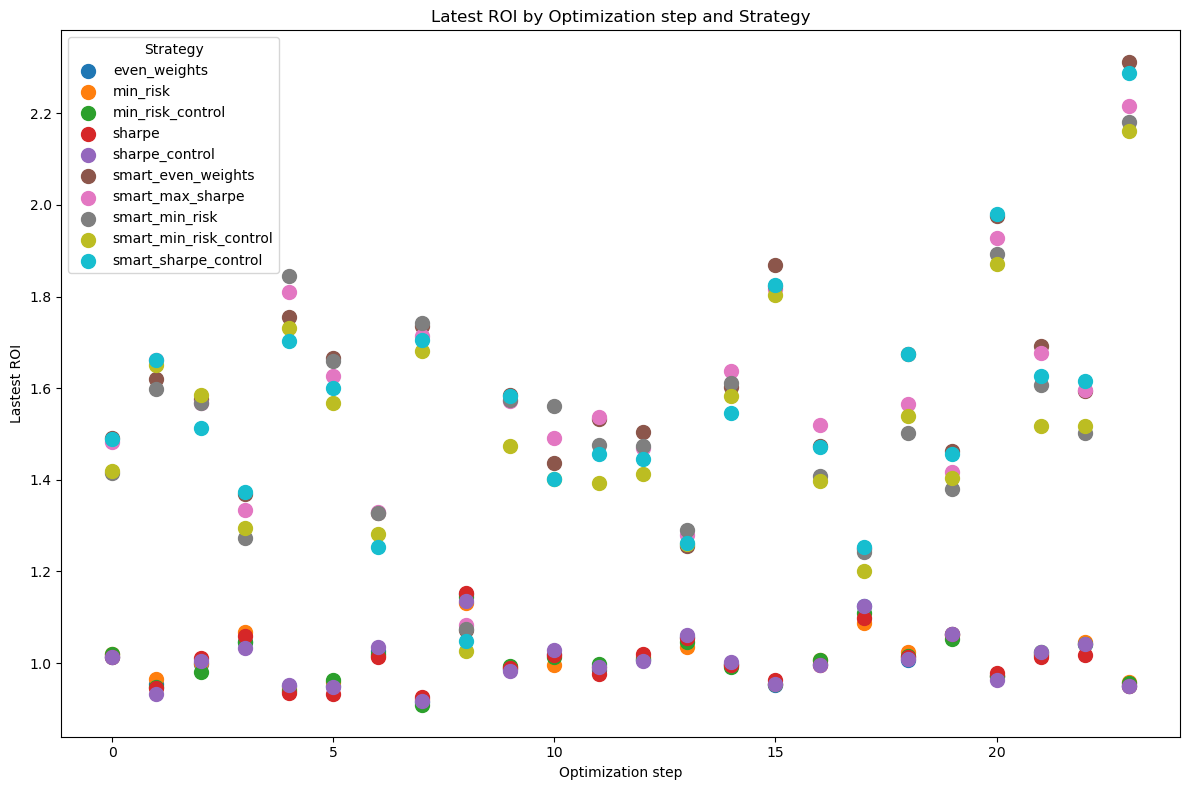

In [176]:
plt.figure(figsize=(12, 8))

strategies = df['Strategy'].unique()
colors = plt.cm.get_cmap('tab10', len(strategies))

for i, strategy in enumerate(strategies):
    subset = df[df['Strategy'] == strategy]
    plt.scatter(subset['Optimization step'], subset['Lastest ROI'], color=colors(i), label=strategy, s=100)

plt.xticks(range(df['Optimization step'].min(), df['Optimization step'].max() + 1, 5))

plt.xlabel('Optimization step')
plt.ylabel('Lastest ROI')
plt.title('Latest ROI by Optimization step and Strategy')
plt.legend(title='Strategy', loc='upper left', bbox_to_anchor=(0, 1))
plt.grid(False)
plt.tight_layout()

plt.savefig('latest_roi_by_optimization_step.png', bbox_inches='tight')
plt.show()

In [83]:
df

Strategy  Lastest ROI
Time                                     
0               even_weights         1.01
0         smart_even_weights         1.49
0           smart_max_sharpe         1.48
0             smart_min_risk         1.42
0     smart_min_risk_control         1.42
...                      ...          ...
23              even_weights         0.95
23        smart_even_weights         2.31
23          smart_max_sharpe         2.22
23            smart_min_risk         2.18
23    smart_min_risk_control         2.16

[120 rows x 2 columns]

In [200]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Criar um DataFrame exemplo
df = pd.DataFrame({
    'A': np.random.randint(0, 1, size=252*2),  # Ajuste o tamanho para 252*2
    'B': np.random.randint(0, 1, size=252*2),
    'C': np.random.randint(0, 1, size=252*2)
})

# Definir o tamanho da janela
window_size = 60
num_chunks = len(df) // window_size

# Criar o gráfico
fig = go.Figure()

# Definir cores diferentes para cada chunk
colors = [f'rgba({np.random.randint(0, 256)}, {np.random.randint(0, 256)}, {np.random.randint(0, 256)}, 0.6)' for _ in range(num_chunks)]

for i in range(num_chunks):
    start_idx = i * window_size
    end_idx = start_idx + window_size
    y_start = i  # Usar o índice do chunk para a posição vertical

    # Adicionar retângulo
    fig.add_shape(
        type="rect",
        x0=start_idx, x1=end_idx,  # Tamanho do retângulo na horizontal
        y0=y_start, y1=y_start + 1,  # Tamanho do retângulo na vertical
        line=dict(color="Black", width=1),
        fillcolor=colors[i]
    )

    # Adicionar texto dentro do retângulo
    fig.add_trace(go.Scatter(
        x=[(start_idx + end_idx) / 2], y=[y_start + 0.5],
        text=[f'Size: {window_size}'],
        mode='text',
        showlegend=False
    ))

    # Adicionar trace para o texto abaixo do retângulo
    fig.add_trace(go.Scatter(
        x=[(start_idx + end_idx) / 2], y=[y_start - 0.2],  # Posicionar abaixo do retângulo
        text=[f'{i + 1}i'],
        mode='text',
        showlegend=False
    ))

# Marcar as posições no eixo X
tick_positions = [i * window_size for i in range(1, num_chunks + 1)]
tick_labels = [f'{i * window_size}' for i in range(1, num_chunks + 1)]

fig.update_layout(
 
    xaxis_title='Chunk size',
    yaxis_title='Quantity of chunks',
    xaxis=dict(
        range=[0, 252*2],  # Ajustar o intervalo do eixo X
        tickvals=tick_positions,
        ticktext=tick_labels,
        showgrid=False,  # Remover linhas de grade do eixo x
        zeroline=False  # Remover linha zero do eixo x
    ),
    yaxis=dict(
        autorange='reversed',  # Inverter a ordem dos valores no eixo y
        tickvals=list(range(num_chunks)),
        ticktext=[str(i + 1) for i in range(num_chunks)],  # Ajustar os rótulos do eixo y para 1, 2, 3, ...
        range=[-1, num_chunks],  # Ajustar o intervalo do eixo Y para incluir todos os chunks
        showgrid=False,  # Remover linhas de grade do eixo y
        zeroline=False  # Remover linha zero do eixo y
    ),
    plot_bgcolor='white',  # Cor de fundo do gráfico
    paper_bgcolor='white',  # Cor de fundo do papel
    font=dict(family="Courier New, monospace", size=12, color="Black")  # Fonte estilo manuscrito
)

fig.show()
